### create hourly Fraser turbidity time series where gaps 4 hrs or less are filled by linear interpolation

### create daily averages from hourly time series and fill larger gaps based on interpolation of daily averages

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
import re
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc

from sqlalchemy.sql import select, and_, or_, not_, func
from sqlalchemy import create_engine, Column, String, Integer, Boolean, MetaData, Table, case, between, ForeignKey, desc
from sqlalchemy.orm import mapper, create_session, relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
import sqlalchemy.types as types
from sqlalchemy.sql import select, and_, or_, not_, func
from time import strptime
import string
import pandas as pd
from dateutil.parser import parse as dutparse
#from dataProcess import forceNumeric, forceInt, fmtVarName, data2Tbl, adFunONC

%matplotlib inline

In [2]:
# set to last available data!
startdate=dt.date(2013,1,1)
enddate=dt.date(2019,6,16) # in this case end date is not included

In [3]:
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'ECBuoy/'
dbname='ECBuoy'
Base = automap_base()
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
FBuoyTBL=Base.classes.FBuoyTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [4]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + dt.timedelta(n)

In [5]:
dt.datetime(1900,1,1)+dt.timedelta(days=session.query(FBuoyTBL.DecDay).order_by(FBuoyTBL.DecDay).first()[0])

datetime.datetime(2009, 1, 1, 0, 10, 21)

In [6]:
dt.datetime(1900,1,1)+dt.timedelta(days=session.query(FBuoyTBL.DecDay).order_by(desc(FBuoyTBL.DecDay)).first()[0])

datetime.datetime(2019, 6, 17, 16, 10)

In [7]:
df=pd.DataFrame(session.query(FBuoyTBL.DecDay,FBuoyTBL.Turb_NTU).filter(and_(
            FBuoyTBL.Turb_NTU.between(0,200),
            FBuoyTBL.DecDay.between((startdate-dt.date(1900,1,1)).days,
                    (enddate-dt.date(1900,1,1)).days))).all()) # filter out really large values as well as negatives

In [8]:
df['daynum']=0*df['DecDay']
df['hr']=0*df['DecDay']

In [9]:
# create hash of daynum, hour pairs that are in df (where there is data)
#timeSet=set()
for index, row in df.iterrows():
    day=int(np.floor(row['DecDay']))
    hr=int(np.round((row['DecDay']-day)*24))
    df.iloc[index]['daynum','hr']=[day,hr]
    #timeSet=timeSet|set([(day,hr)])
#timeSet

In [10]:
# desired time series is from startdate to enddate
ndays=(enddate-startdate).days+1
ndays

2358

In [11]:
dfout=pd.DataFrame(index=np.arange(0,ndays*24),
                   columns=('DayNum','Hour','Turb_NTU'))
dfdaily=pd.DataFrame(index=np.arange(0,ndays),columns=('DayNum','Turb_NTU'))

In [12]:
for ind,row in dfout.iterrows():
    dfout.iloc[ind]['DayNum','Hour']=[np.floor(ind/24.0)+(startdate-dt.date(1900,1,1)).days,ind%24]
    
for ind,row in dfdaily.iterrows():
    dfdaily.iloc[ind]['DayNum']=ind+(startdate-dt.date(1900,1,1)).days

In [13]:
df[(df.daynum==(startdate-dt.date(1900,1,1)).days)&(df.hr==0)]

DecDay  Turb_NTU   daynum   hr
0  41273.007187       6.3  41273.0  0.0

In [14]:
df[(df.daynum==(startdate-dt.date(1900,1,1)).days)&(df.hr==0)].iloc

In [15]:
df[(df.daynum==(enddate-dt.date(1900,1,1)).days)&(df.hr==23)]

Empty DataFrame
Columns: [DecDay, Turb_NTU, daynum, hr]
Index: []

/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


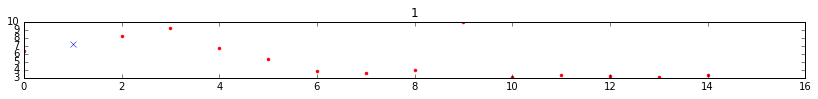

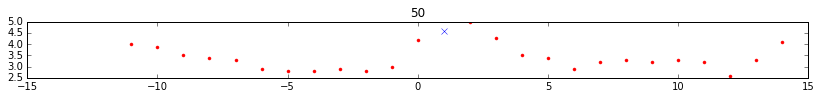

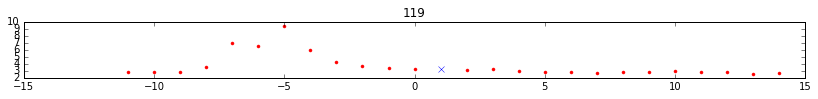

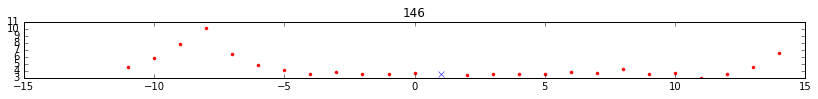

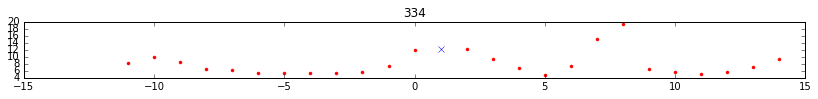

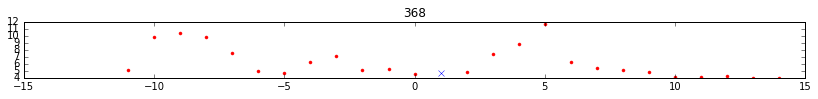

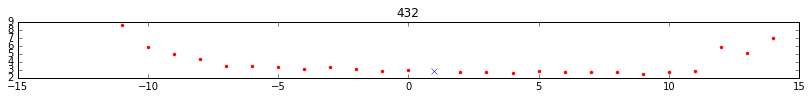

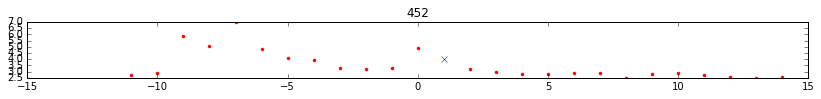

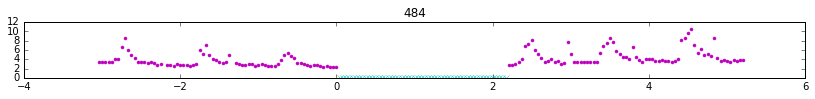

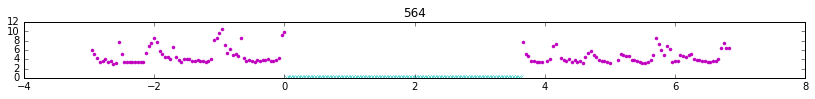

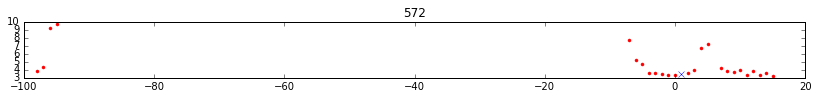

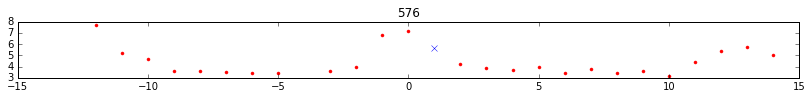

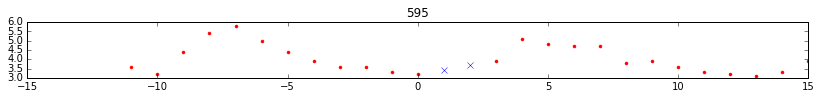

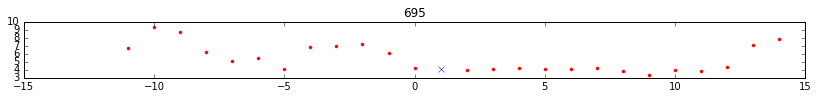

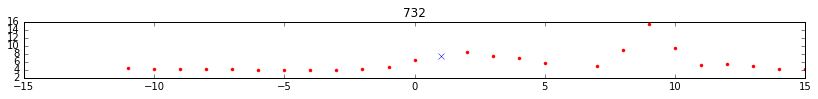

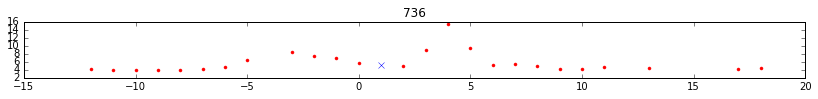

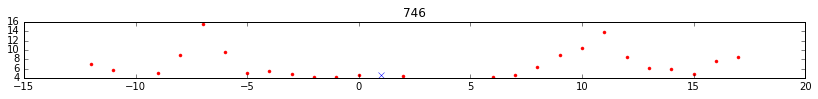

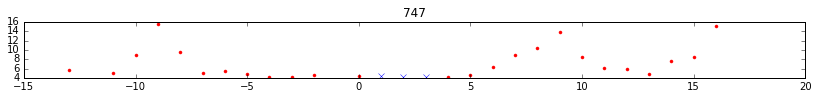

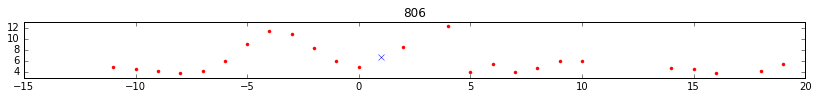

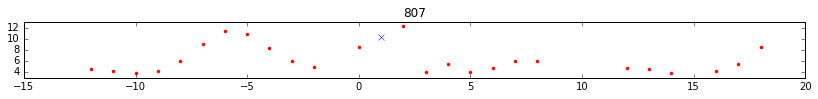

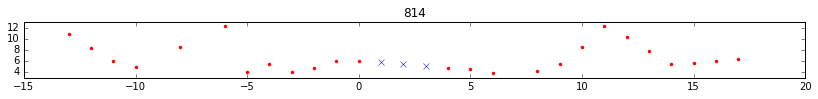

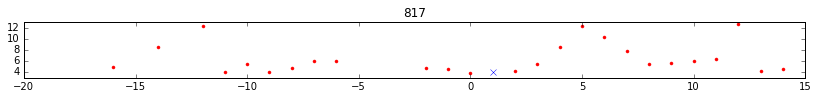

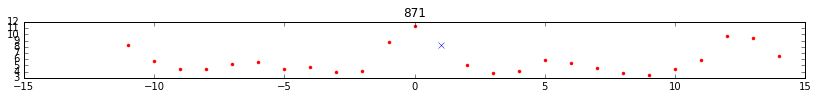

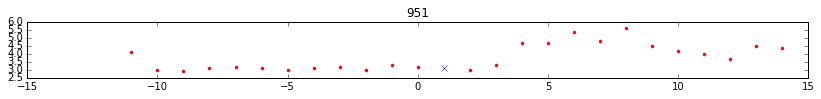

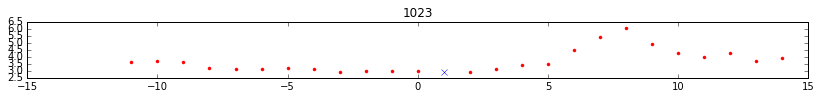

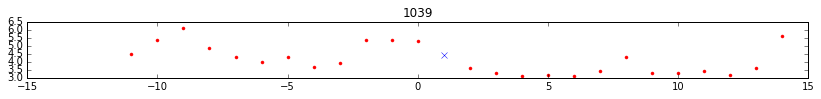

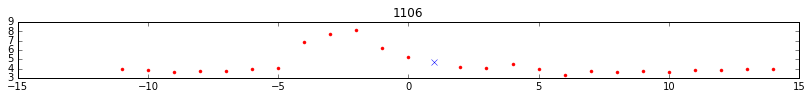

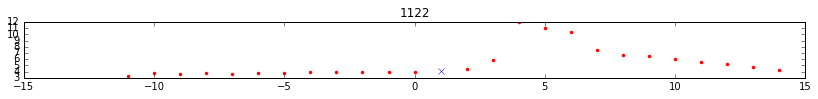

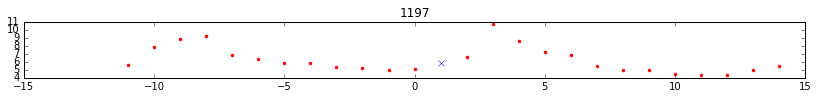

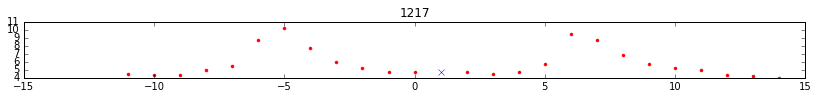

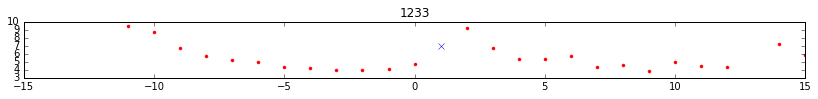

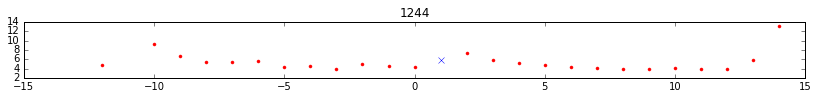

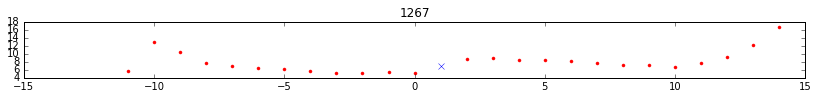

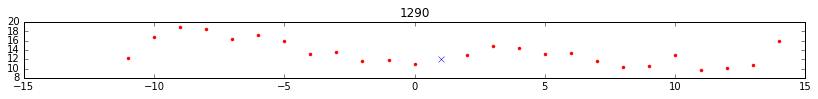

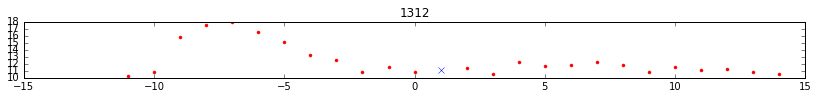

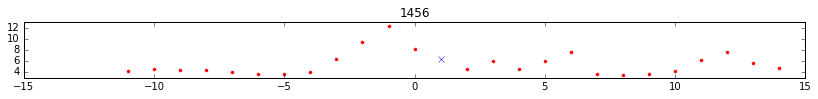

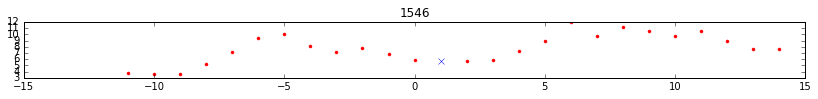

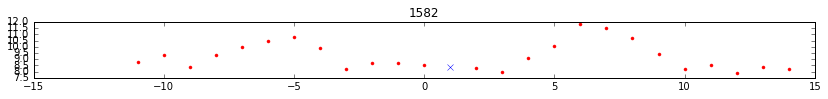

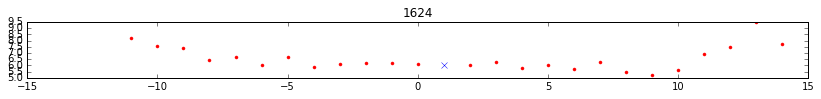

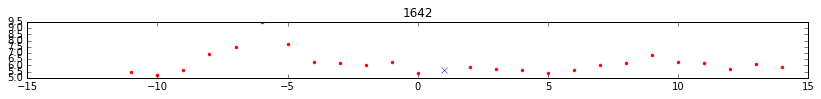

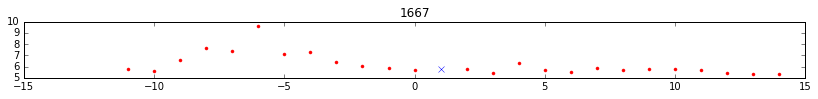

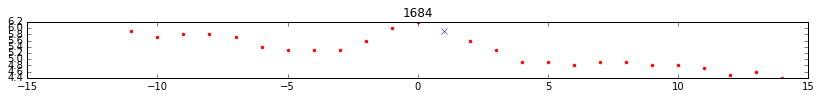

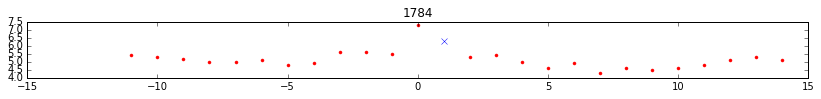

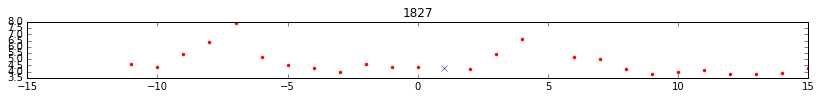

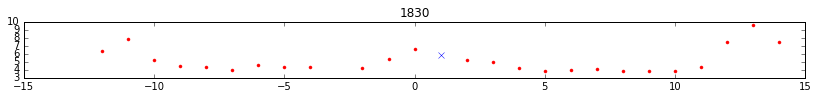

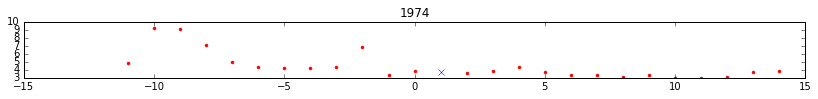

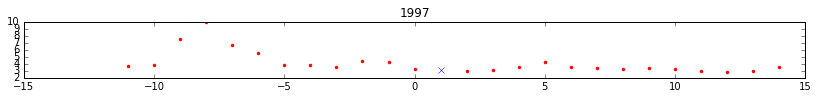

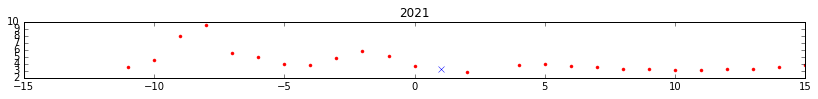

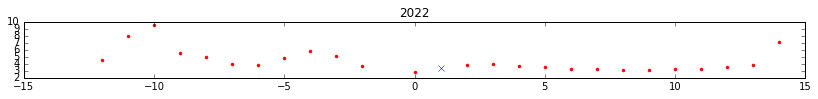

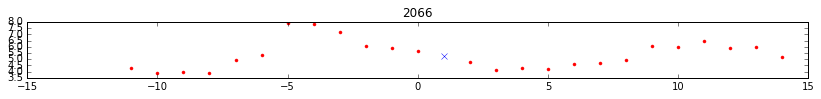

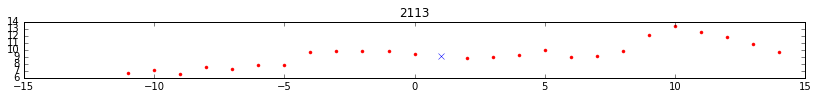

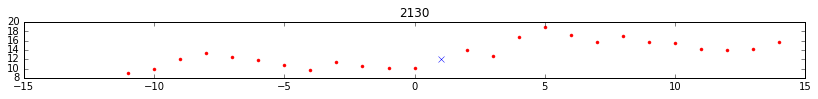

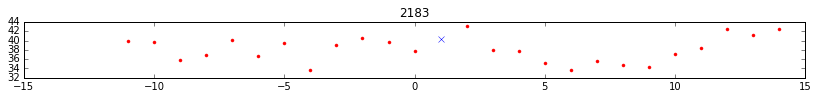

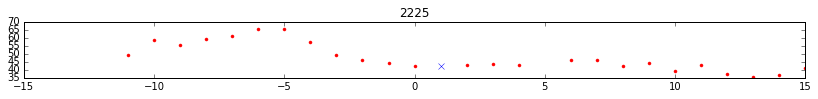

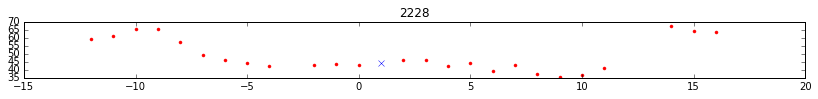

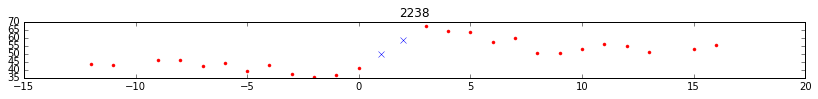

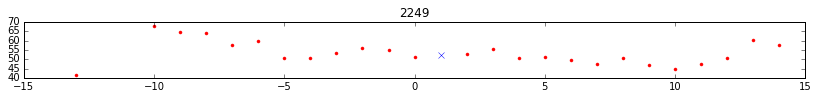

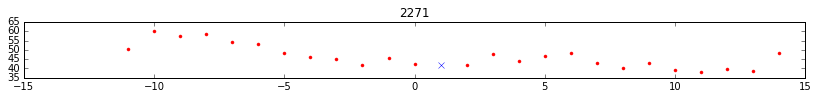

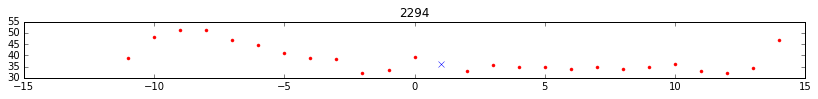

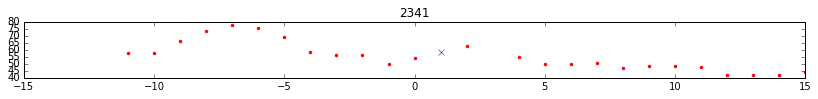

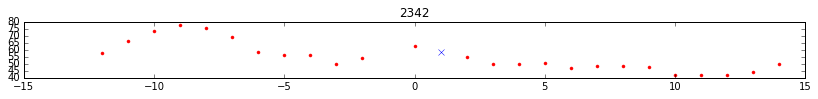

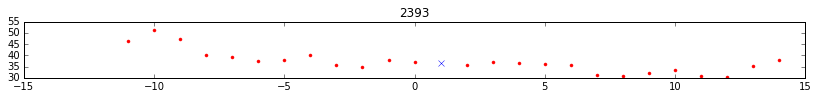

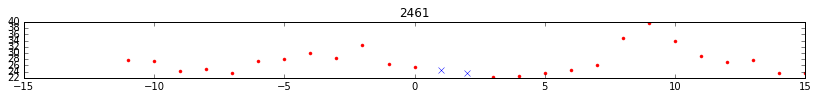

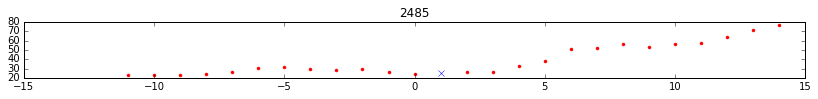

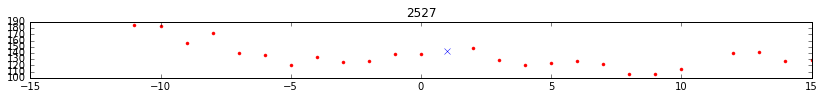

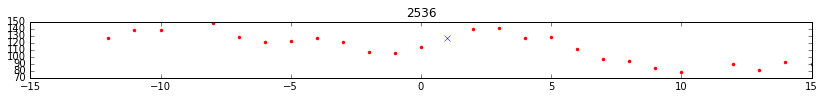

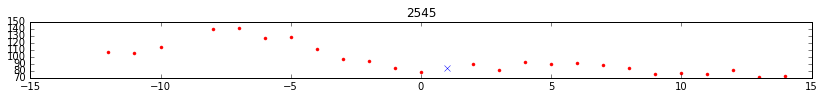

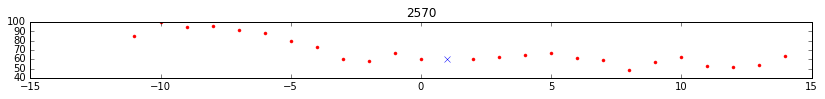

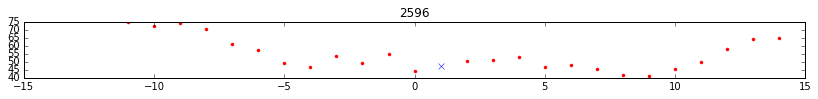

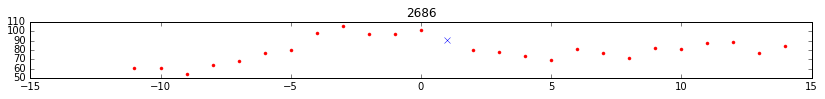

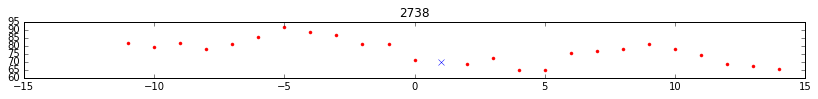

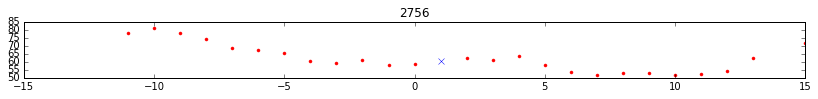

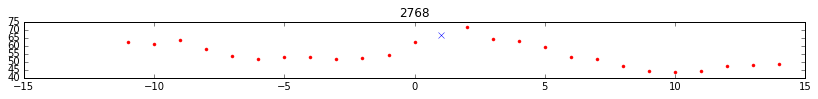

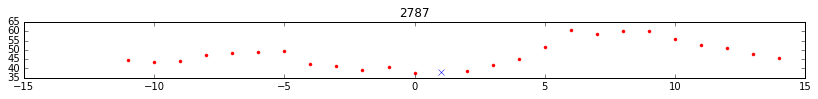

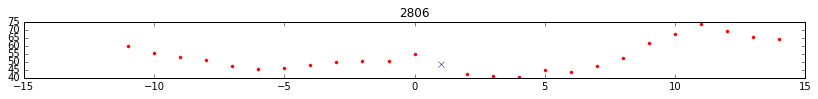

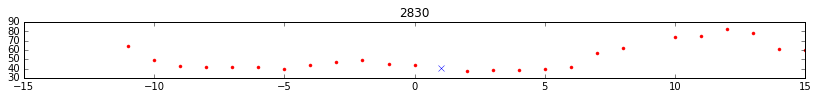

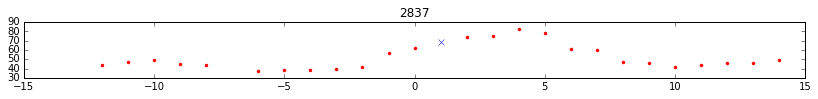

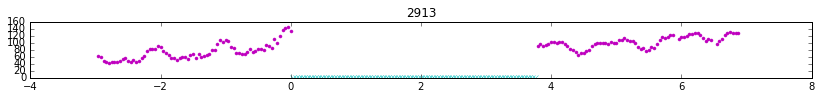

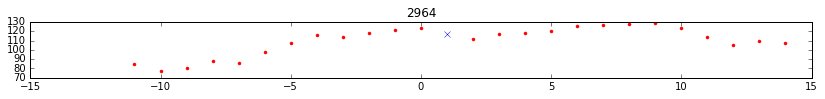

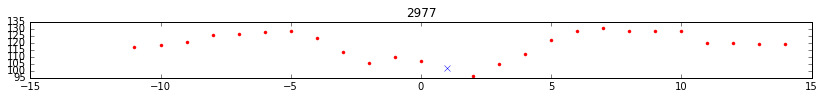

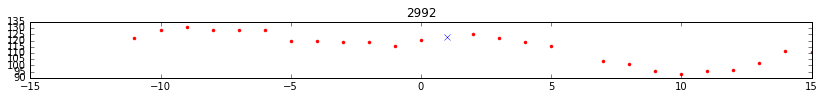

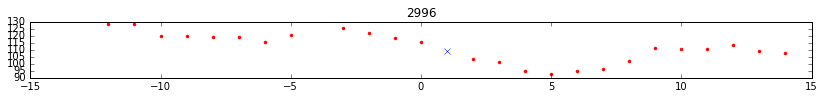

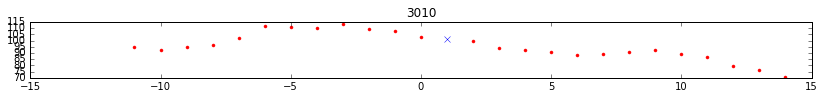

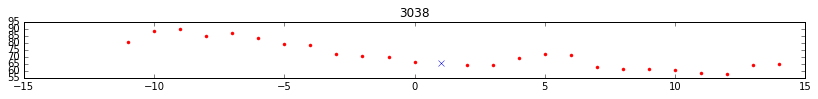

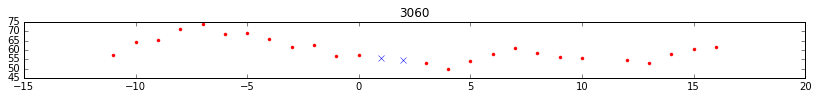

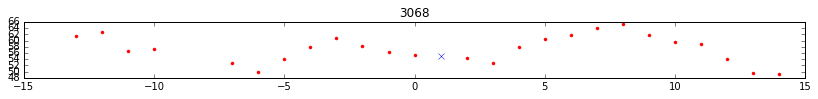

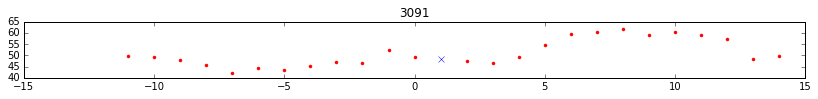

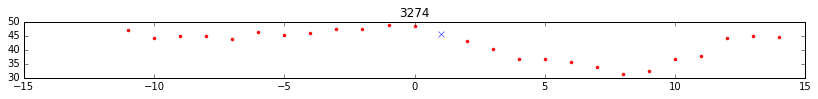

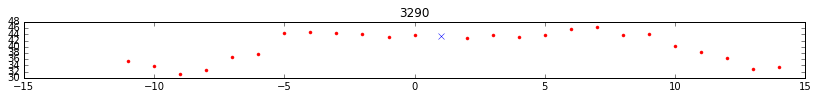

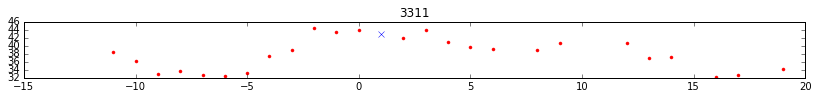

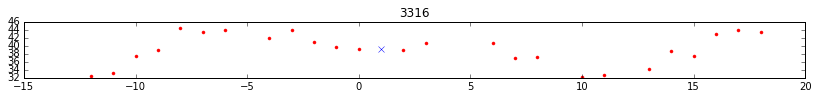

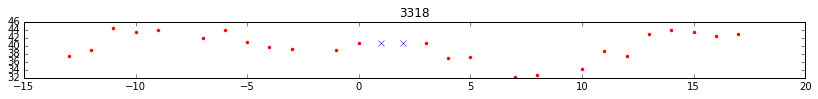

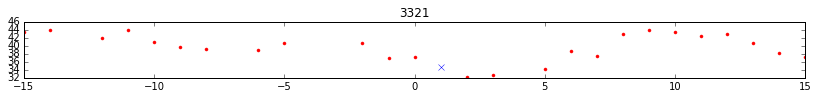

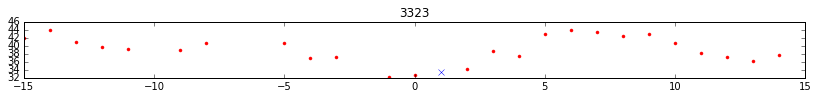

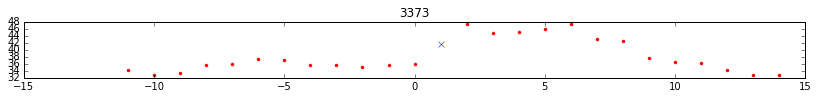

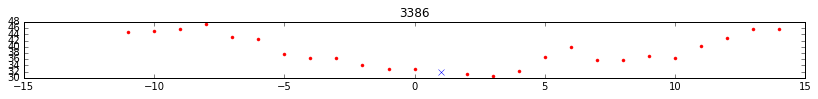

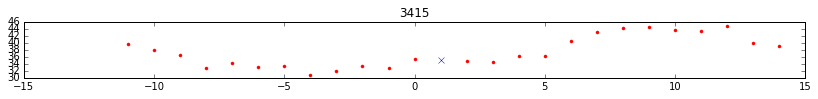

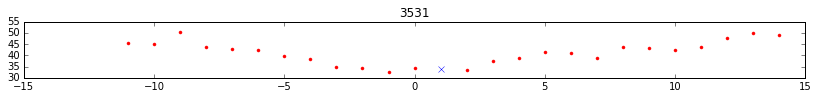

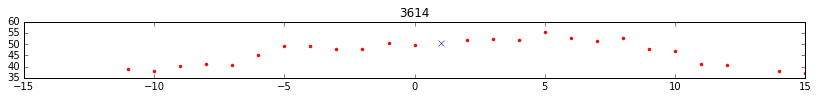

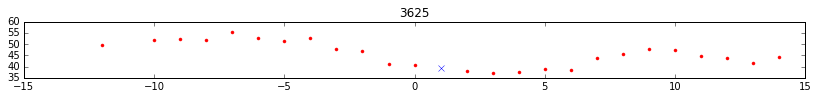

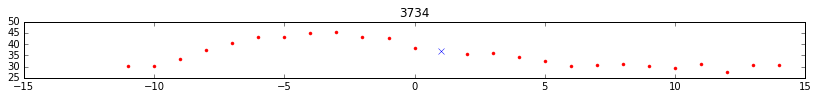

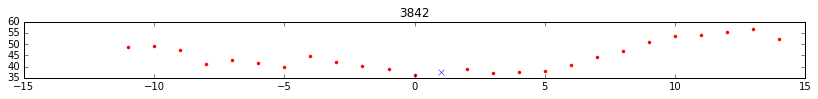

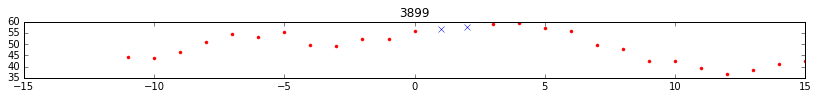

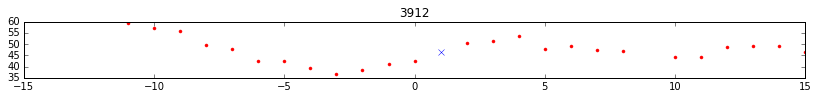

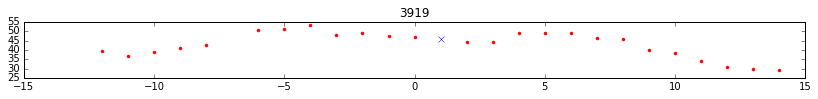

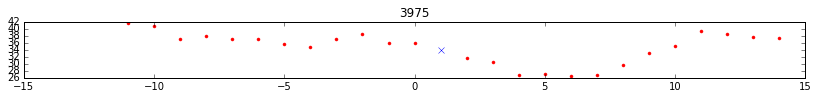

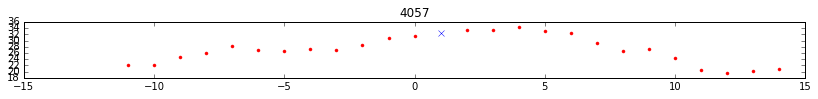

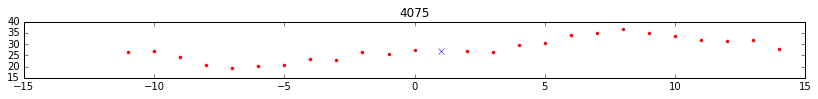

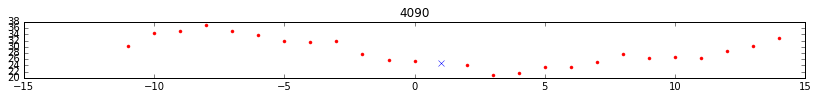

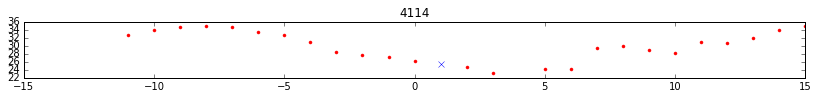

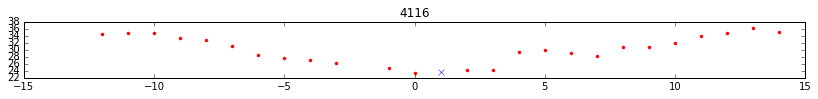

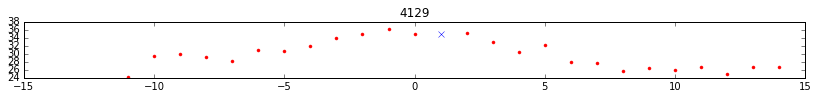

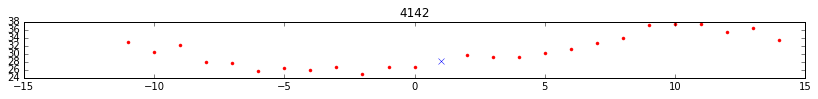

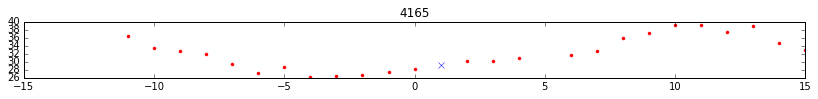

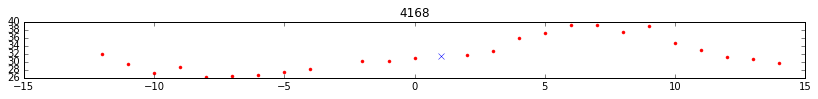

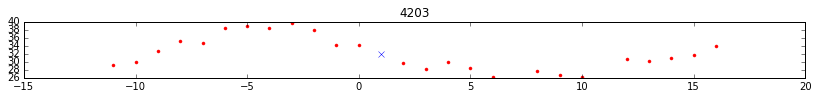

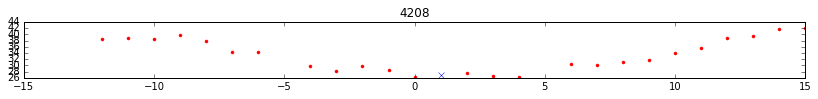

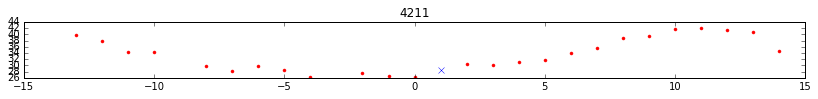

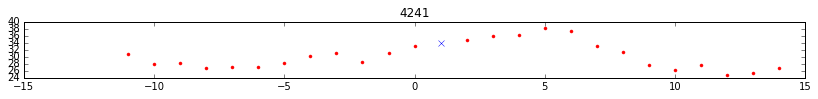

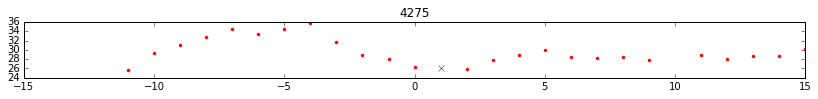

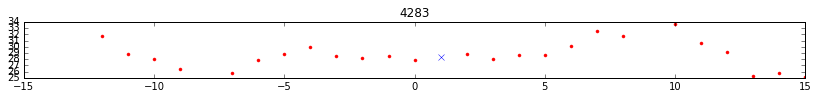

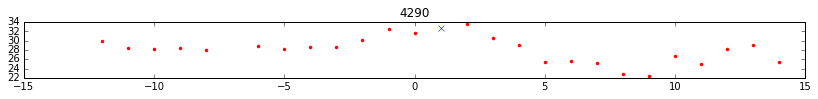

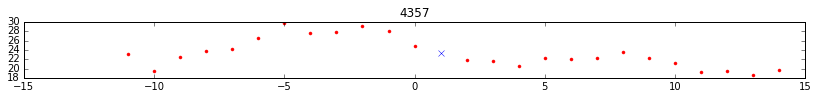

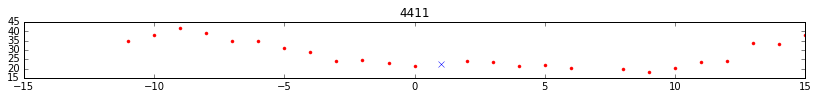

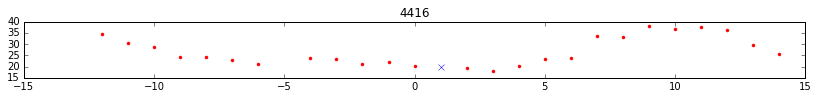

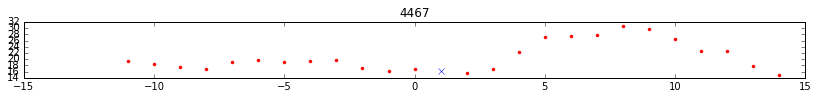

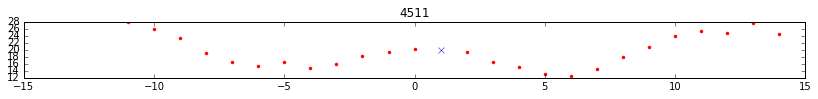

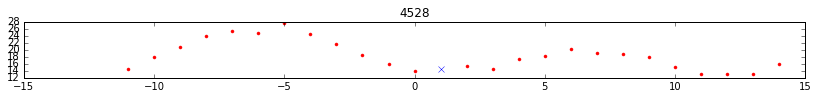

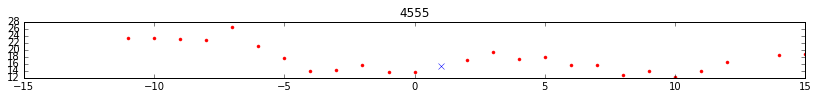

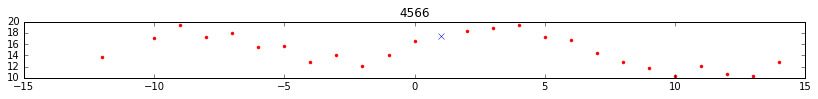

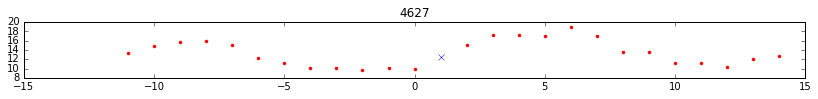

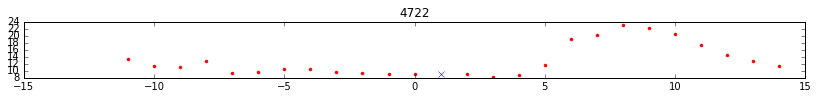

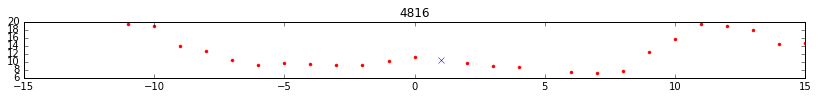

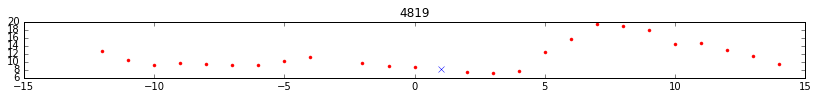

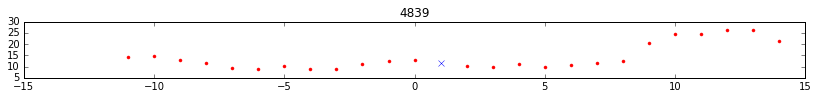

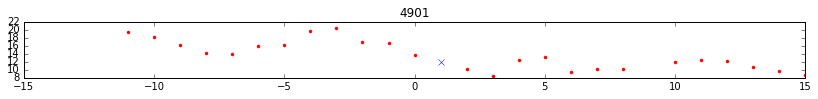

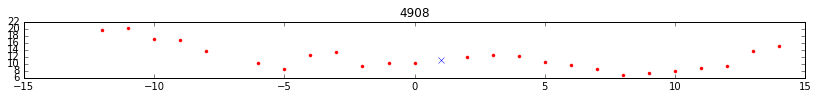

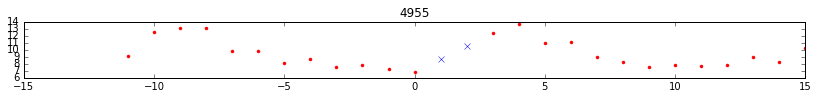

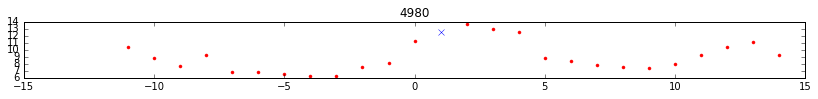

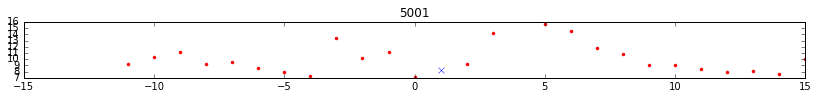

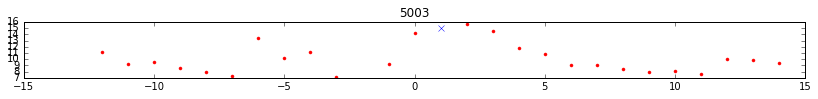

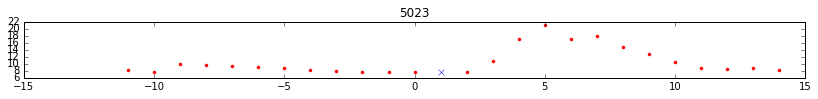

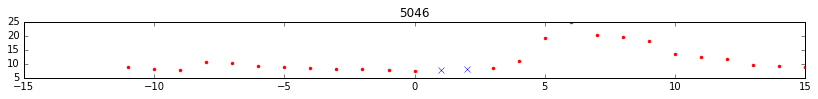

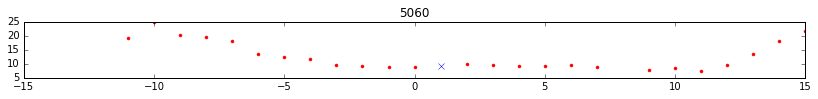

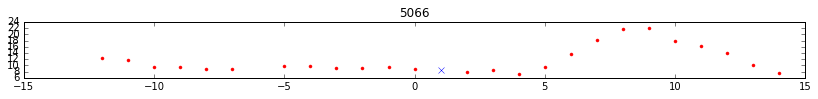

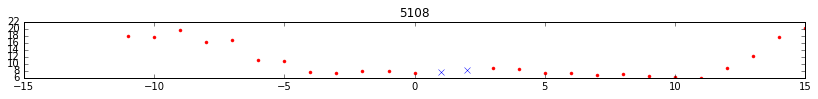

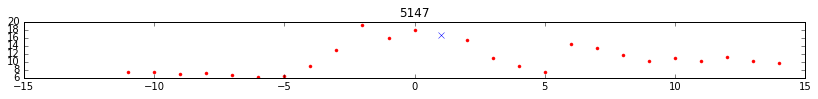

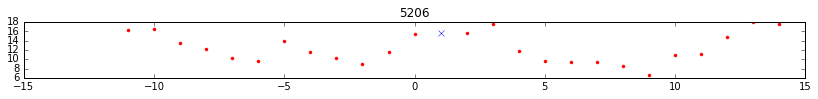

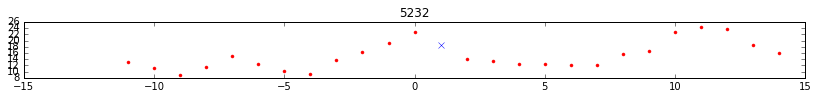

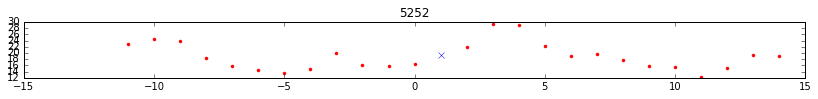

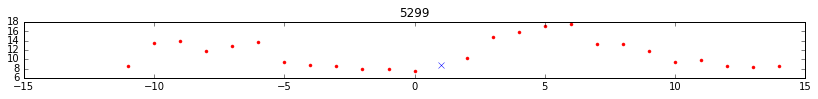

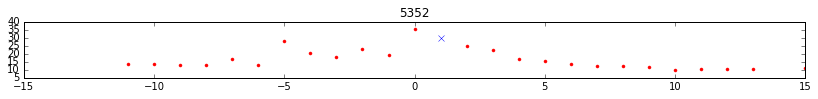

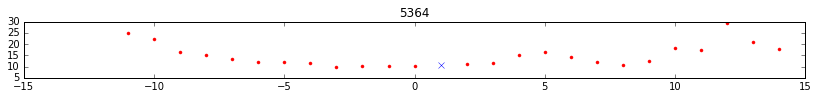

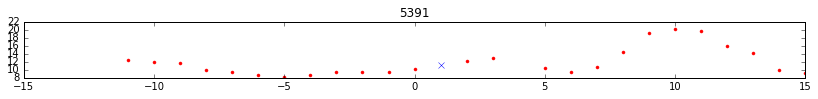

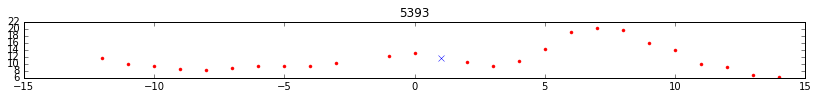

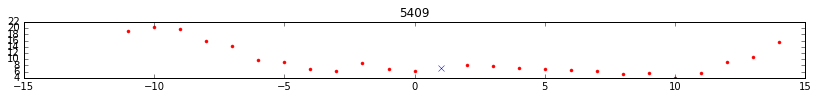

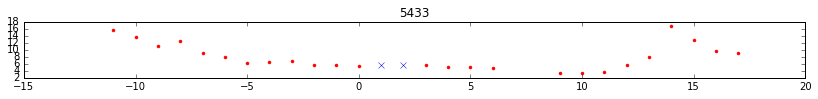

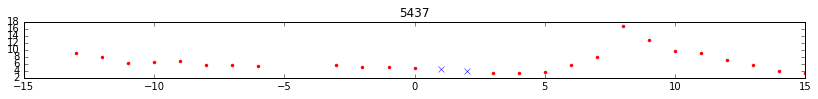

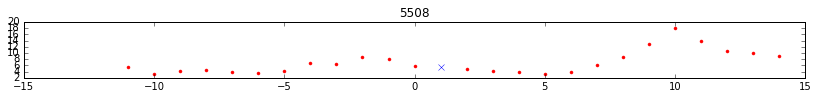

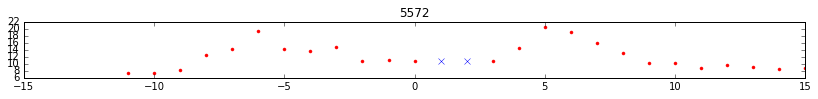

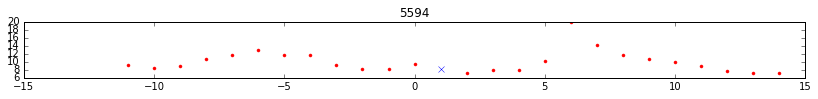

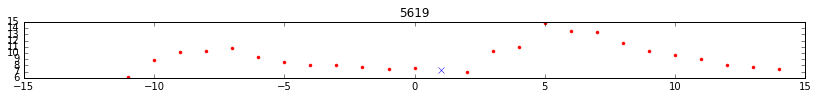

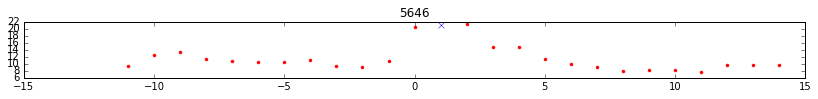

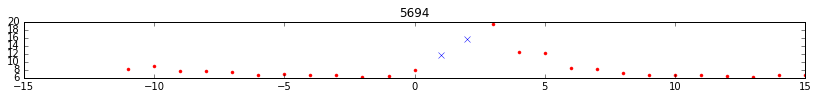

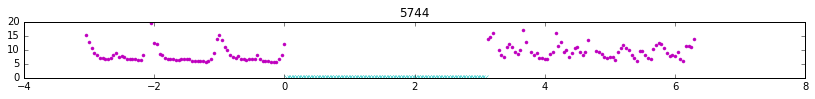

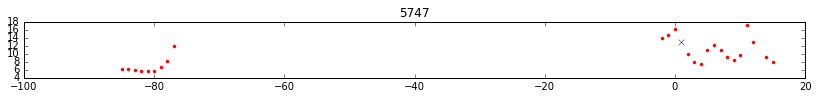

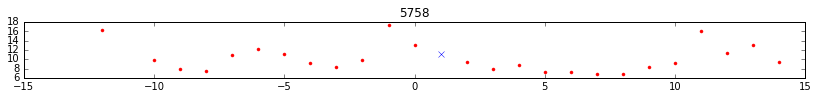

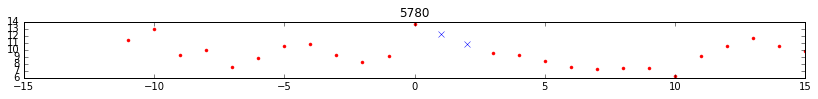

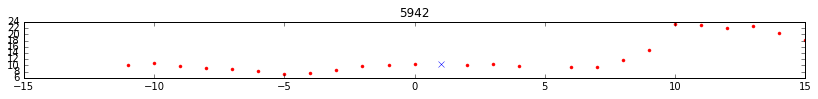

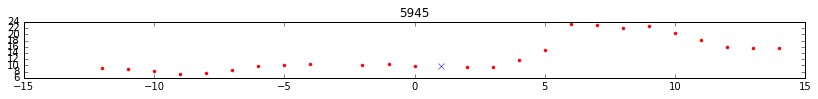

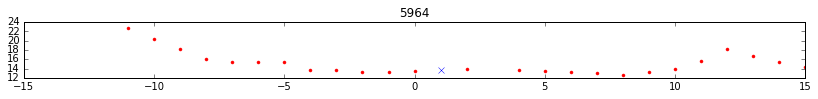

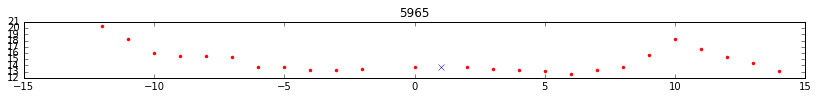

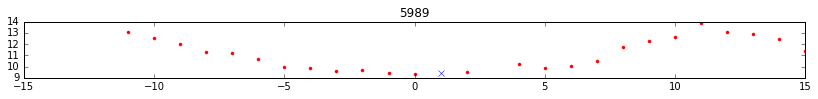

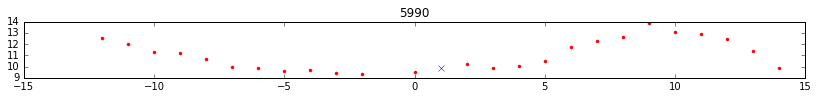

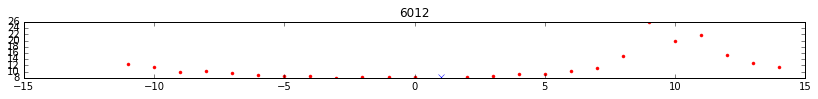

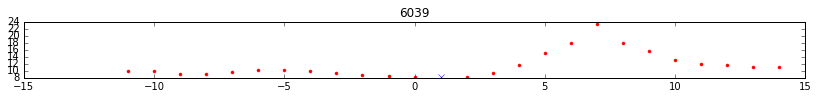

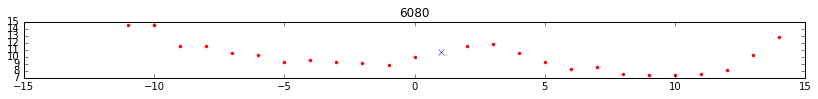

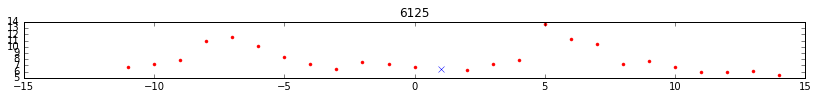

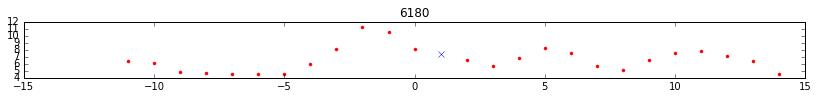

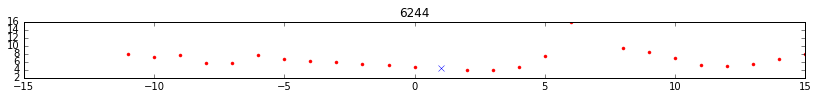

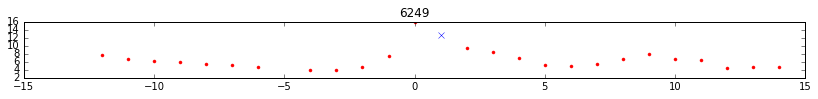

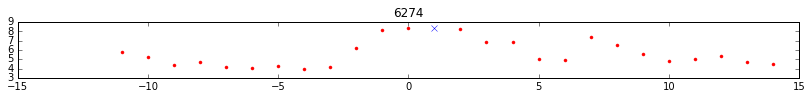

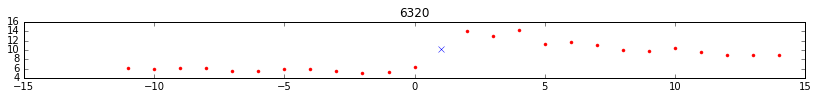

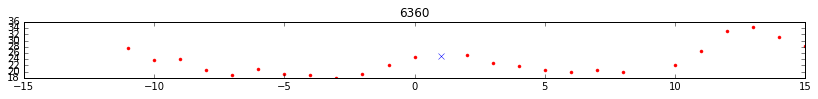

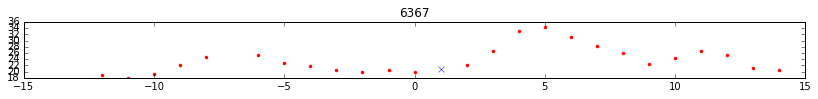

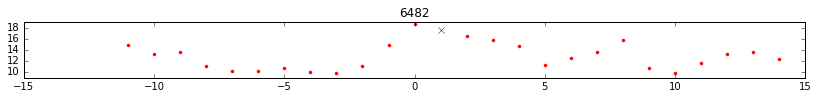

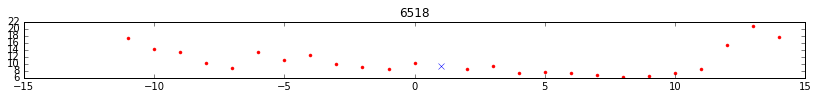

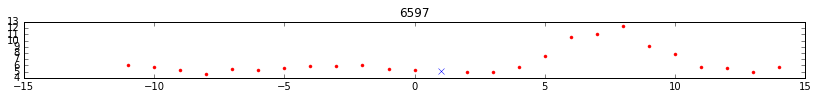

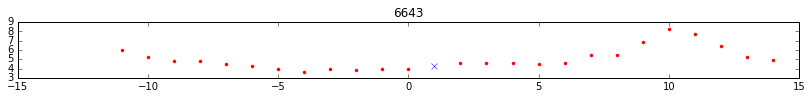

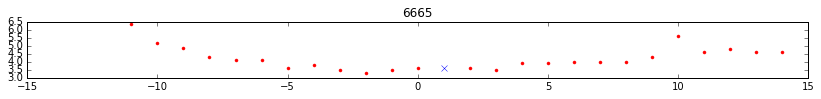

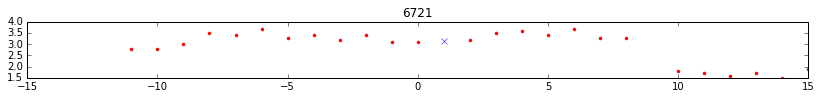

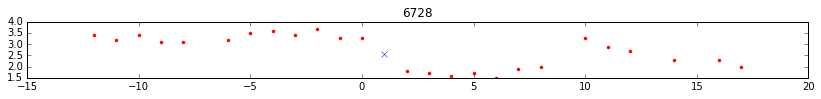

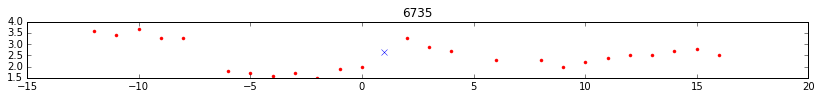

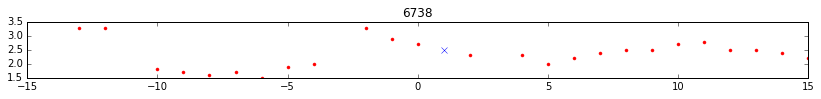

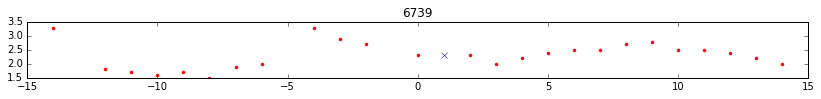

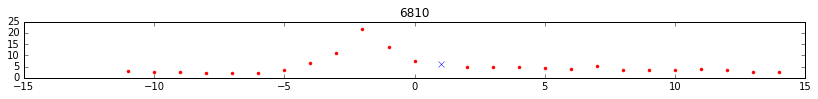

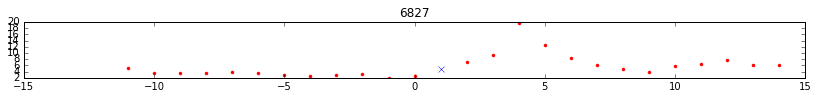

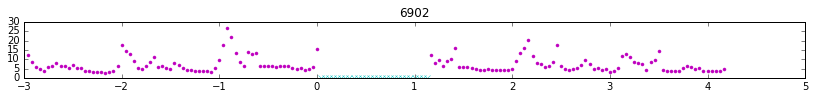

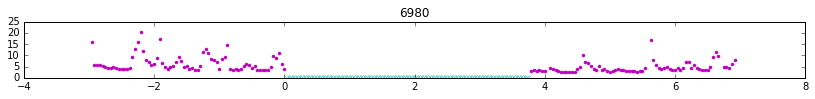

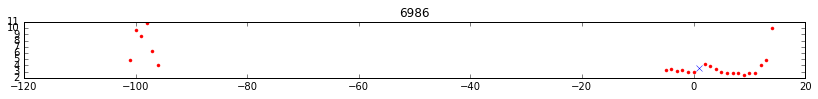

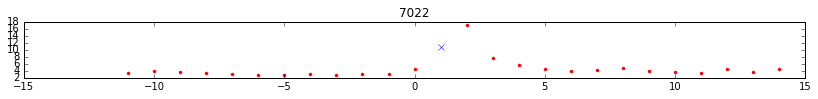

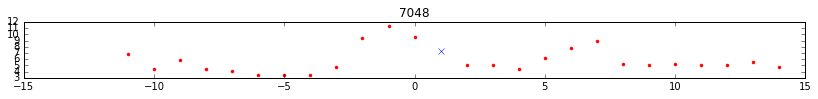

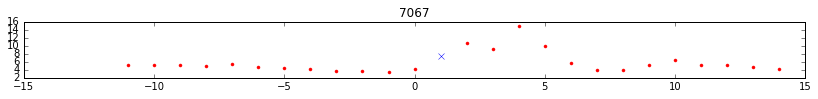

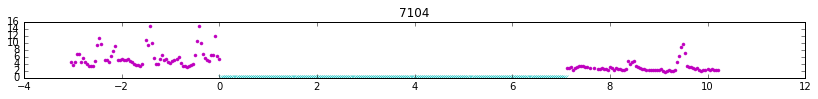

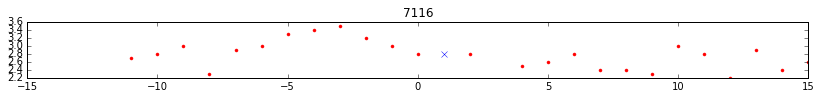

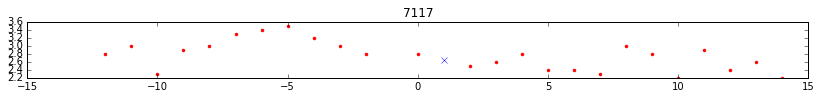

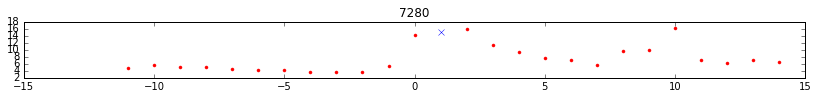

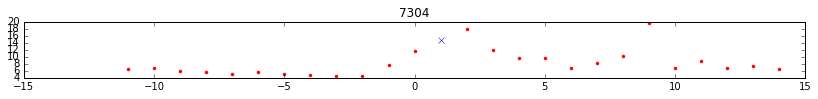

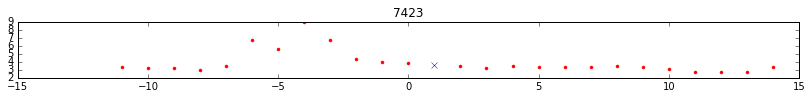

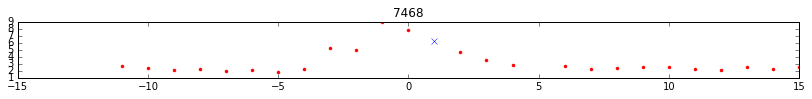

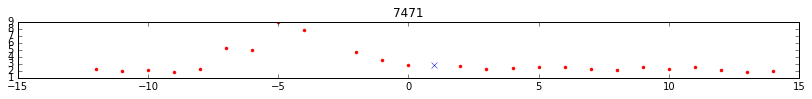

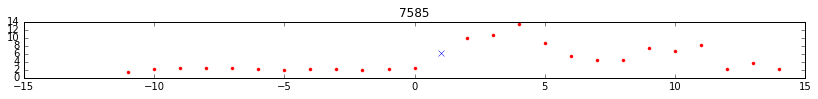

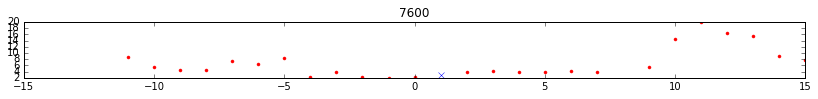

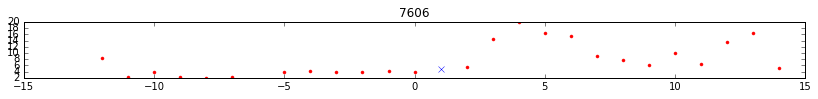

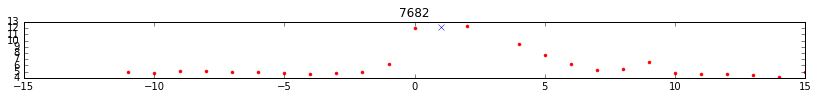

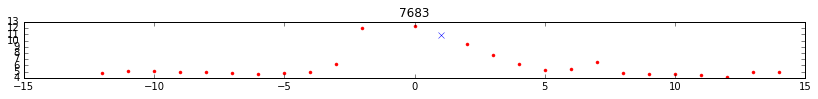

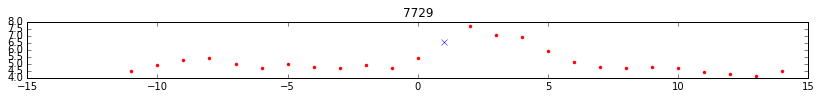

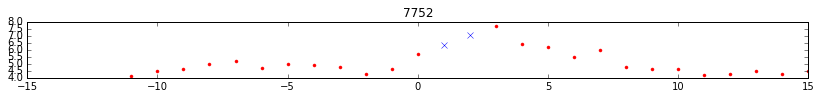

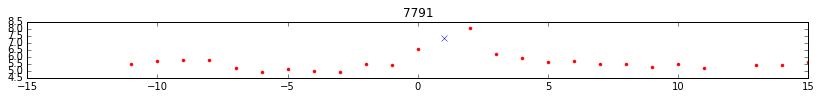

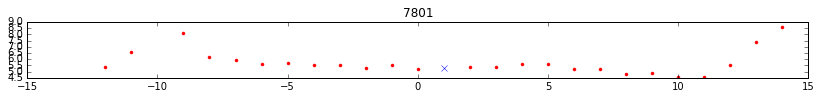

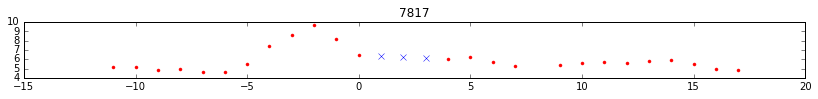

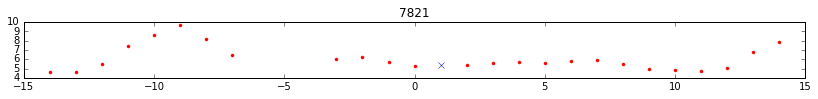

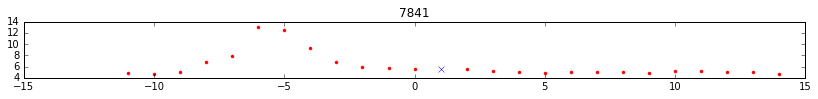

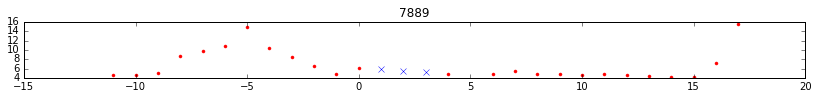

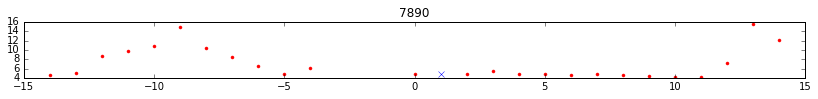

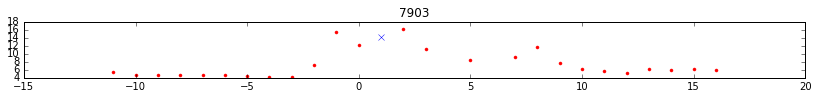

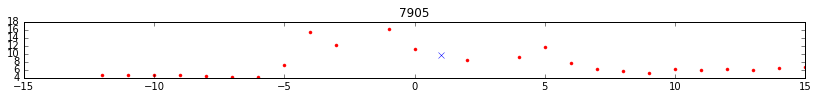

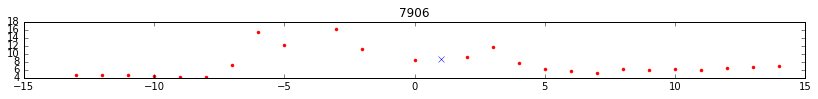

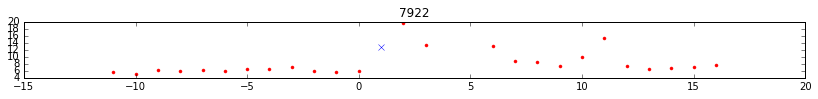

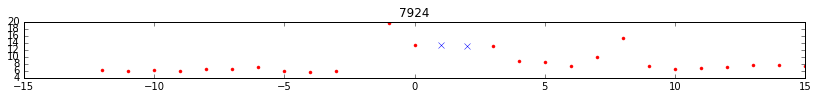

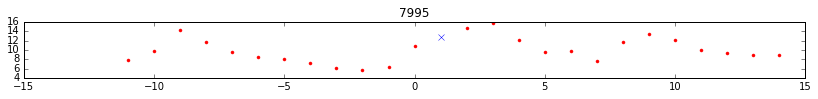

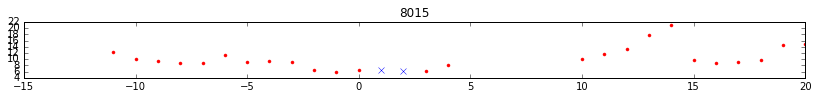

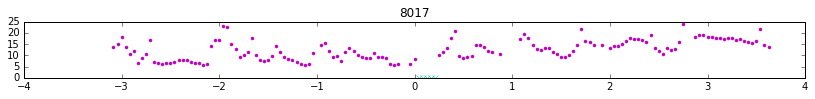

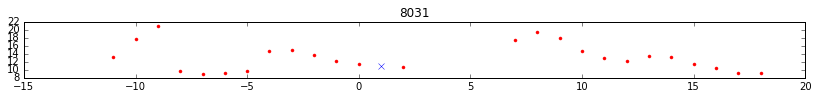

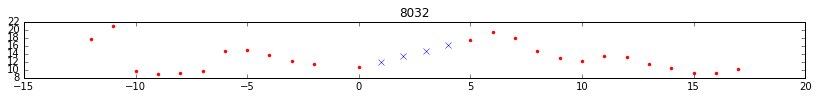

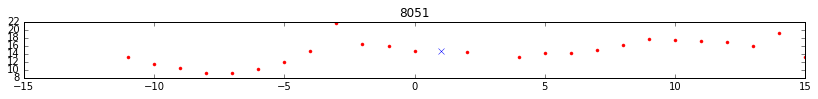

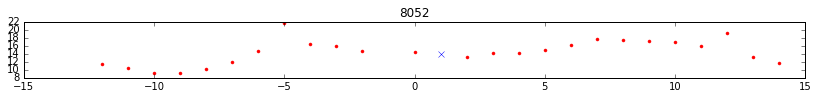

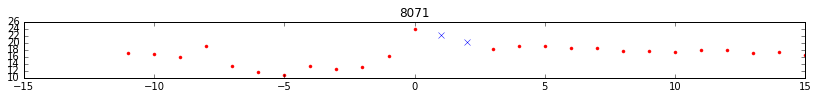

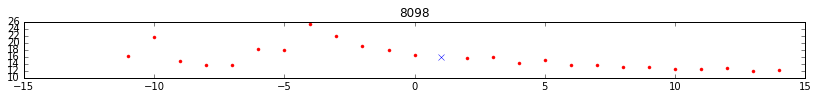

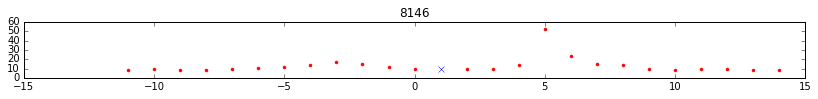

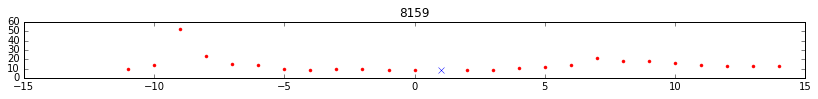

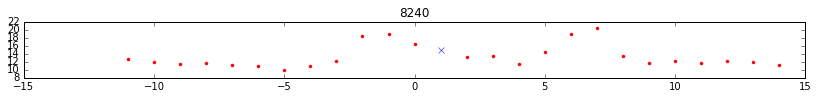

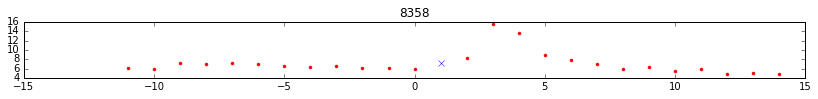

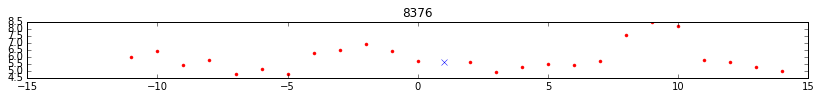

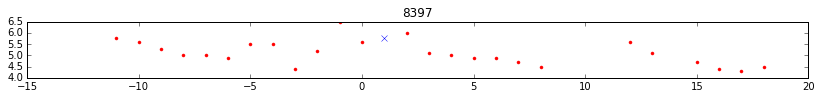

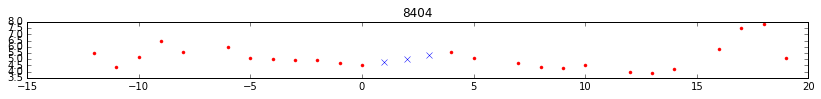

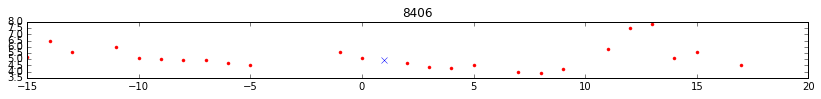

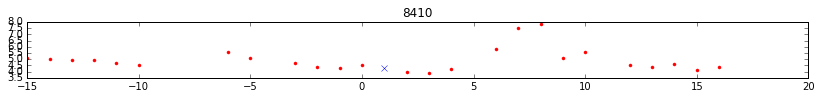

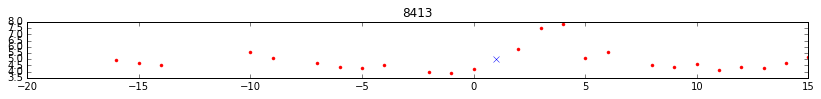

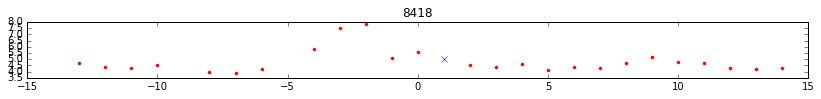

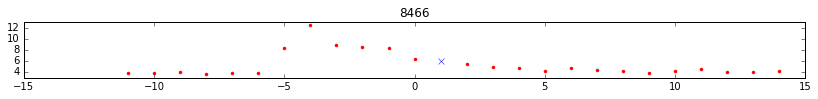

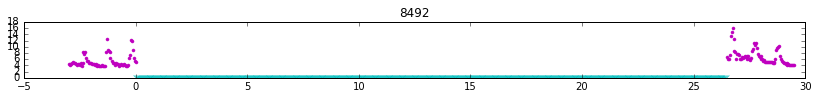

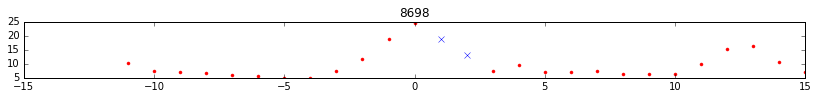

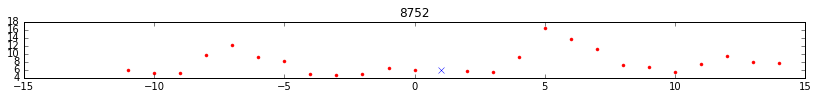

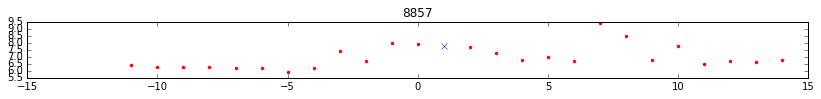

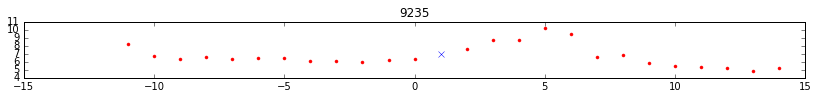

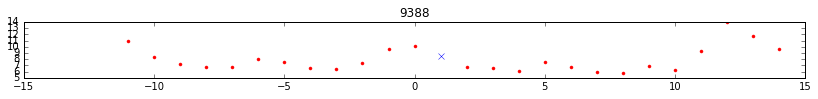

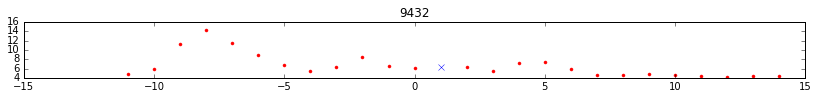

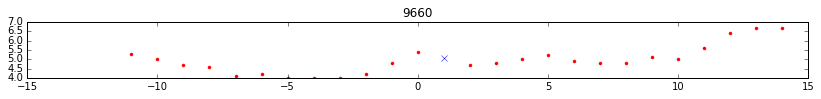

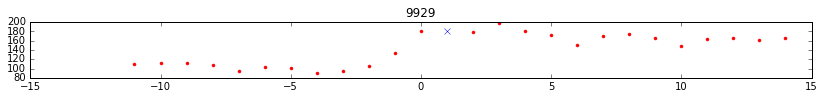

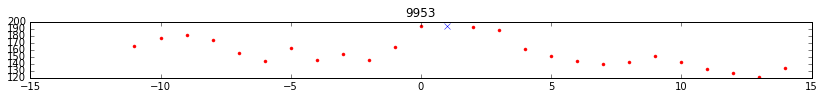

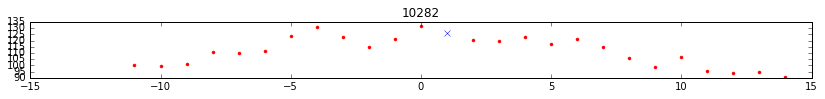

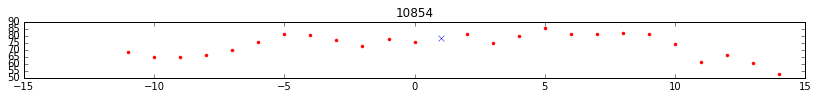

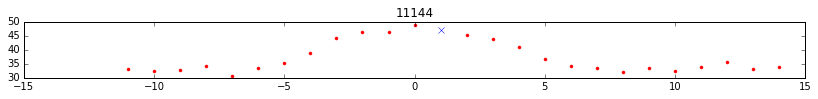

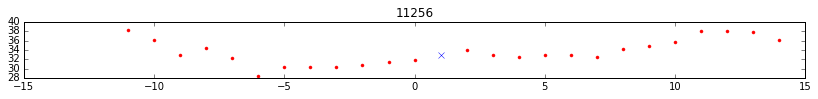

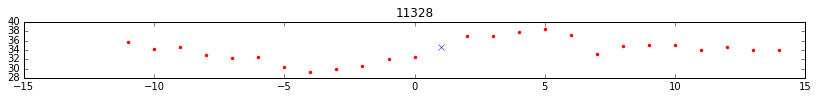

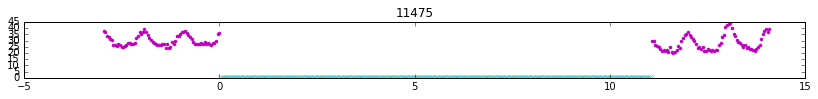

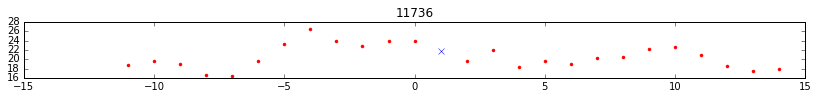

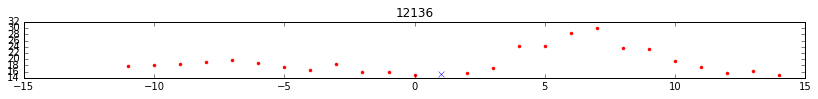

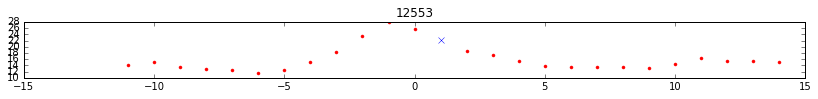

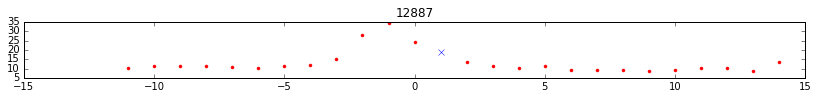

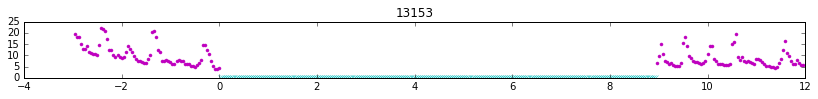

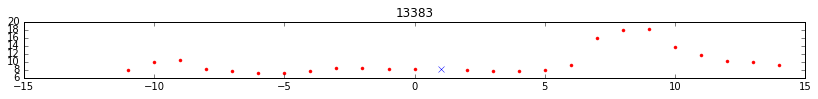

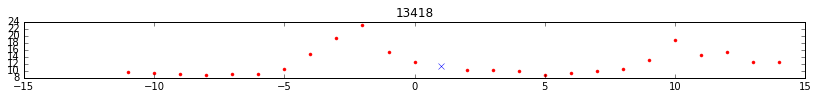

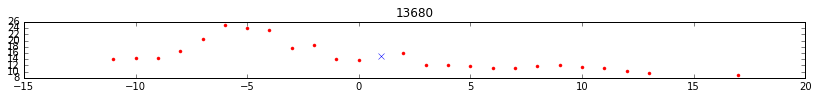

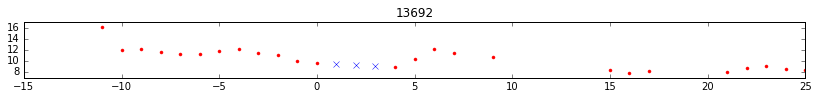

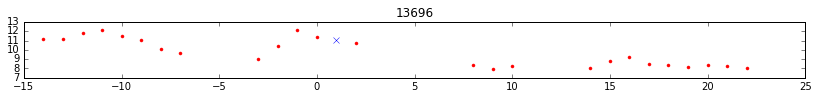

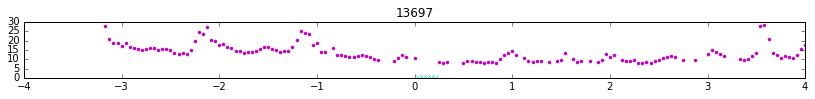

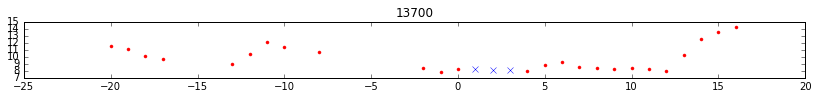

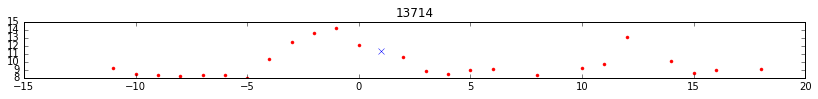

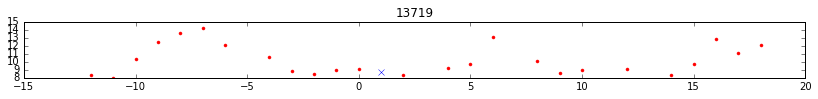

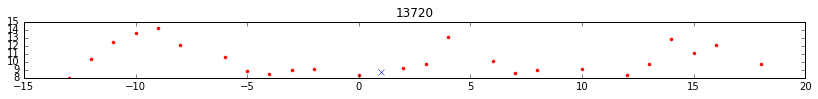

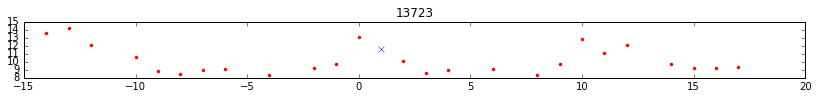

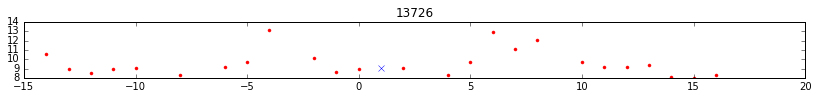

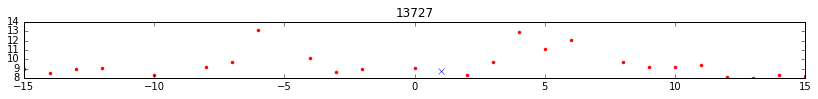

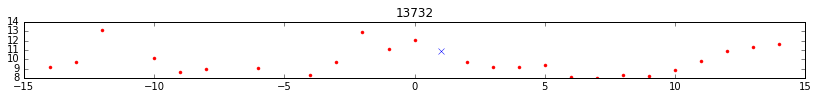

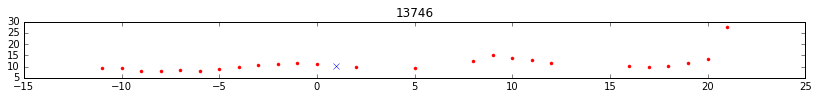

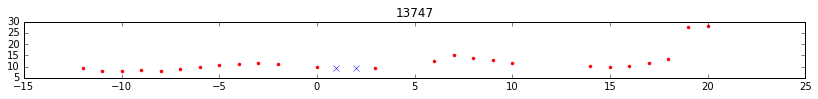

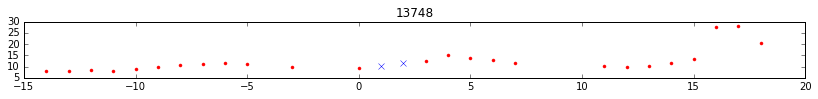

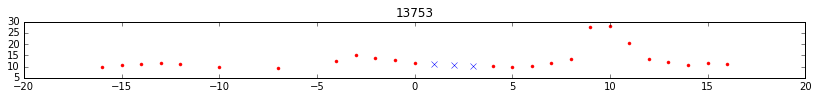

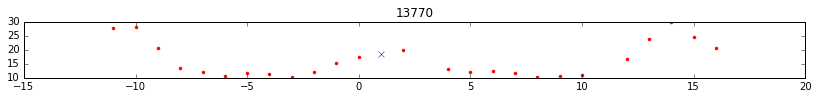

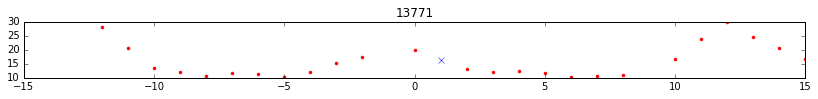

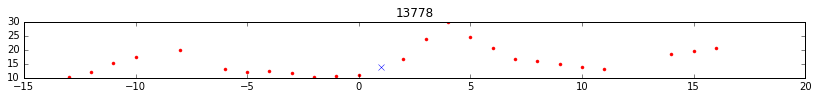

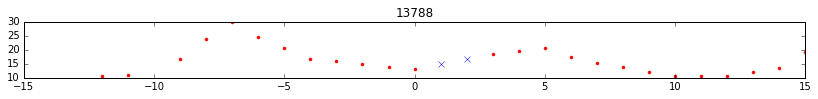

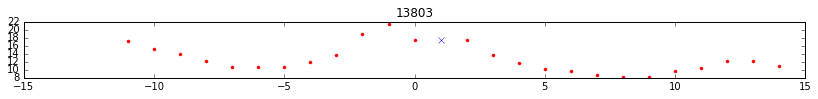

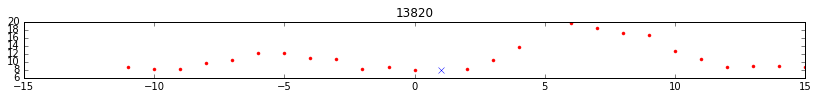

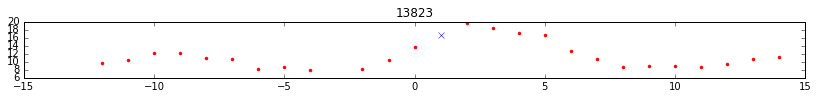

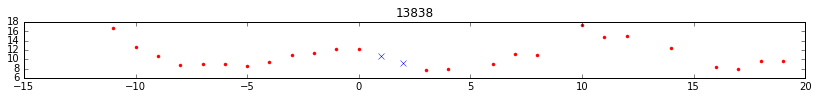

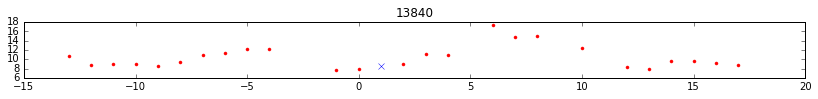

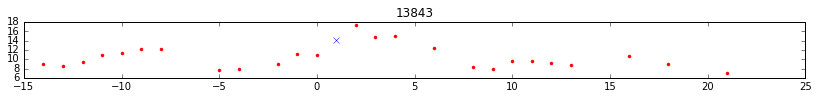

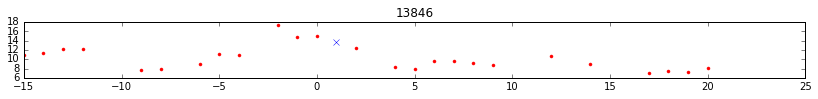

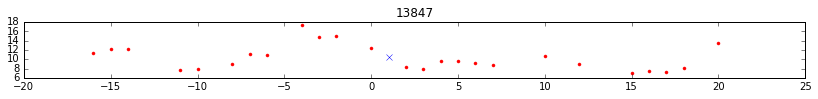

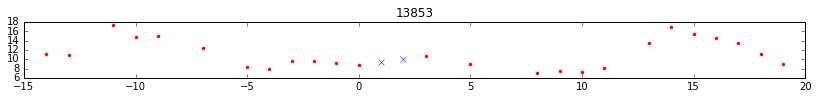

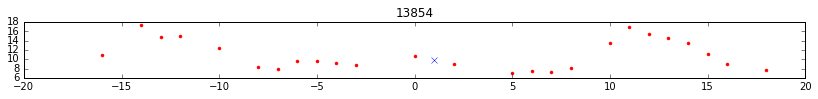

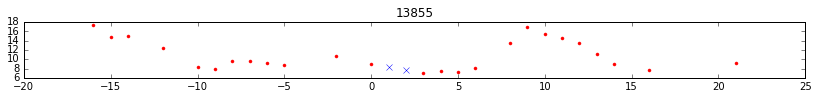

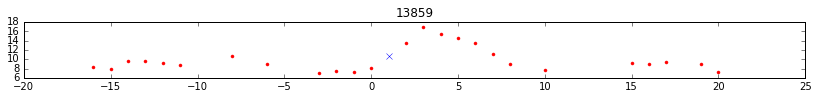

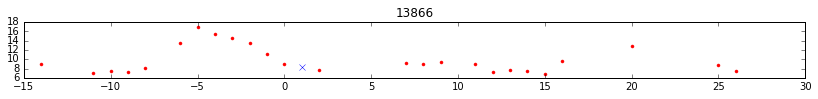

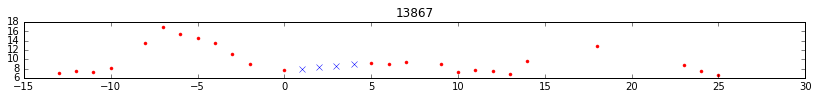

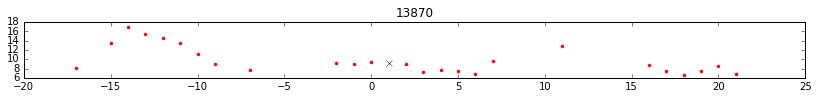

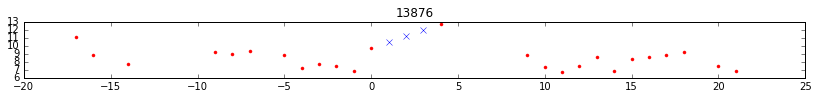

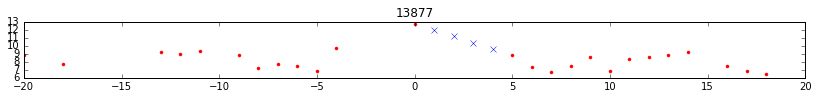

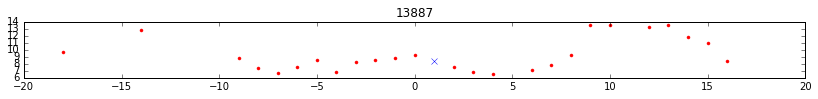

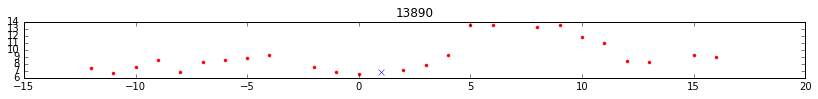

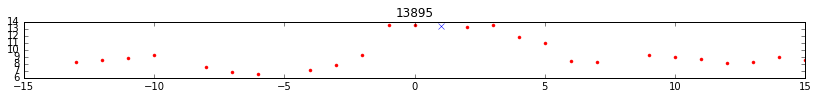

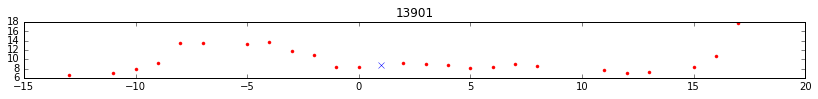

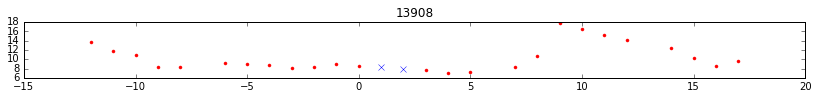

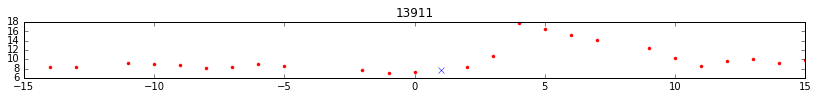

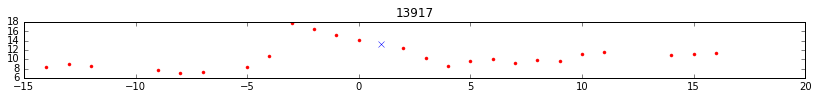

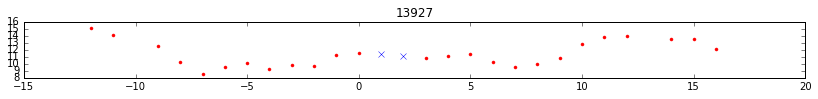

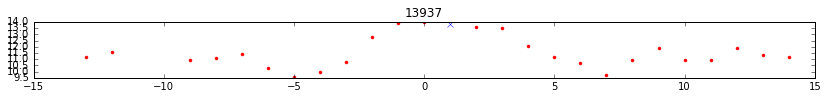

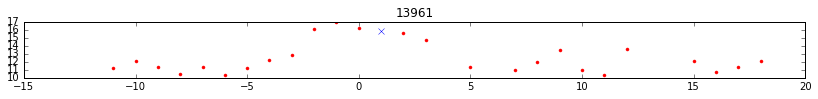

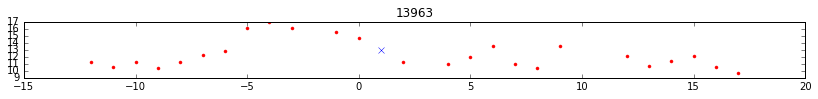

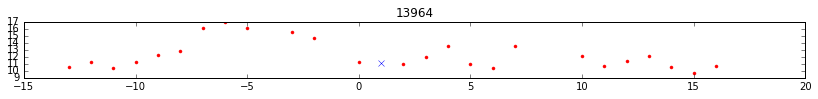

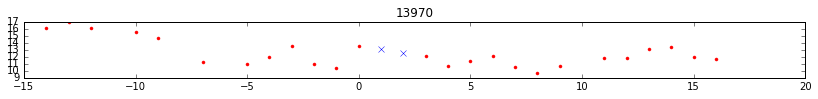

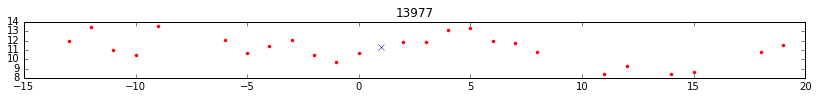

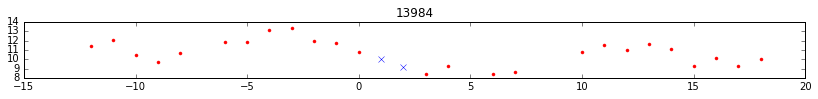

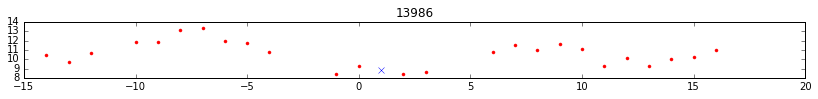

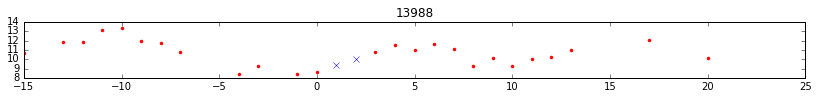

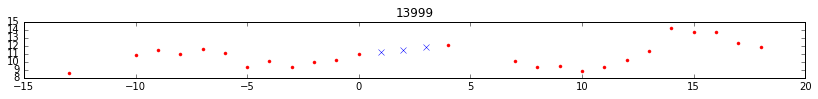

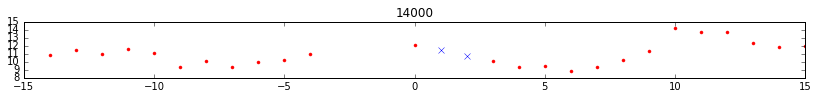

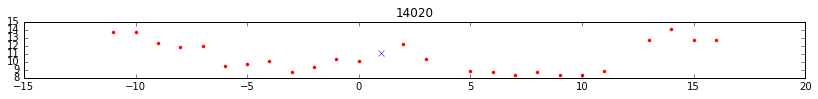

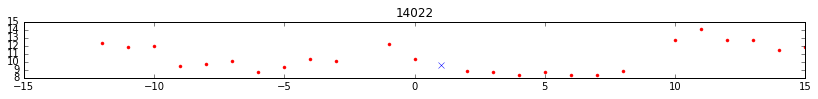

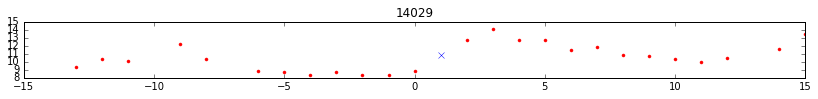

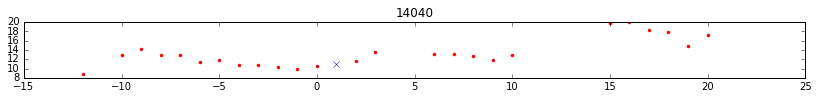

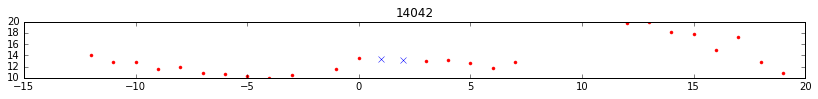

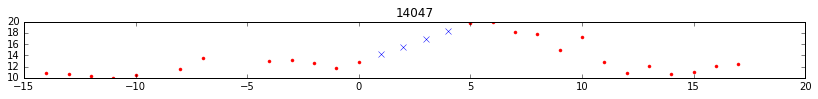

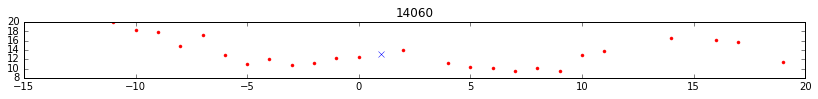

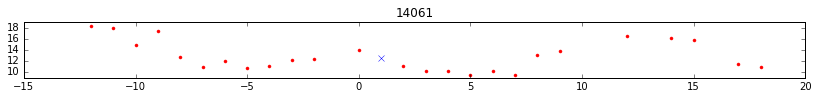

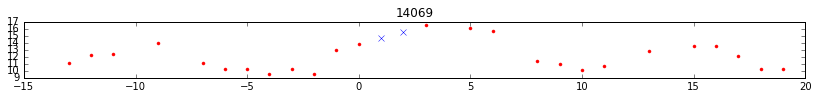

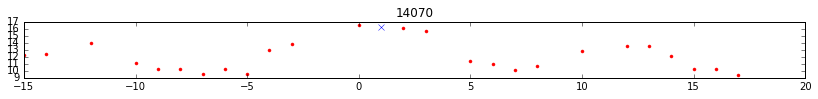

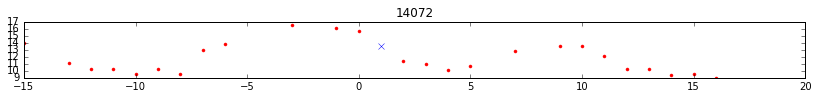

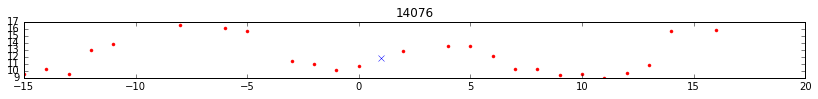

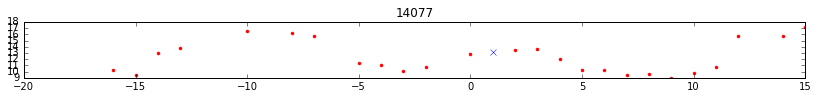

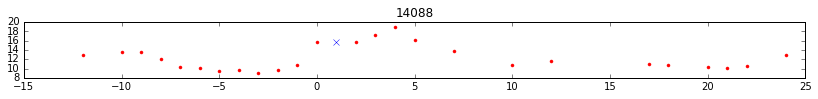

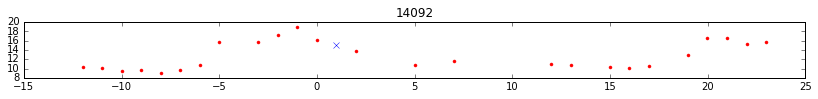

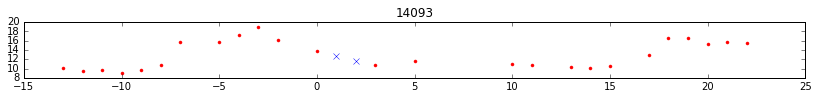

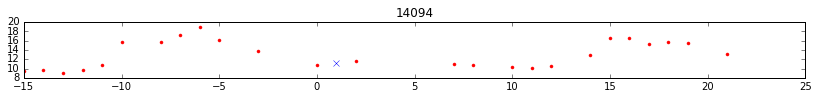

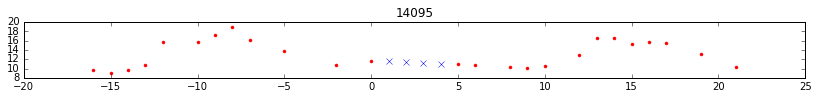

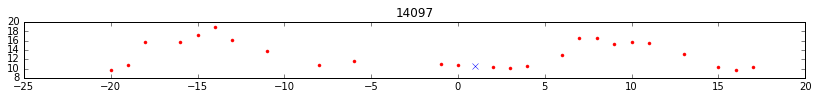

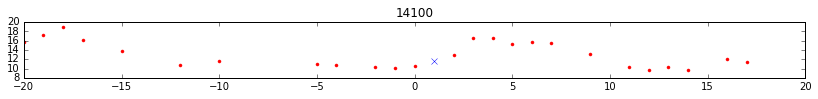

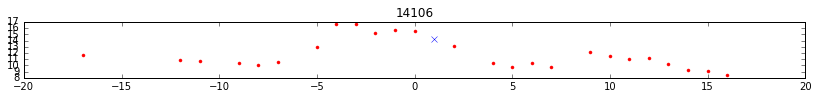

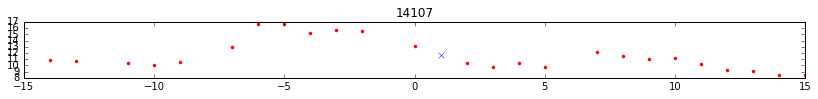

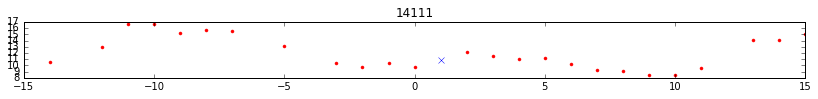

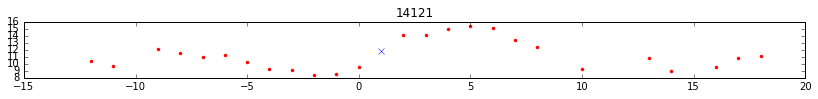

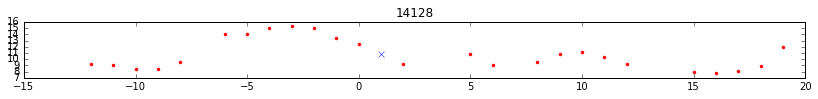

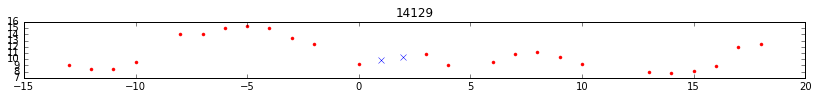

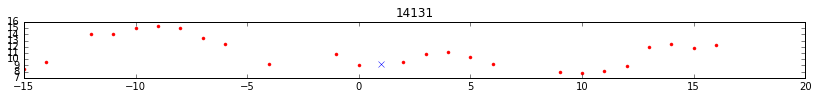

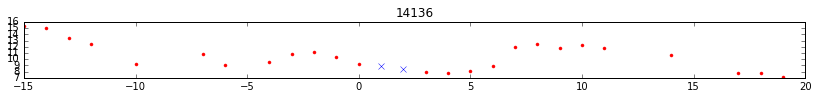

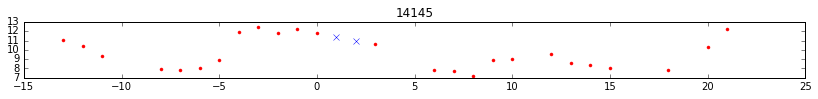

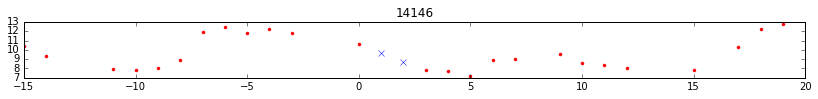

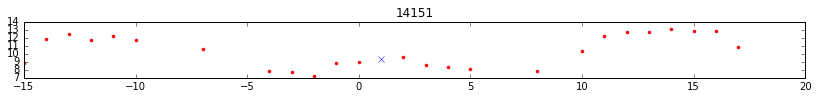

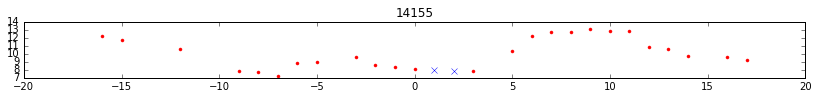

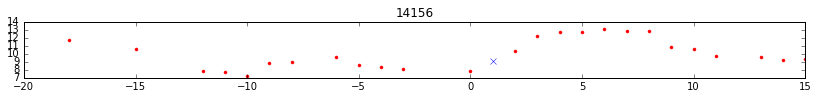

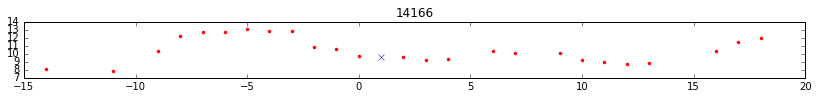

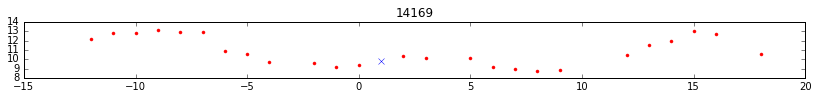

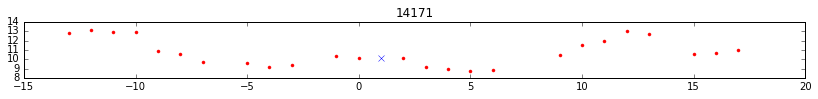

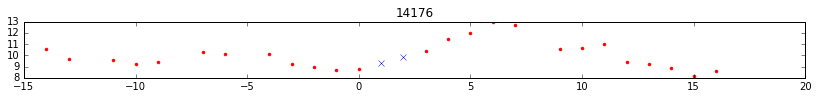

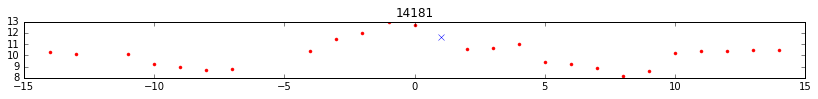

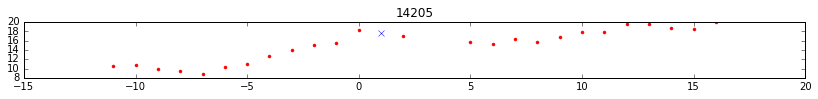

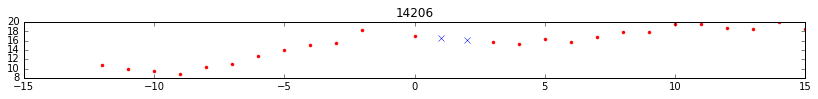

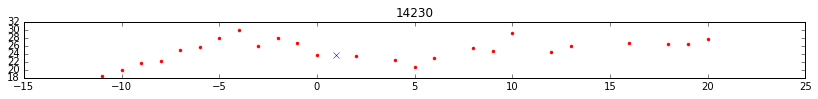

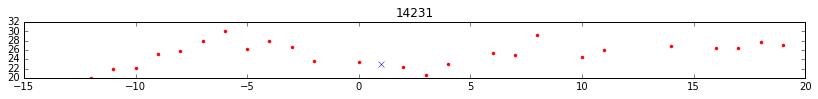

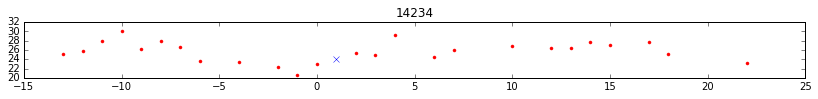

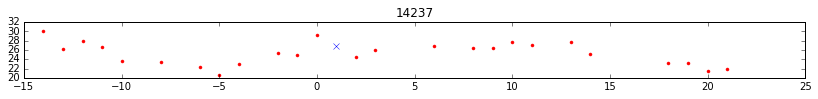

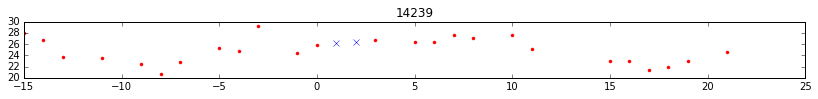

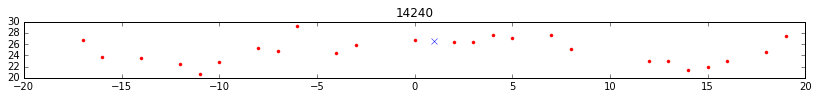

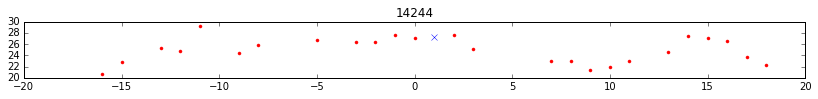

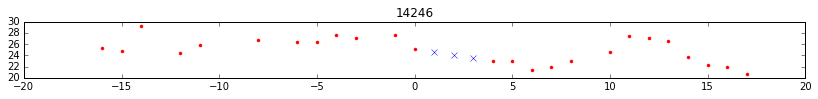

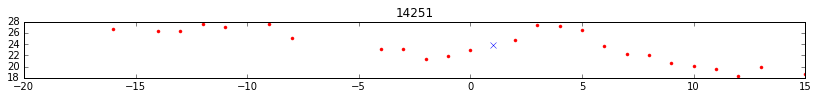

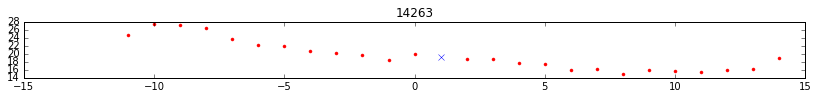

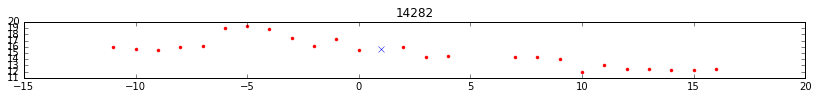

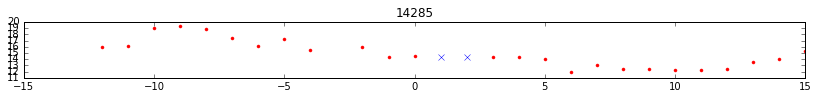

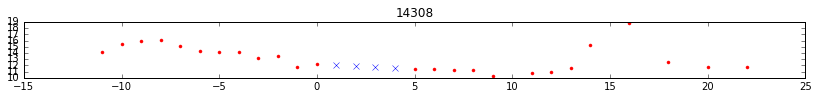

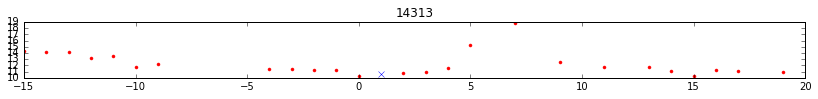

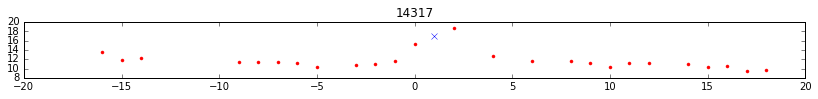

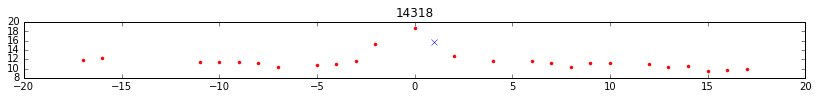

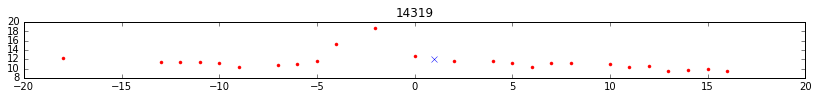

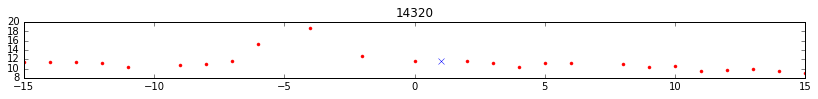

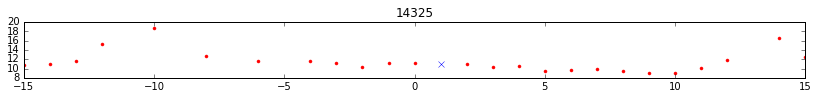

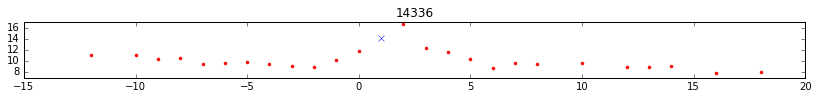

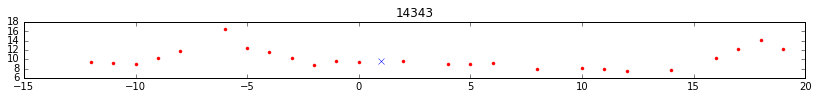

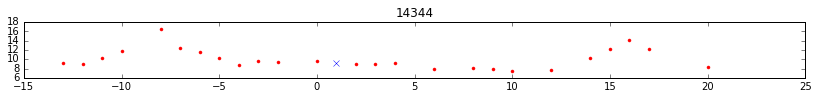

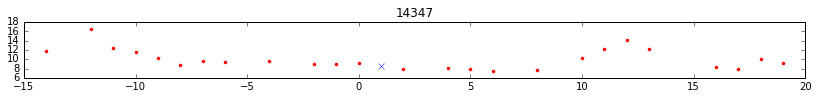

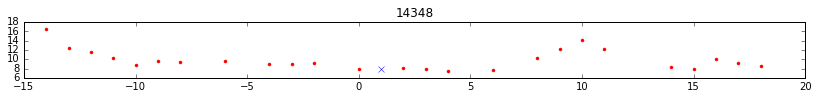

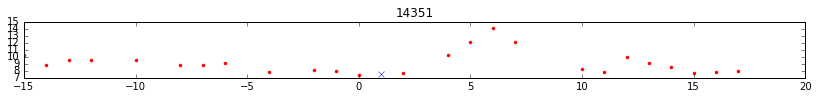

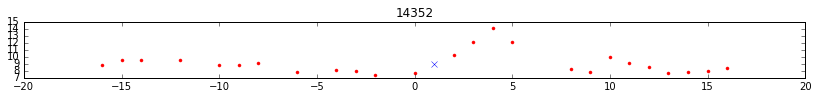

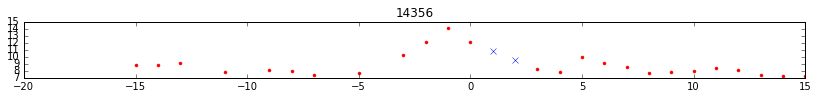

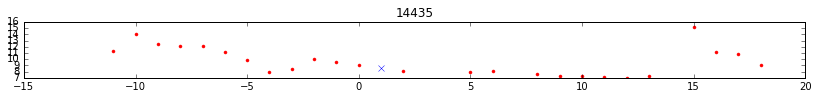

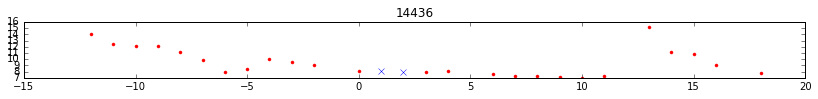

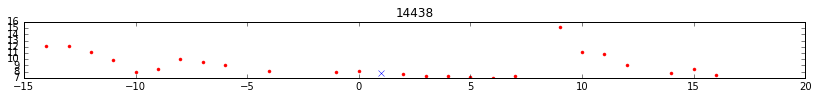

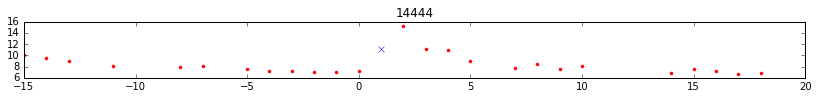

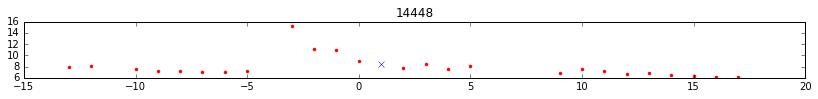

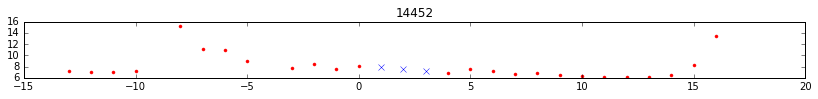

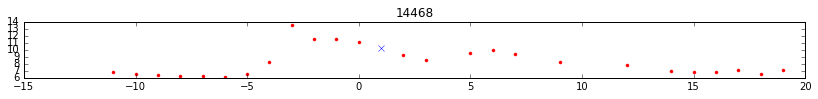

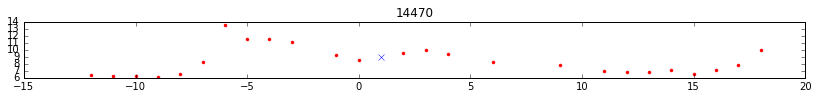

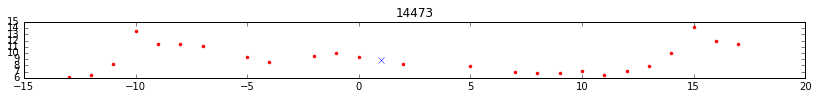

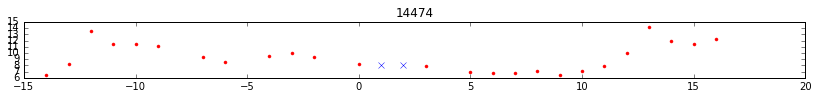

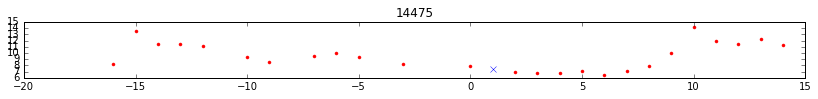

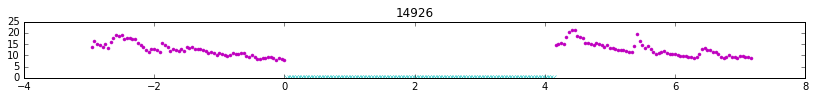

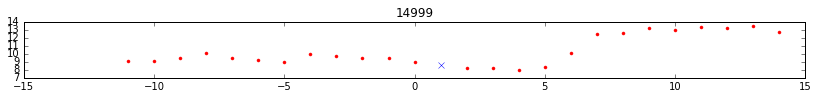

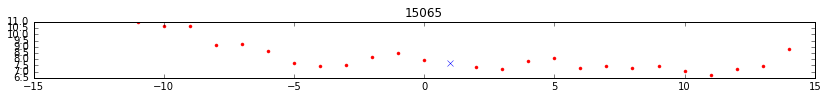

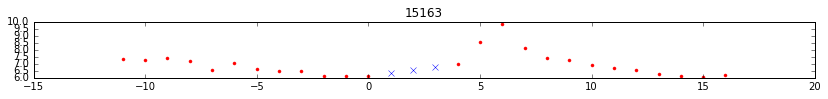

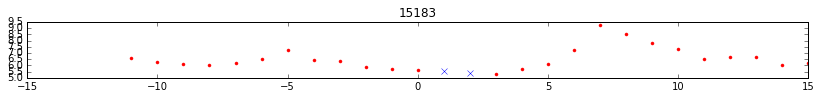

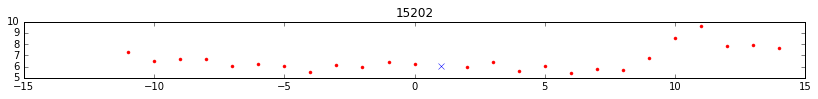

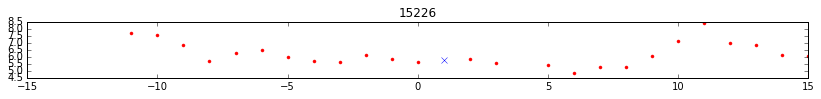

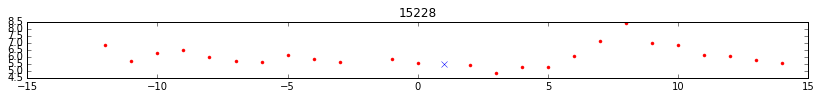

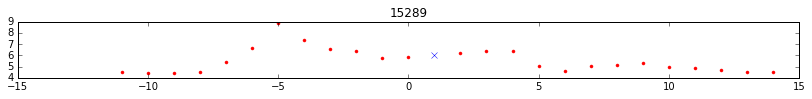

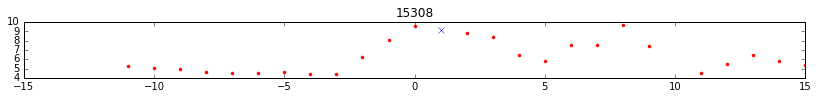

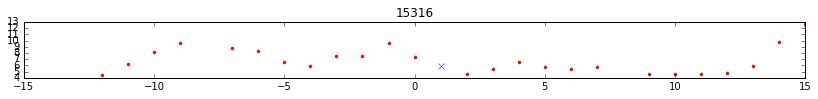

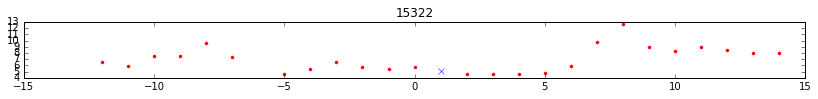

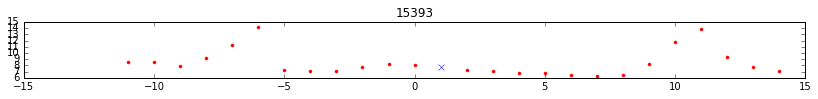

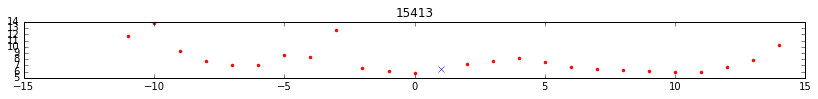

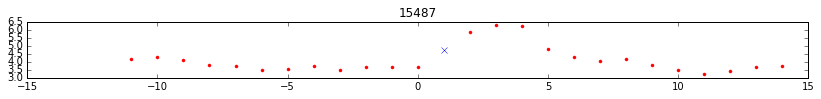

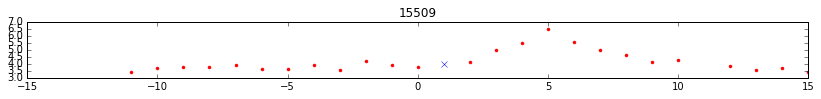

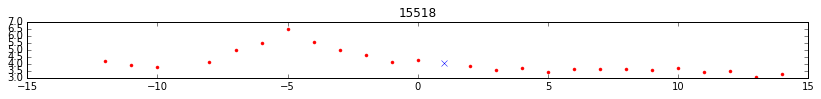

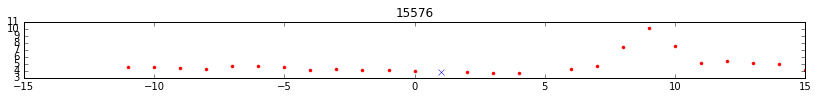

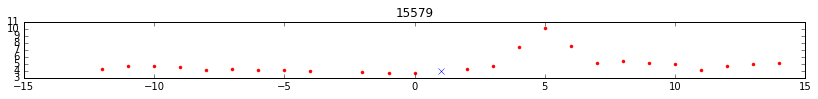

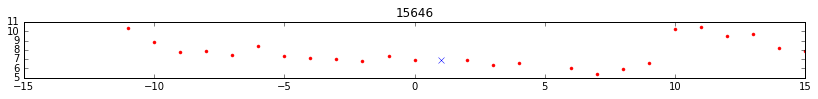

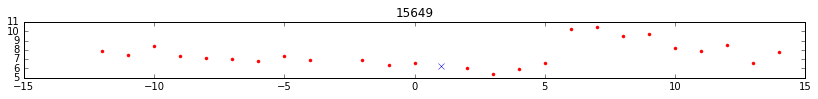

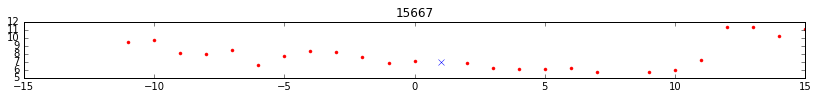

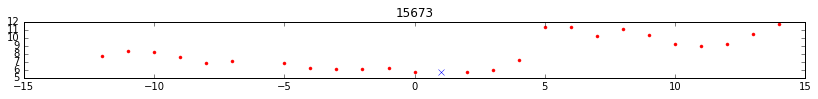

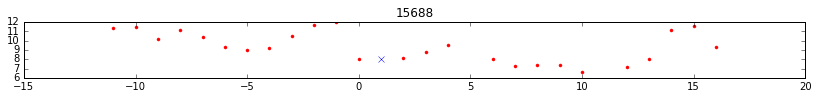

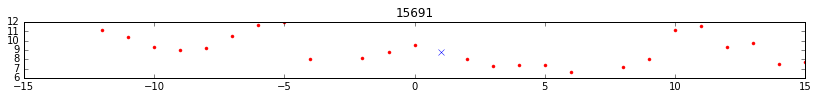

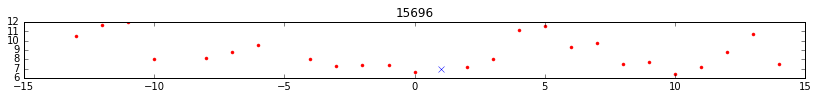

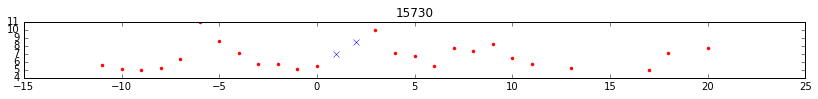

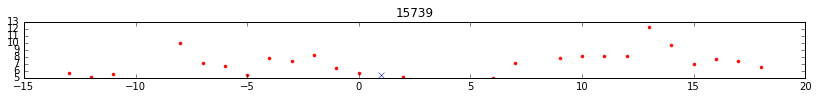

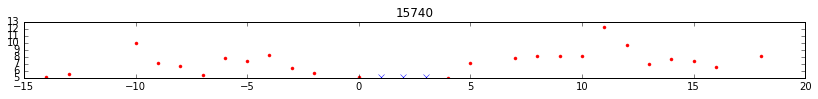

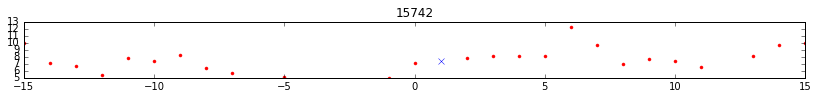

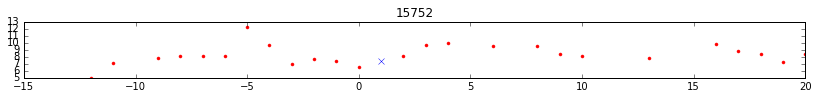

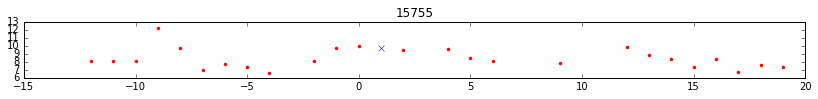

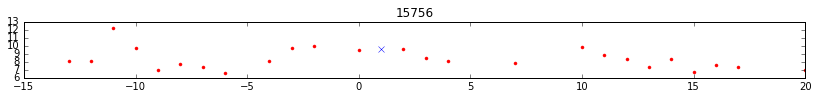

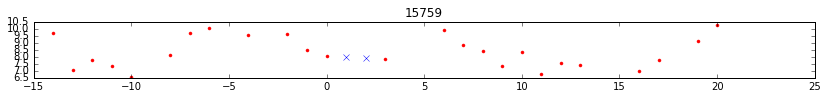

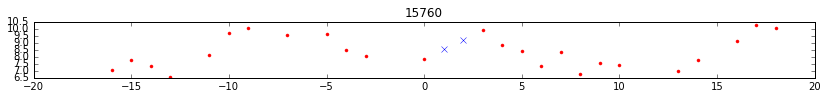

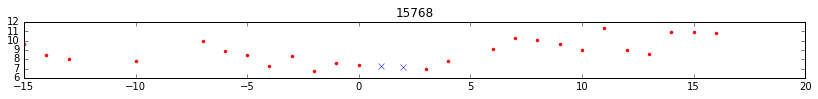

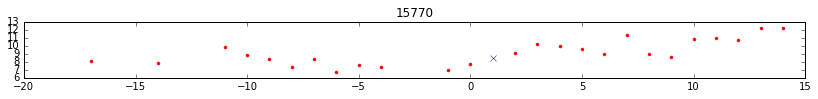

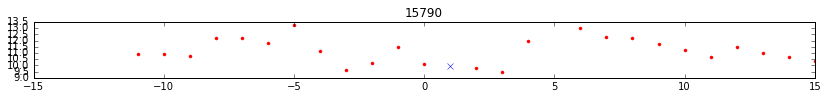

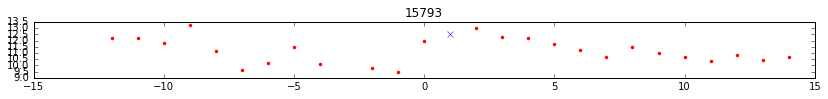

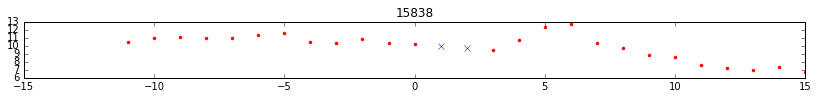

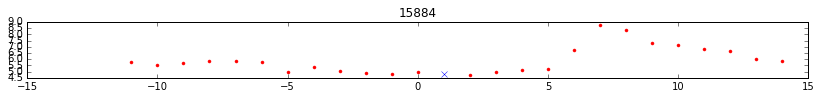

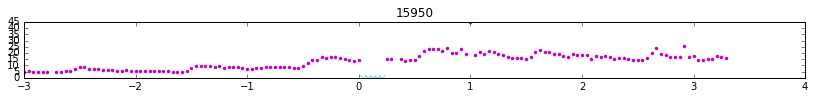

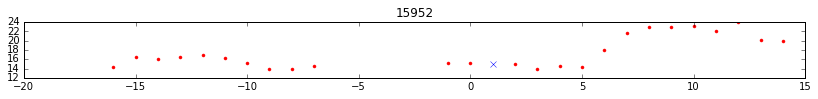

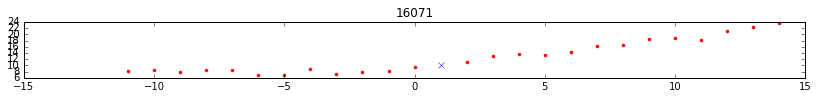

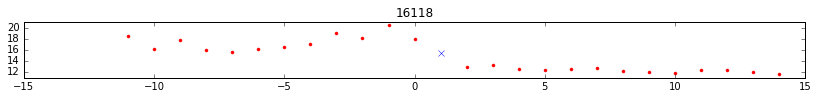

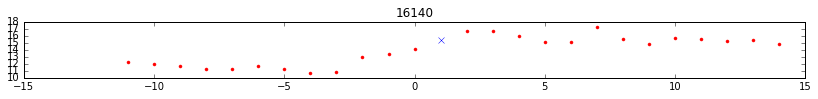

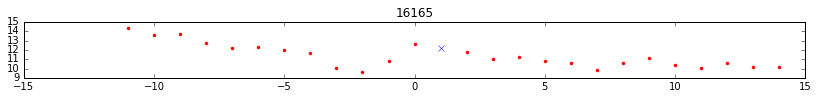

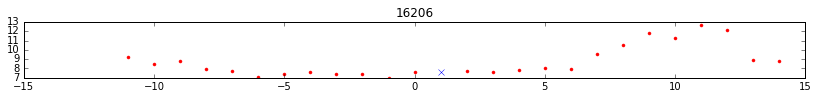

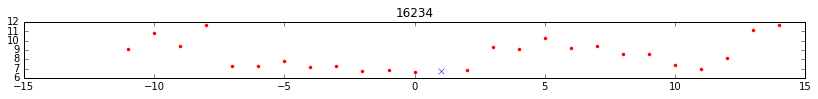

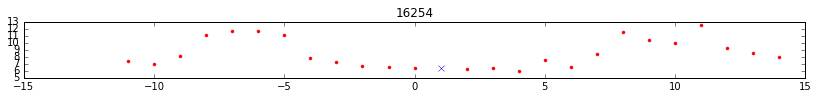

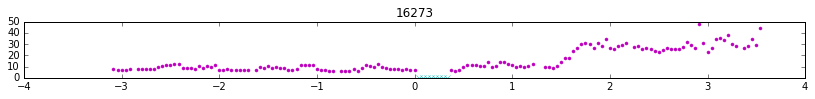

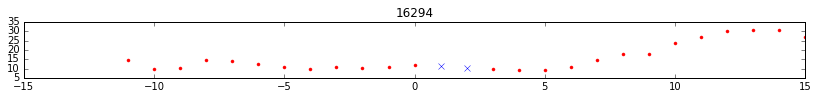

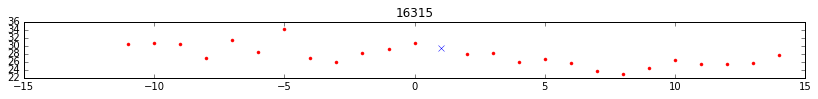

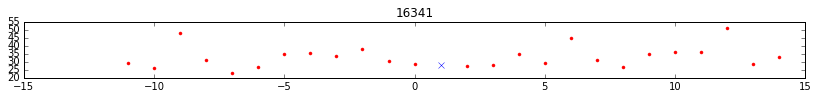

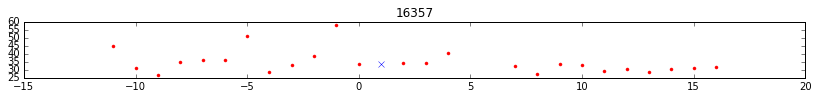

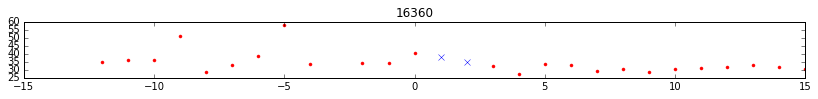

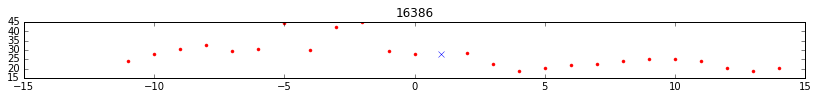

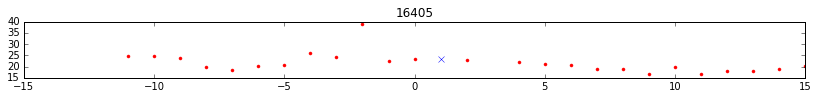

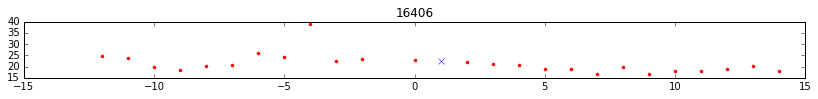

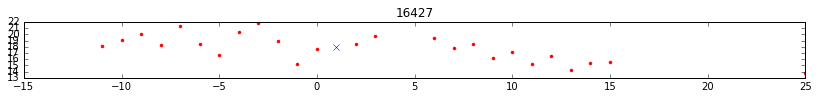

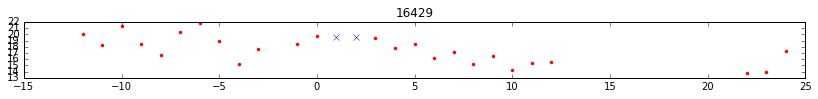

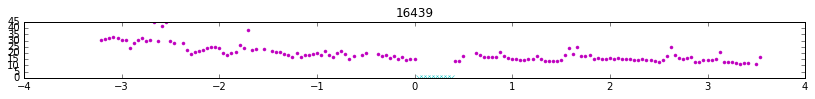

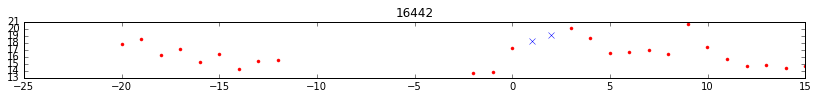

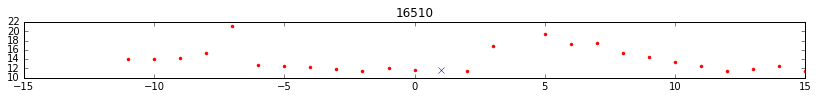

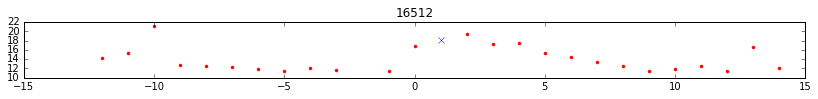

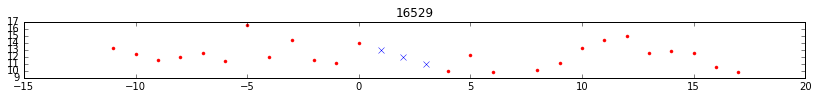

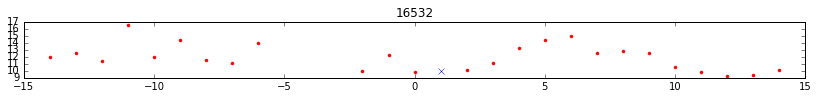

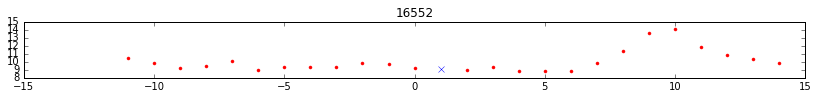

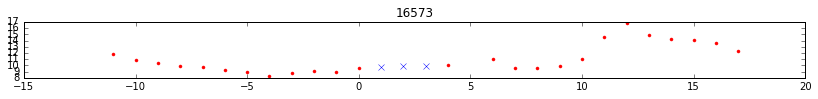

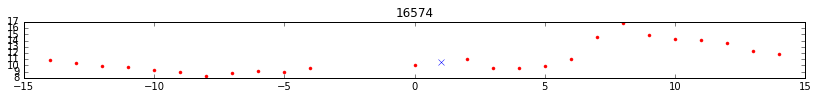

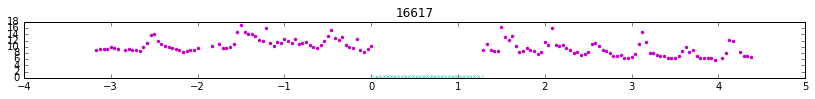

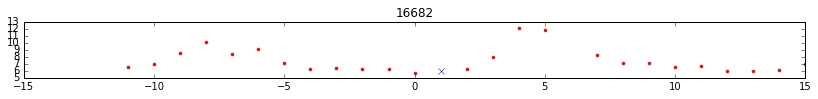

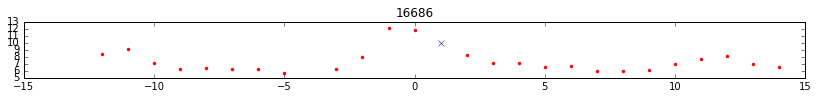

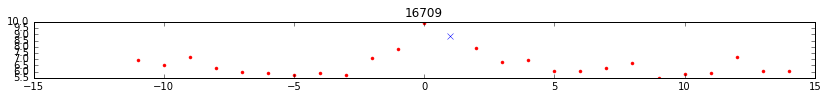

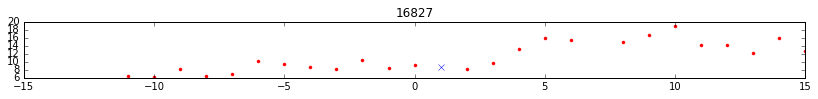

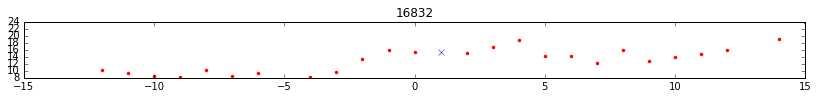

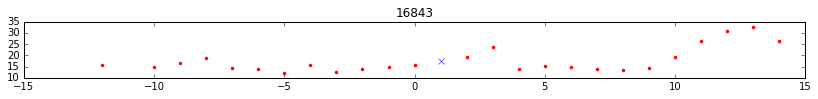

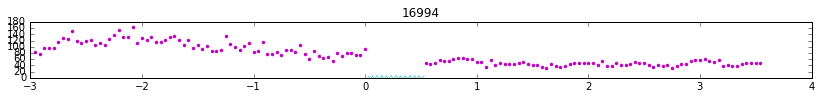

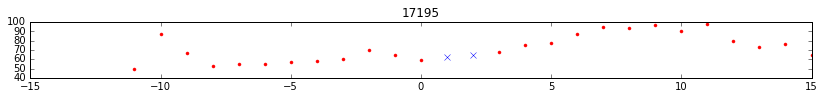

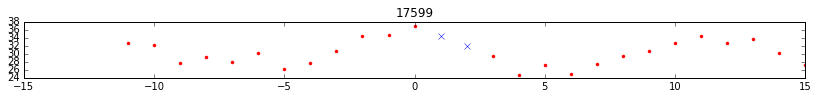

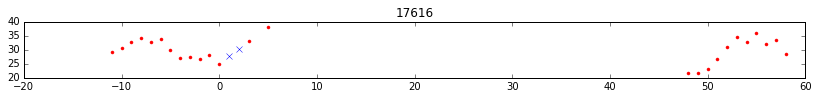

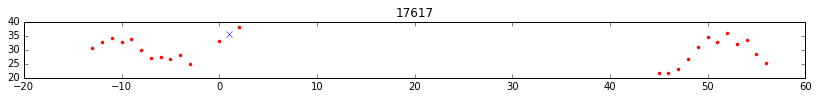

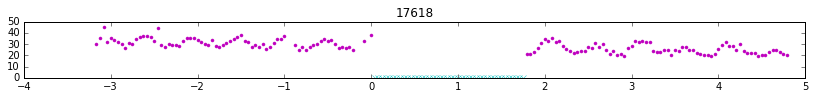

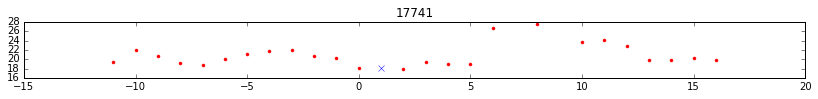

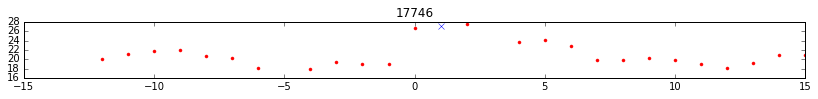

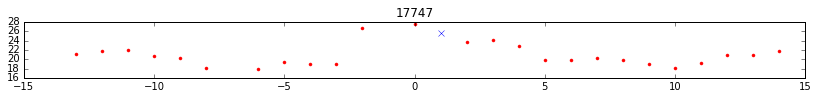

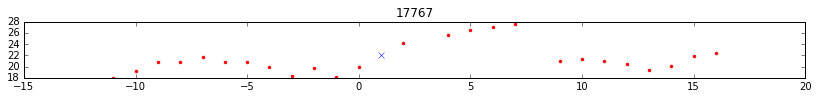

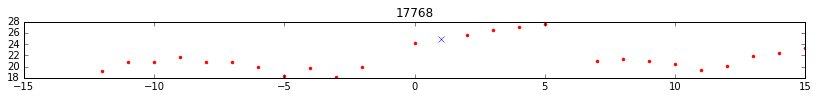

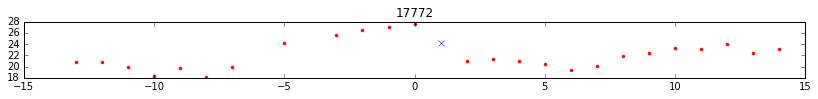

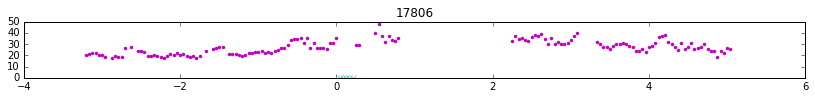

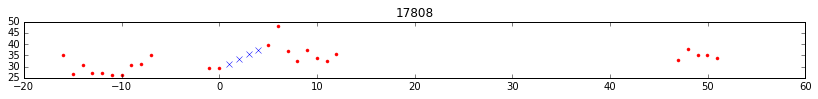

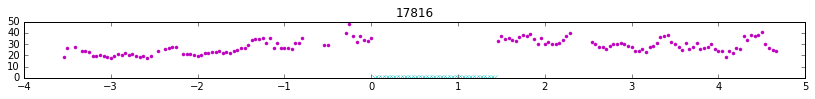

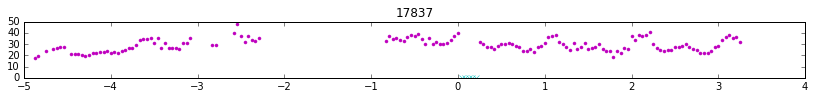

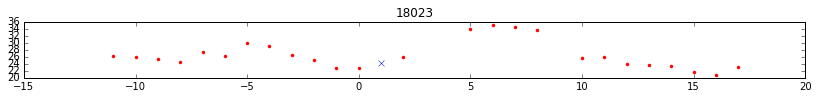

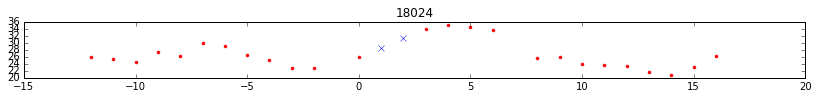

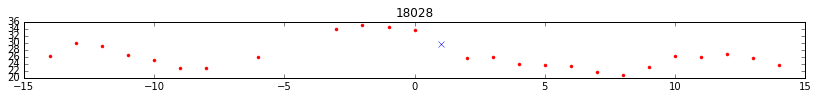

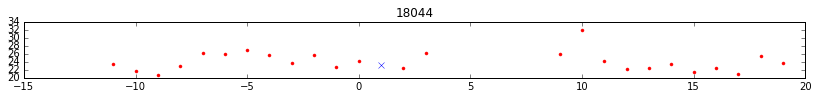

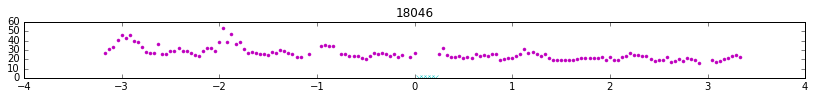

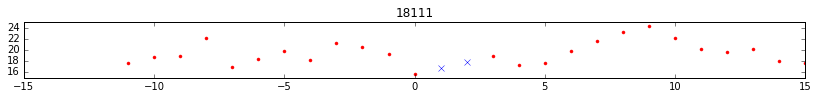

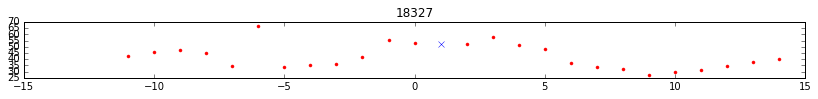

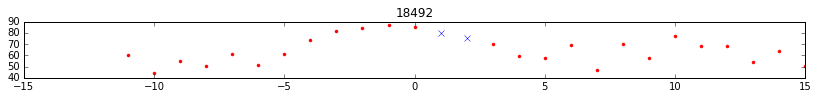

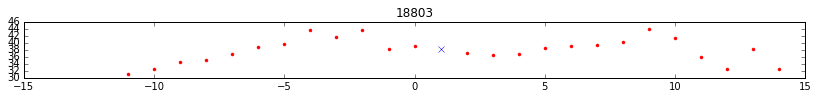

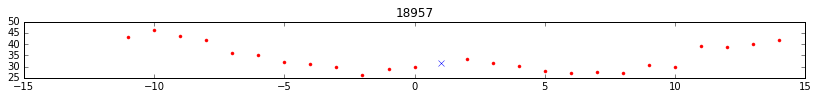

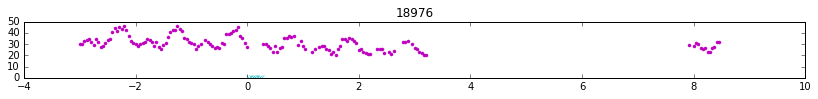

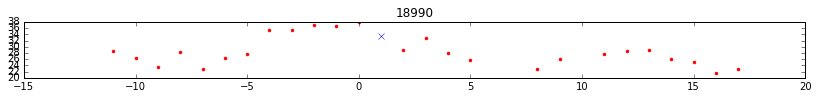

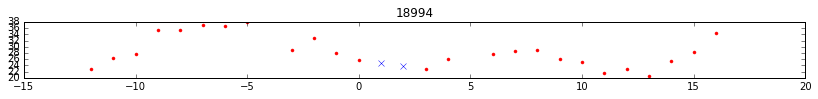

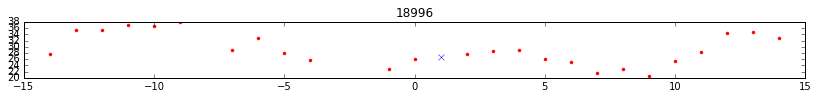

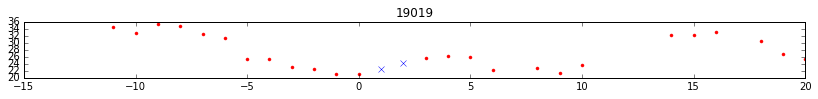

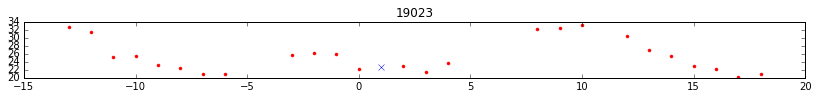

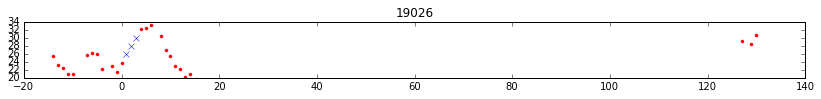

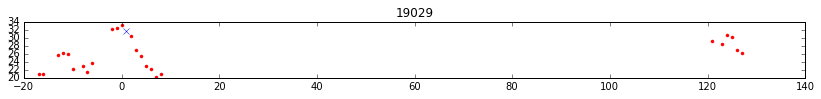

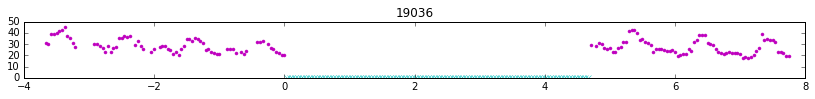

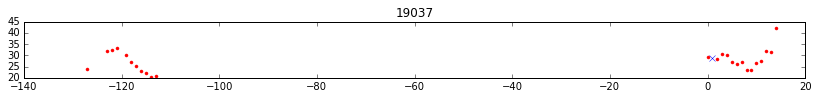

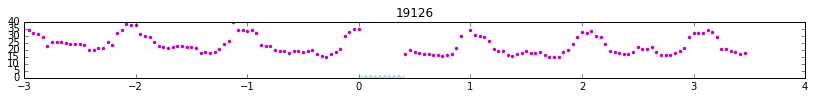

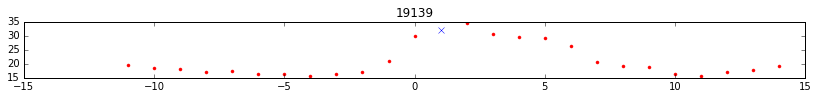

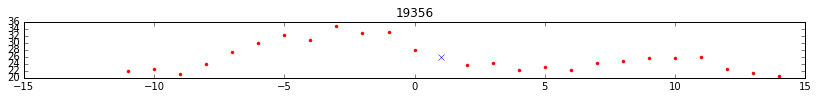

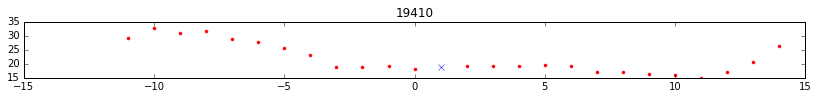

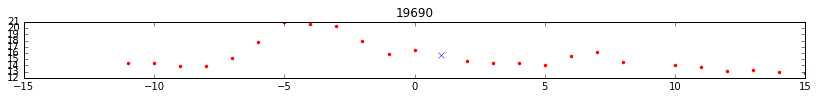

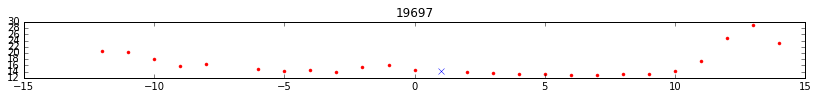

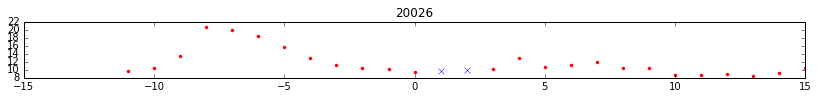

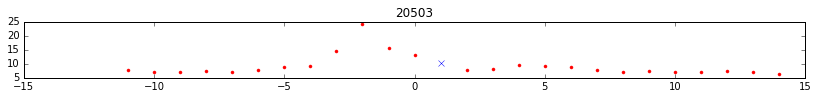

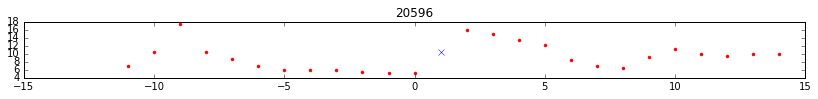

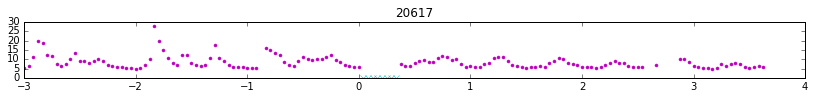

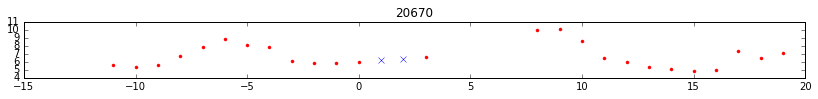

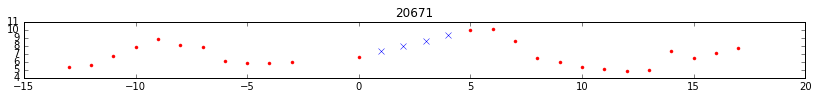

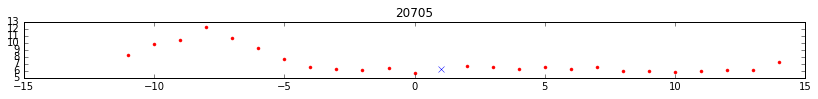

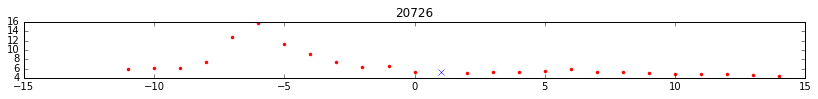

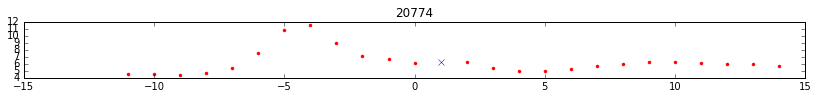

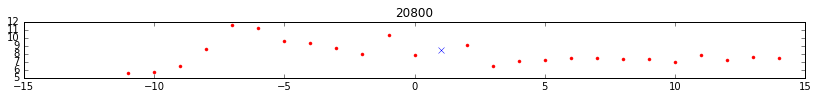

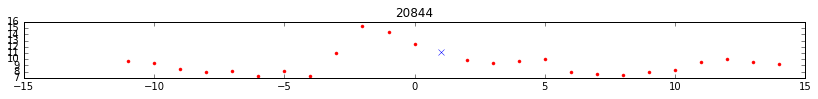

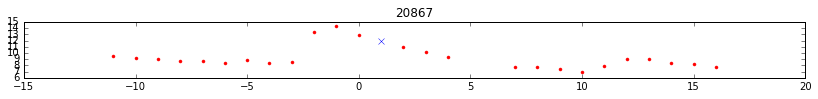

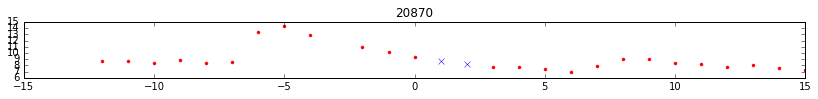

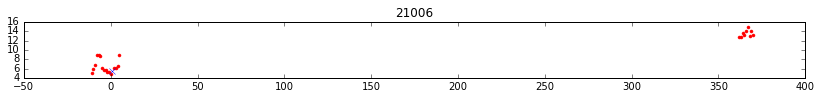

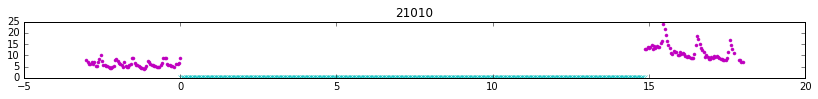

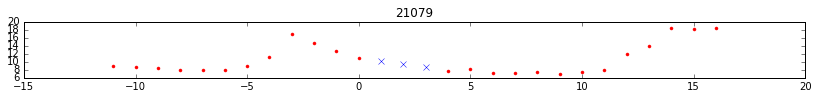

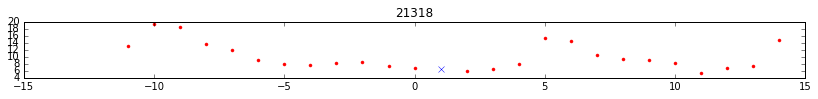

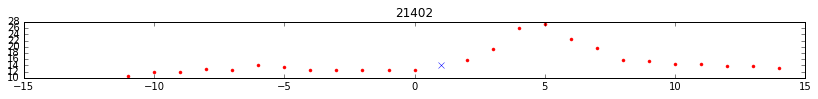

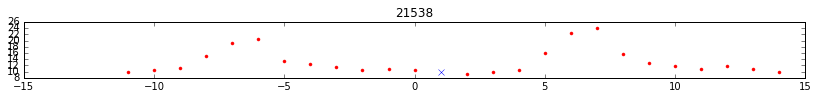

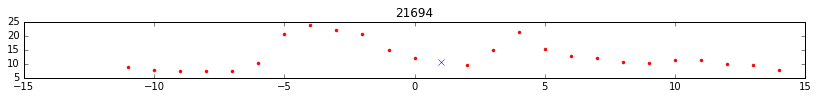

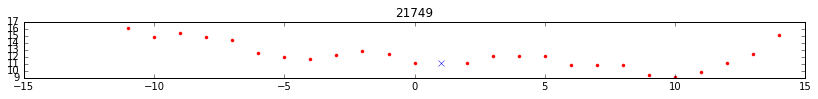

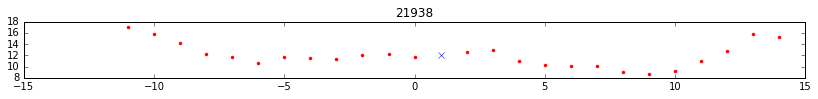

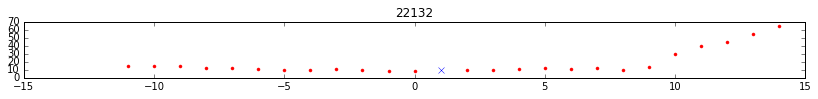

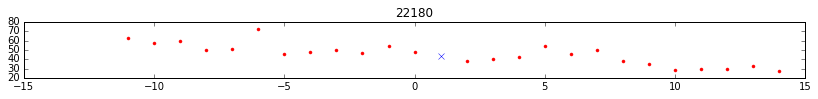

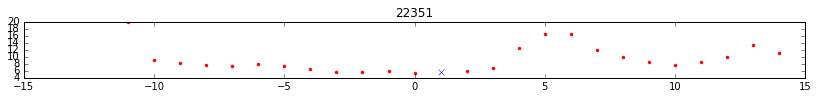

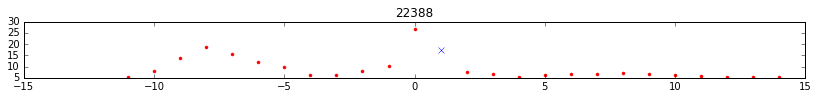

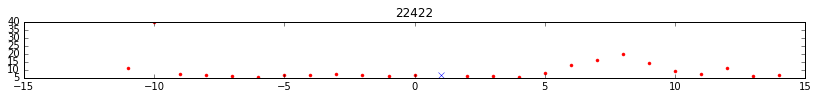

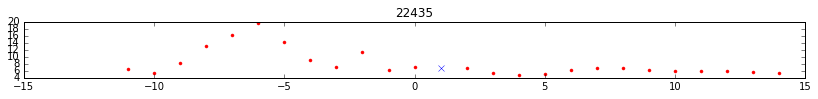

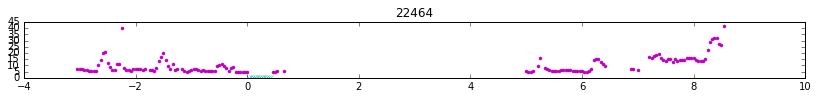

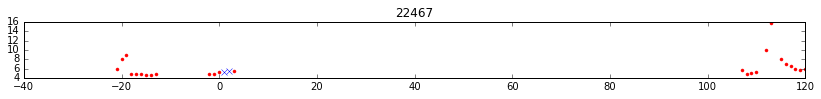

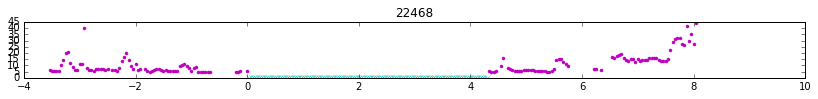

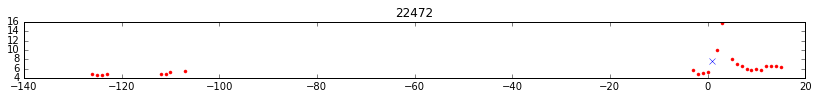

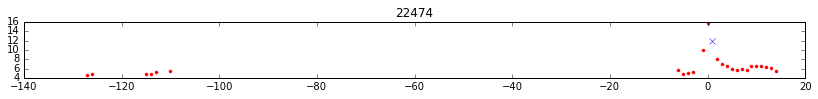

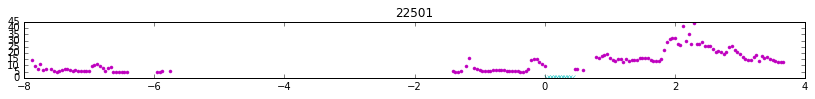

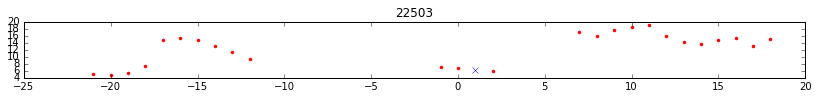

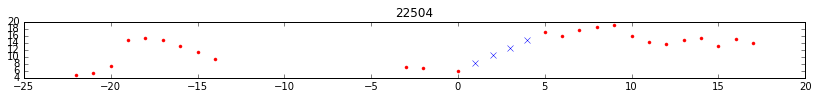

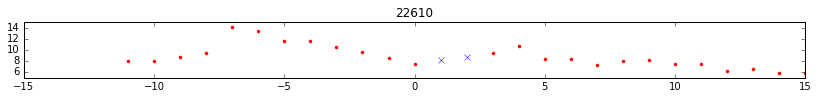

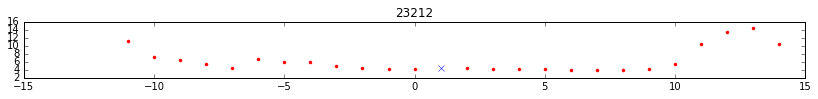

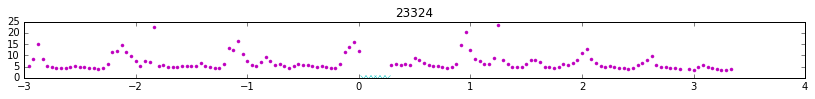

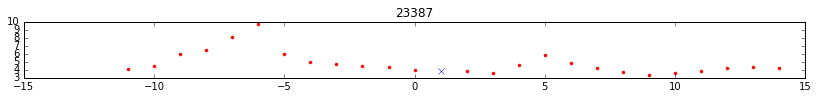

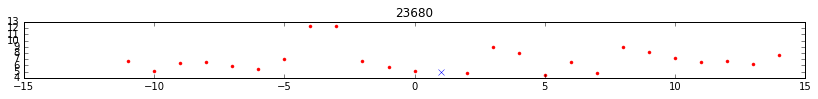

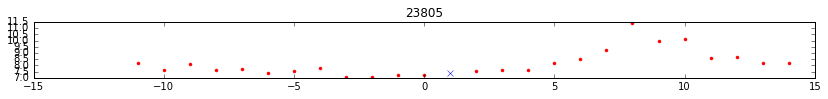

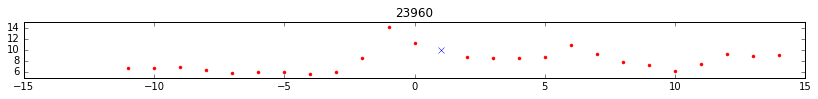

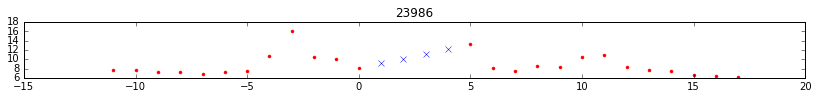

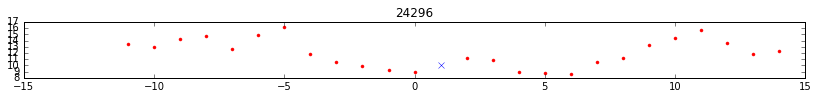

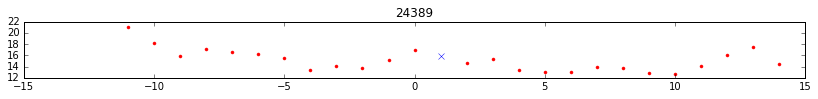

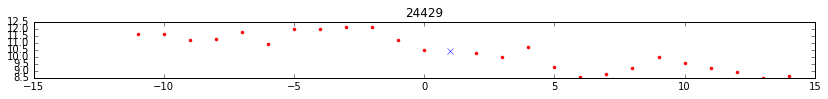

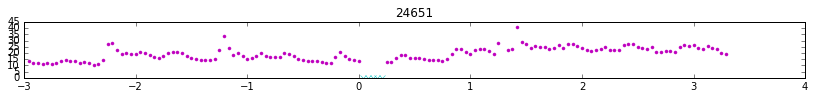

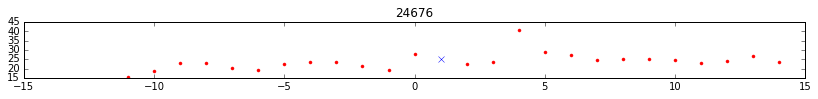

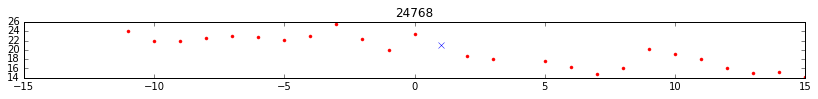

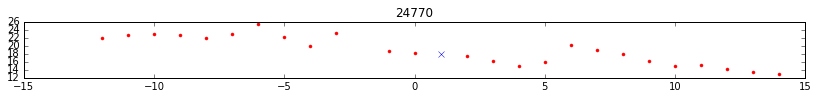

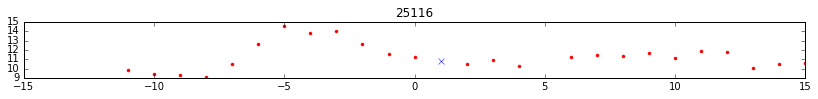

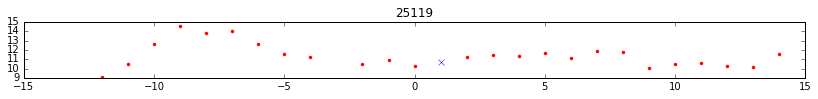

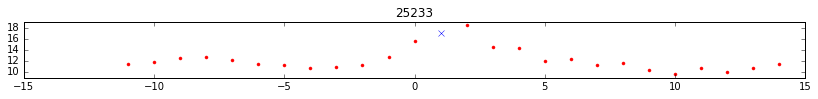

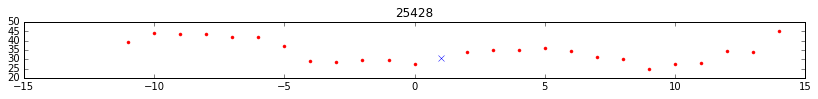

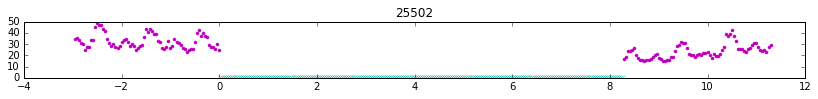

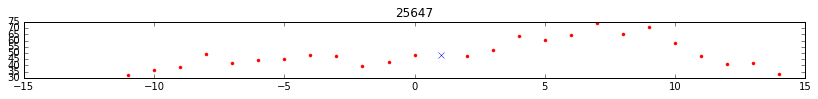

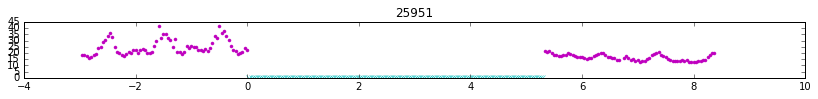

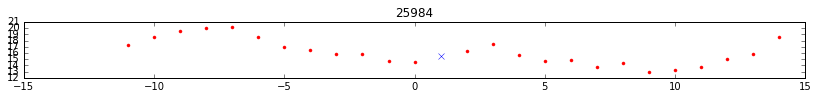

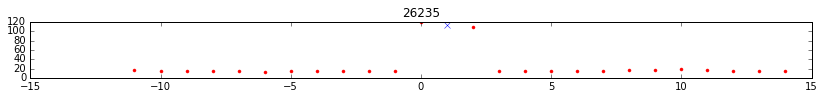

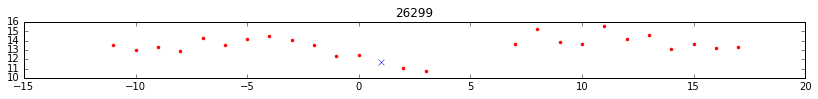

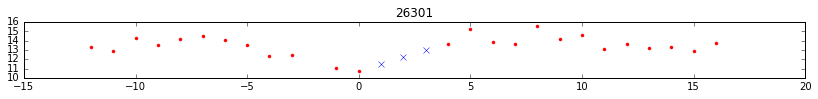

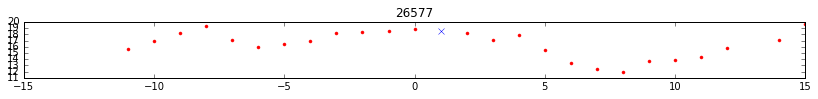

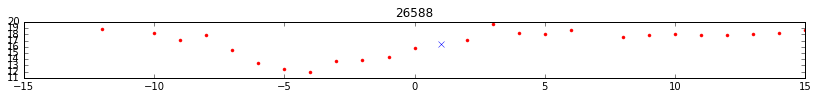

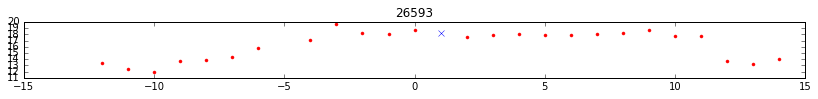

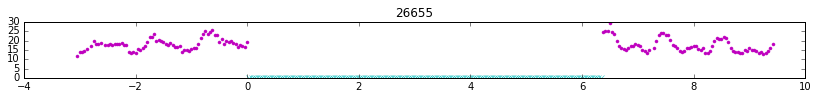

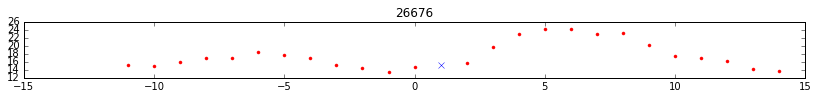

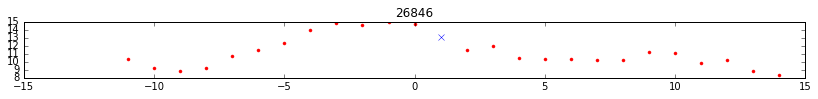

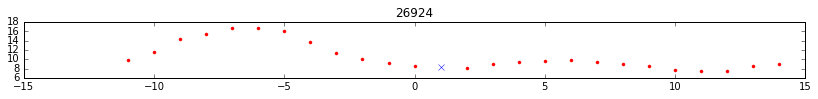

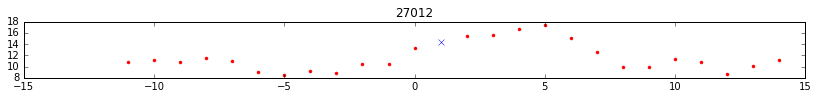

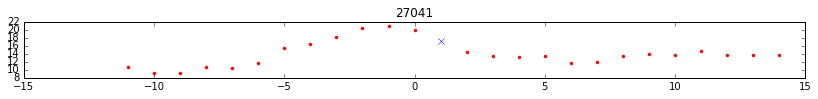

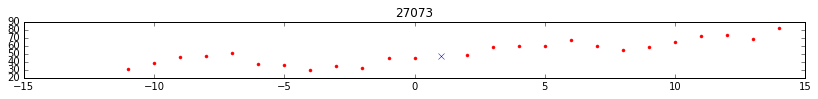

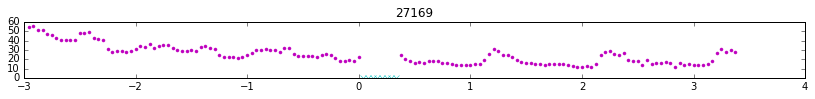

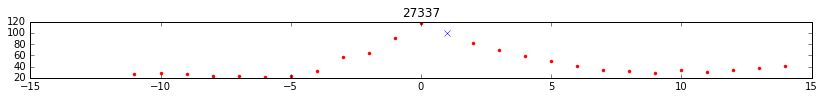

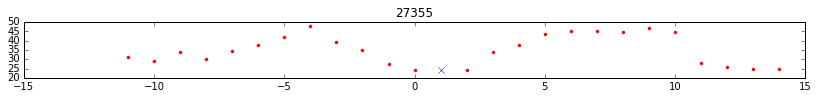

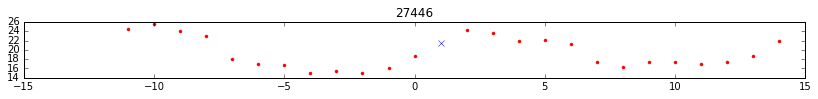

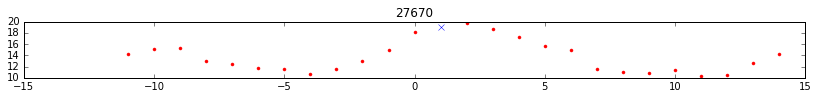

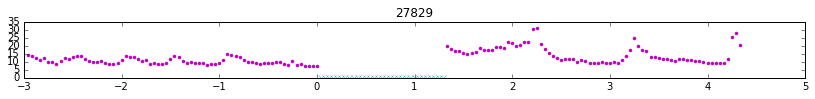

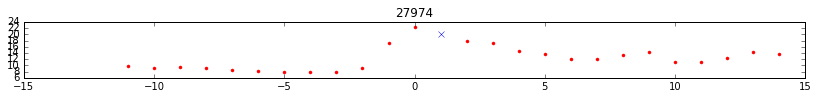

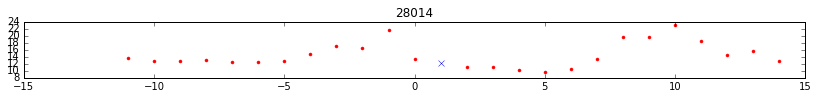

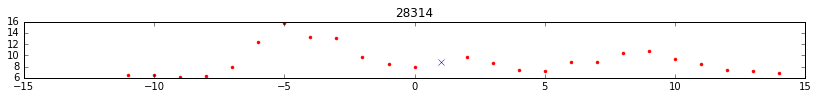

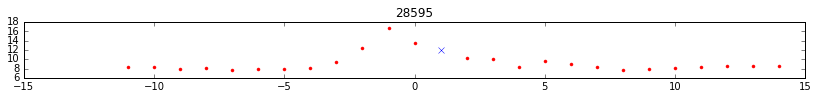

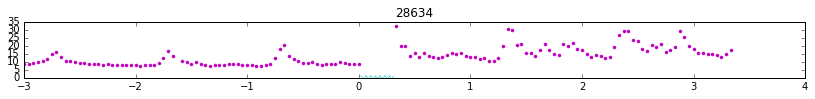

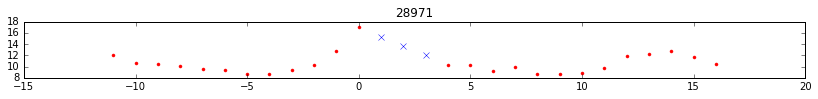

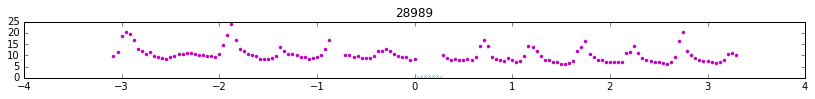

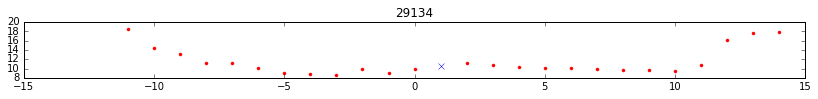

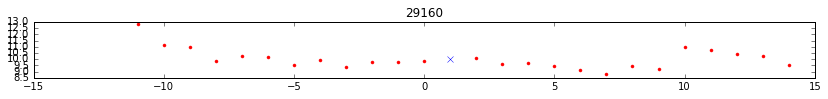

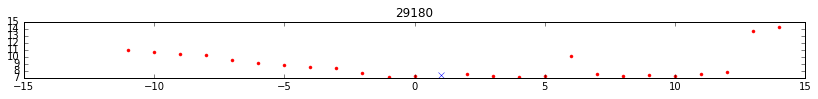

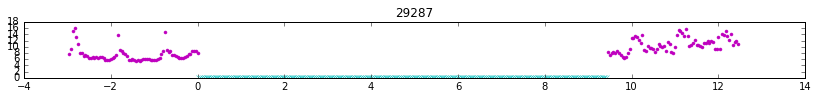

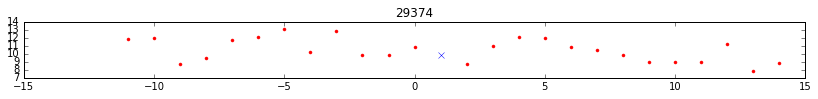

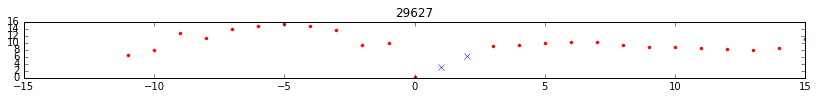

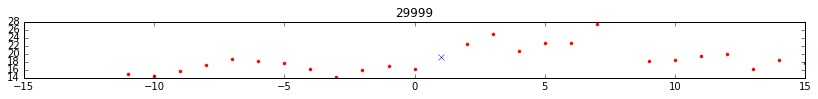

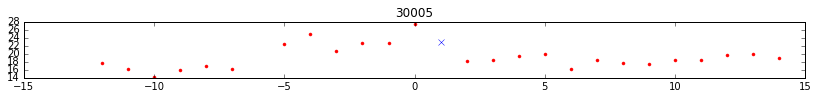

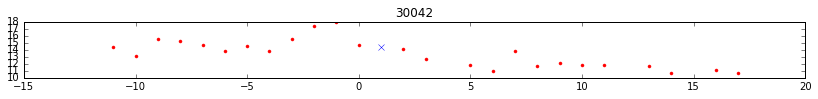

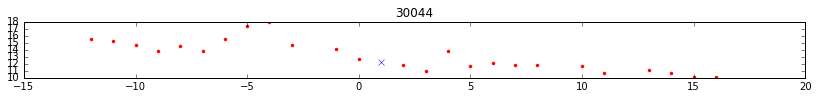

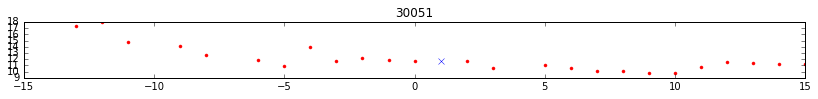

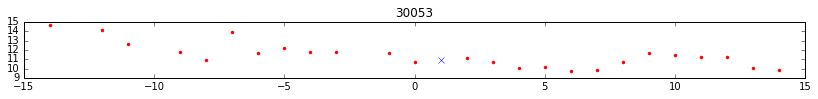

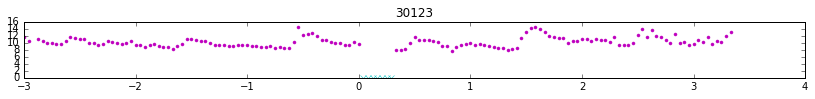

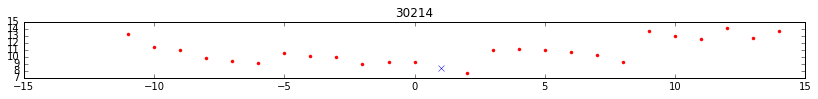

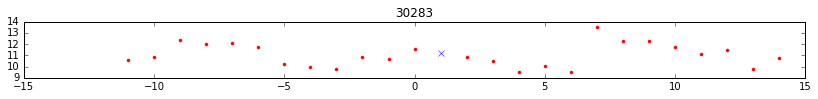

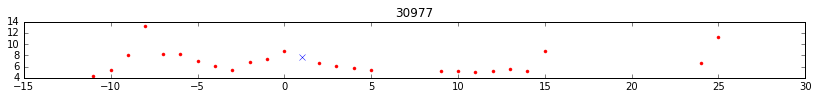

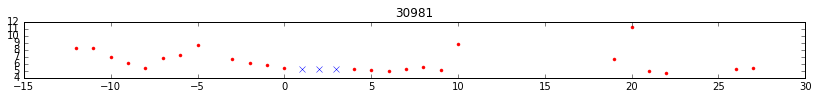

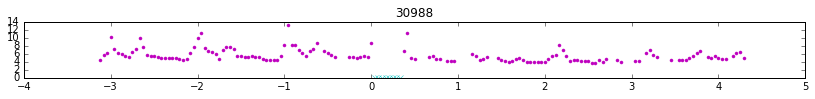

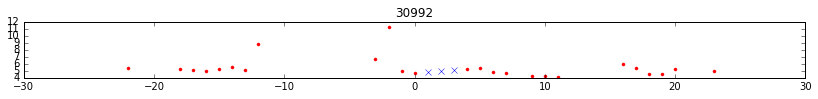

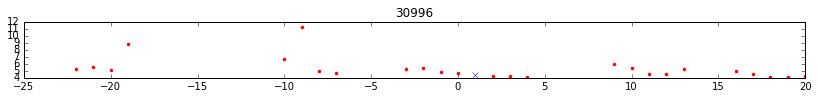

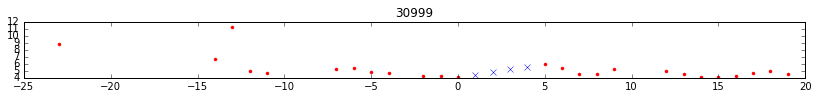

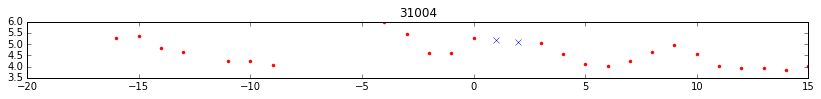

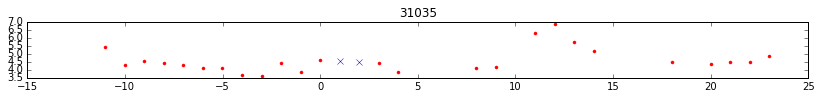

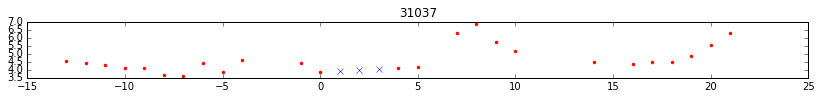

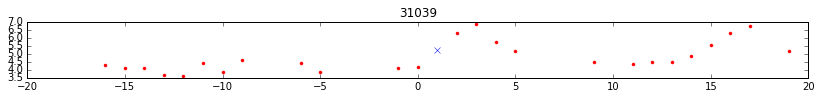

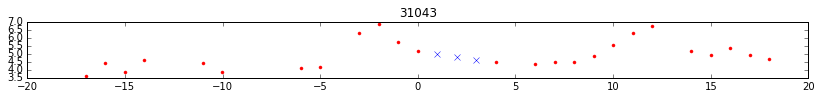

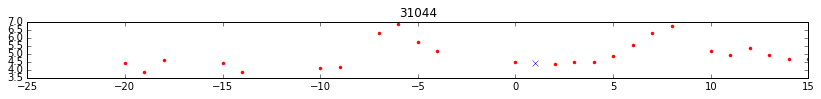

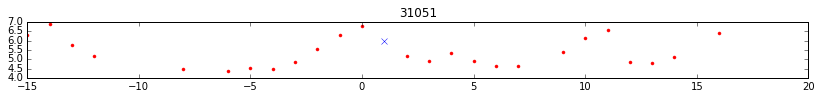

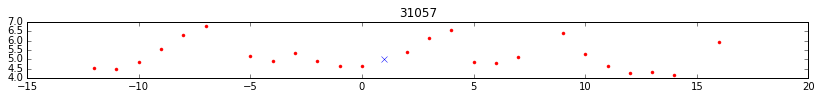

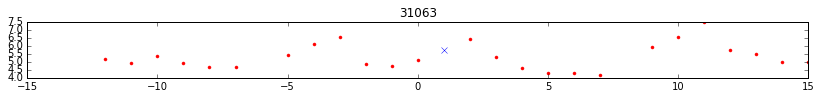

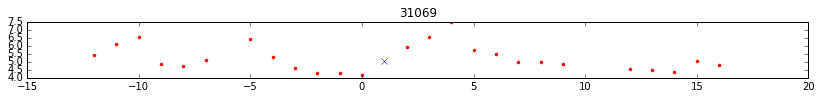

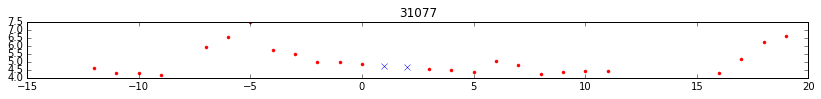

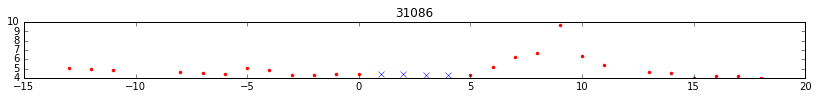

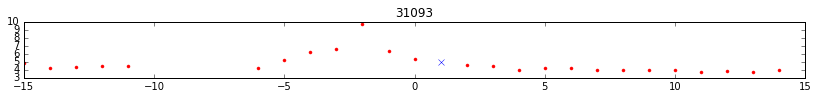

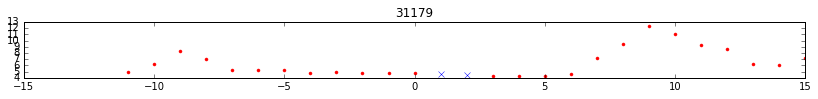

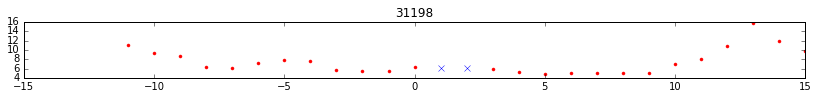

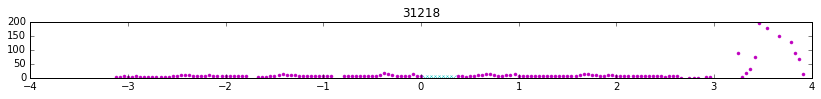

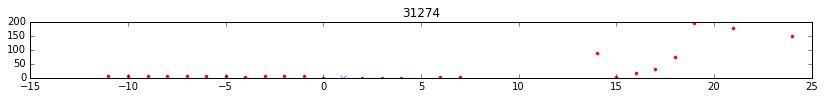

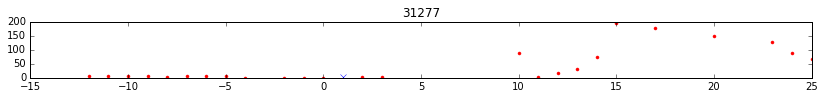

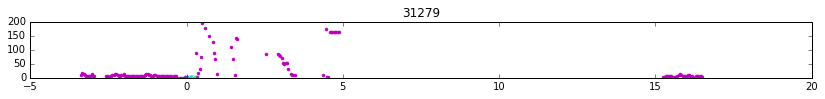

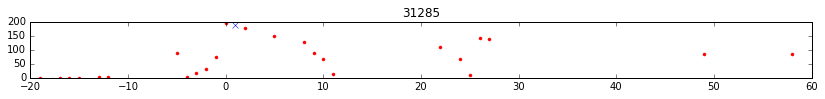

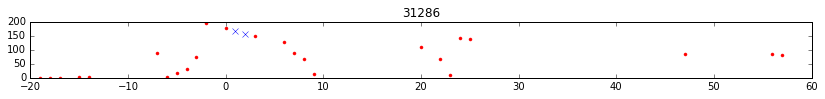

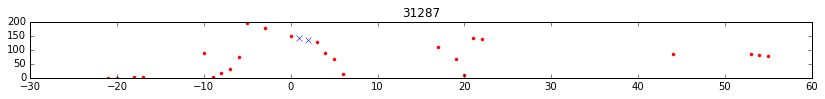

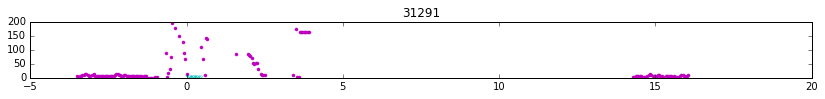

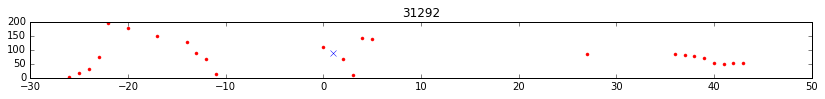

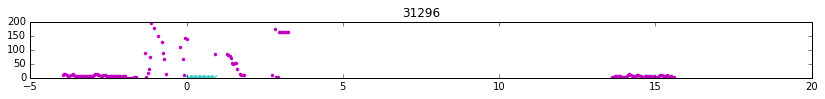

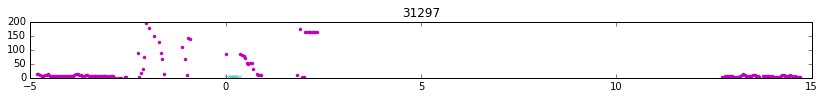

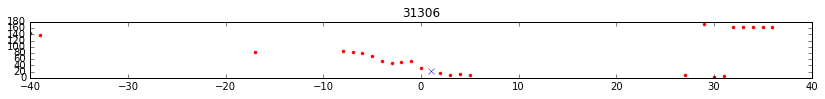

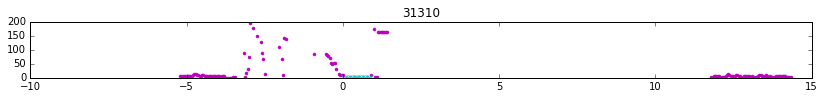

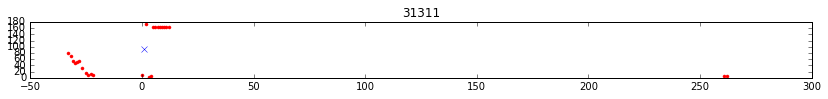

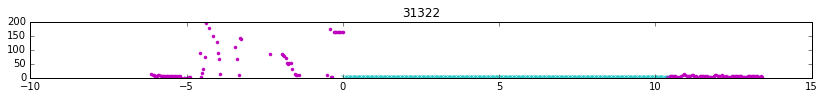

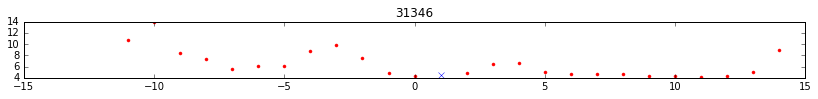

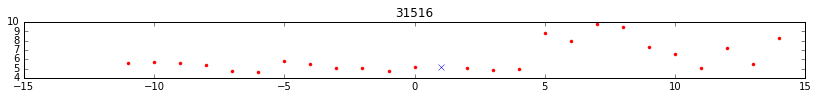

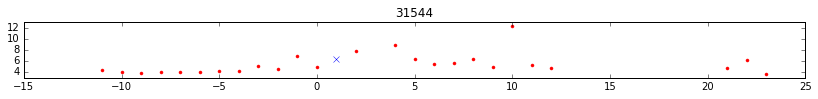

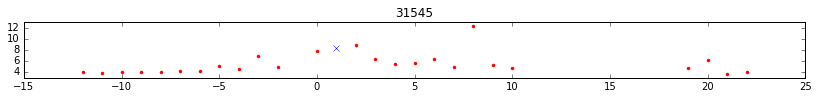

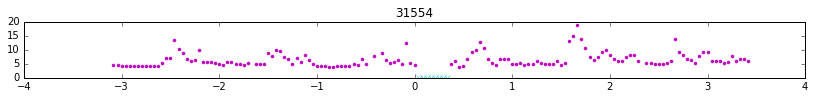

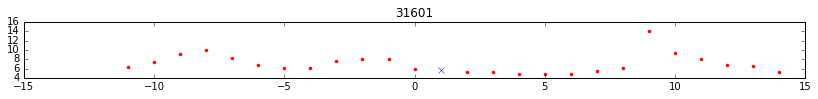

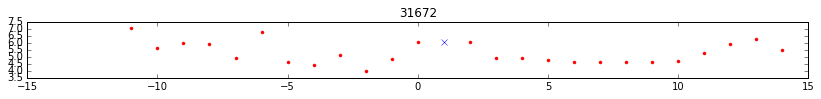

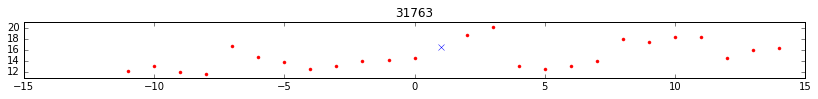

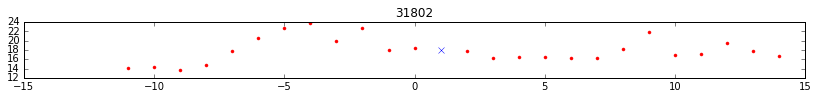

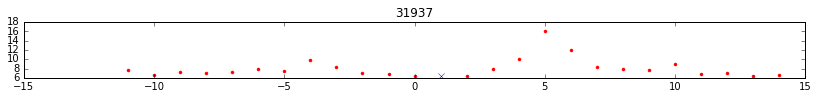

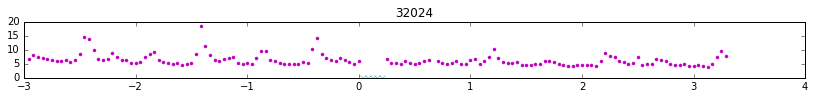

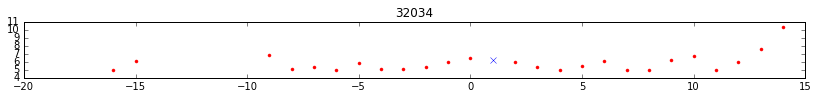

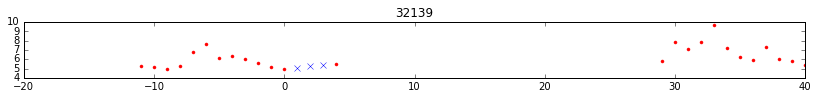

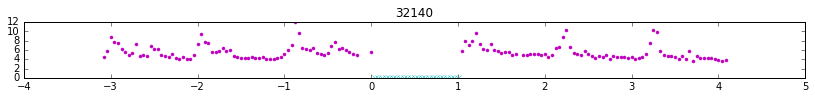

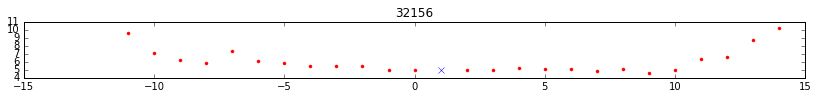

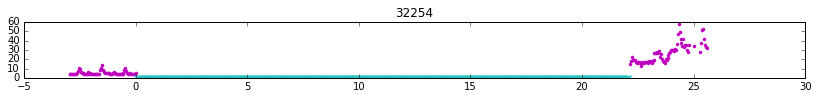

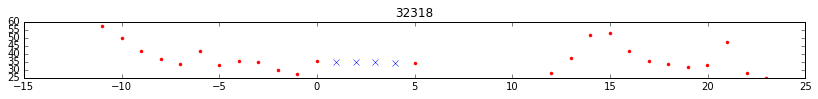

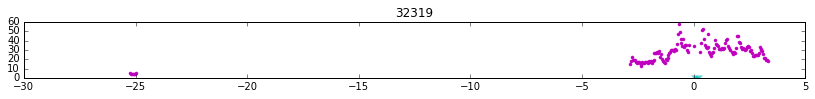

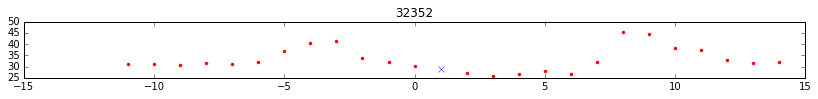

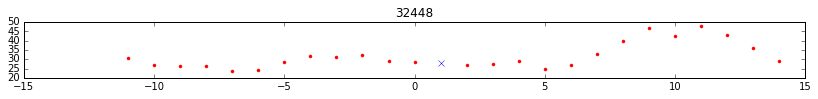

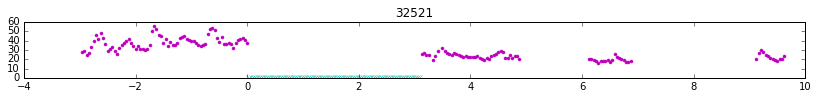

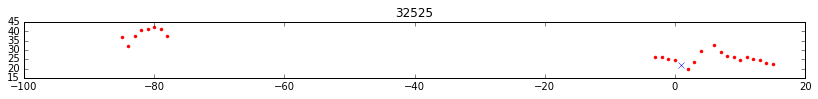

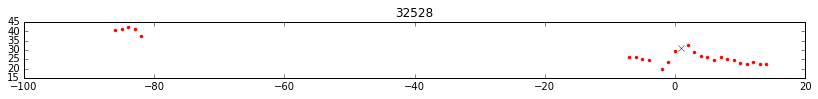

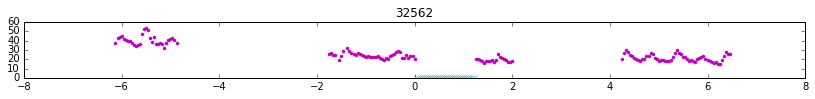

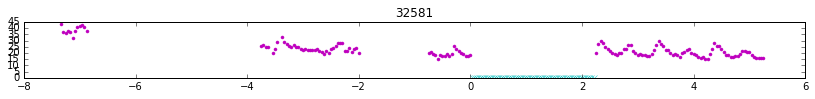

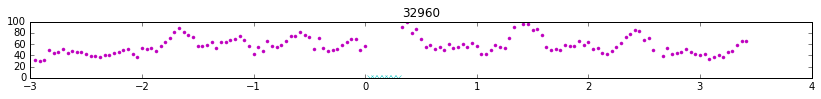

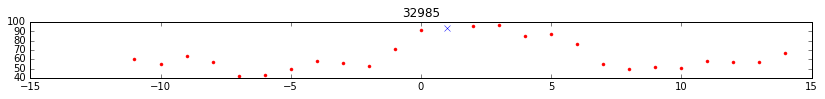

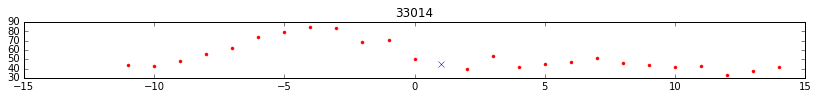

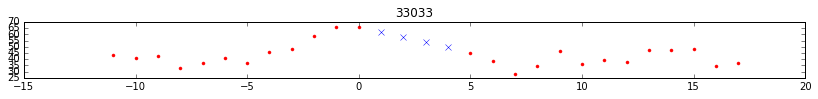

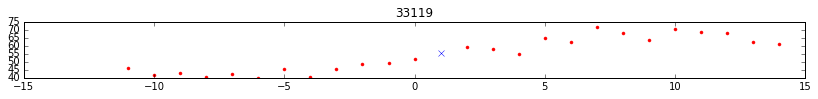

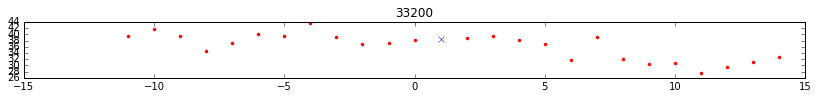

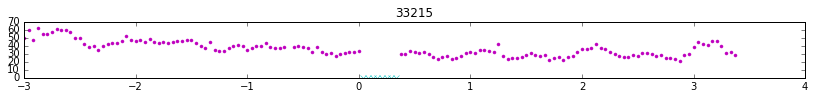

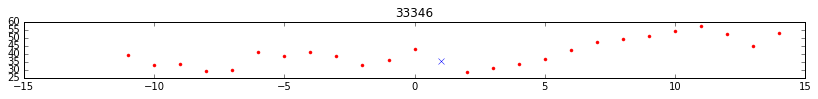

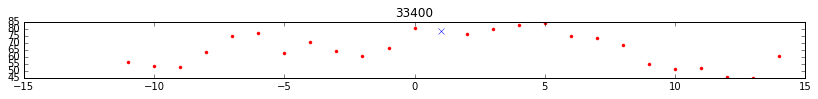

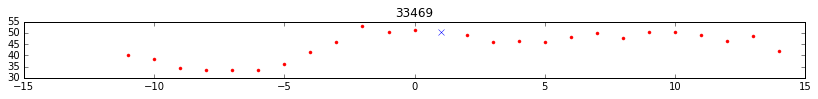

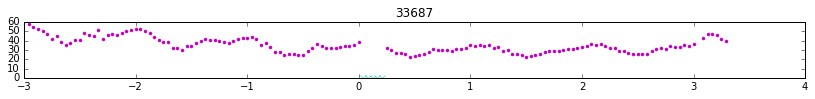

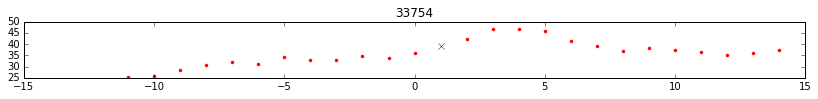

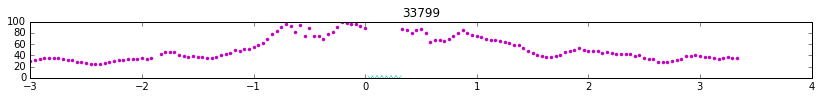

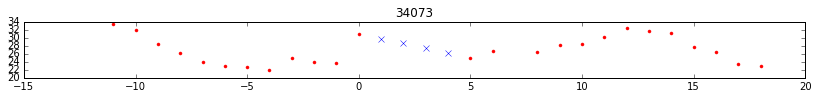

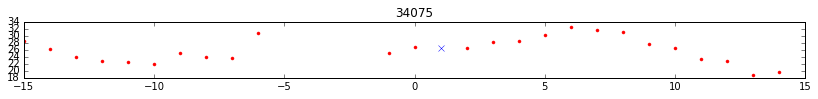

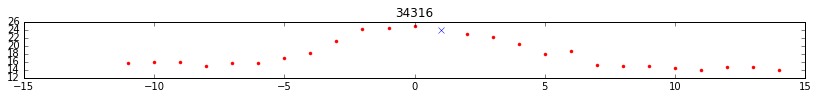

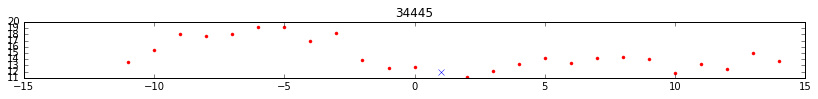

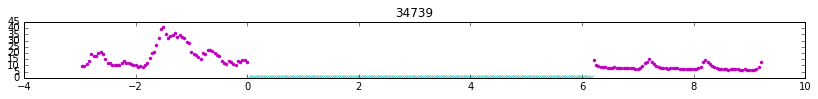

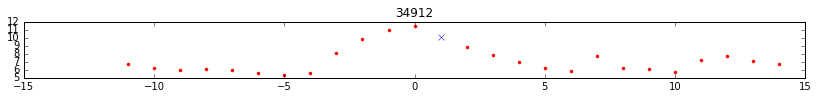

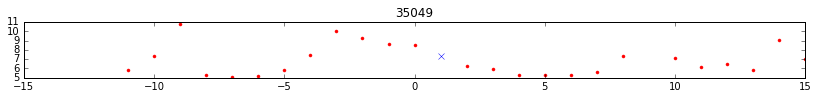

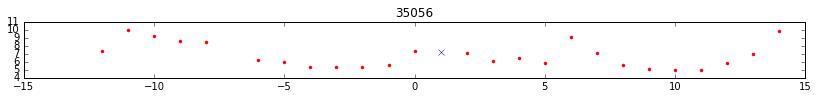

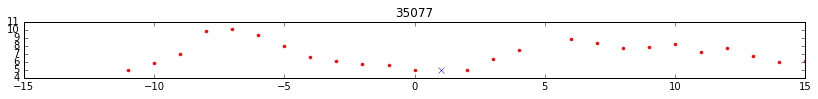

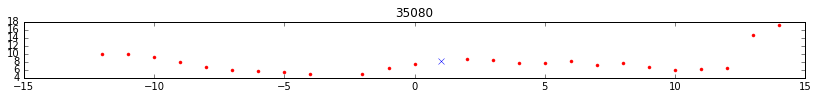

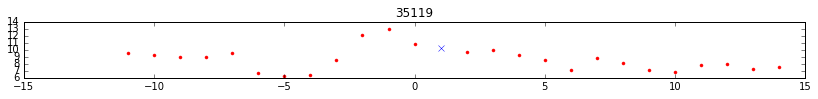

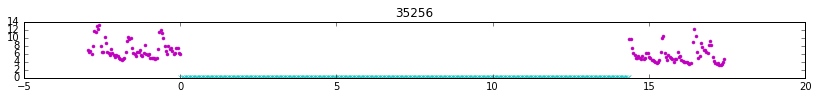

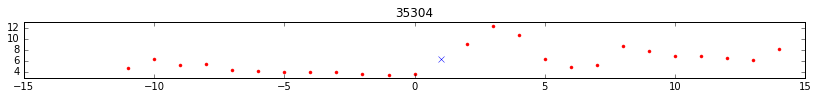

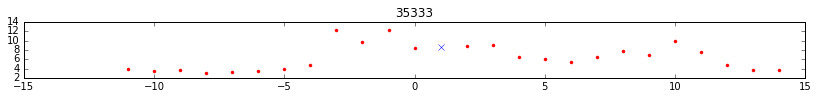

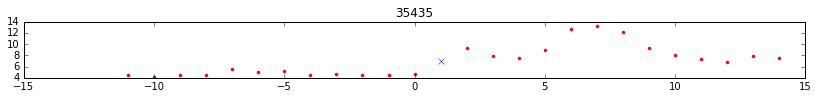

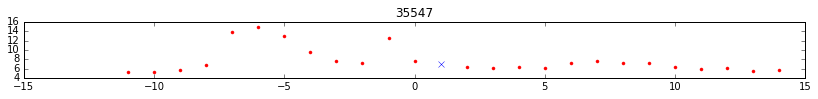

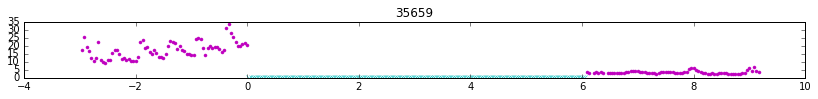

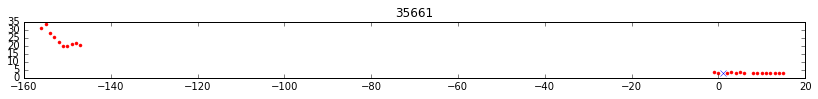

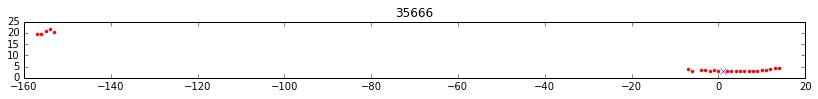

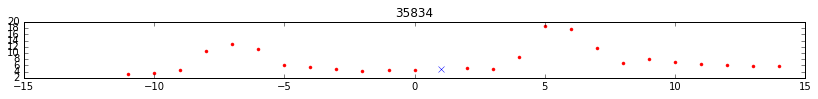

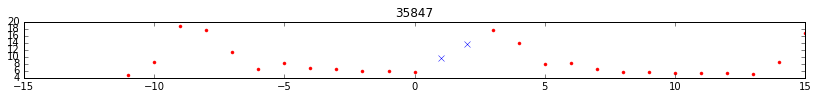

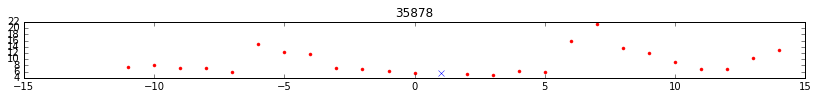

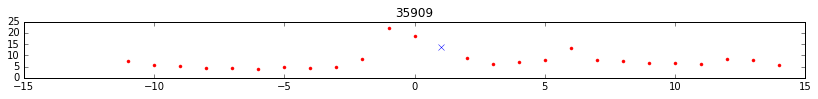

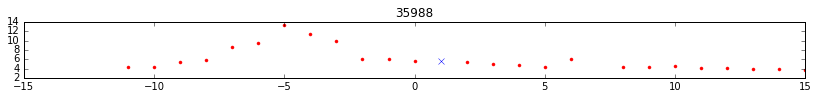

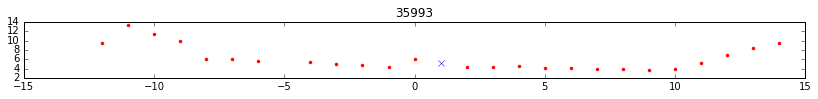

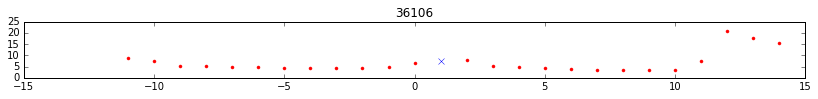

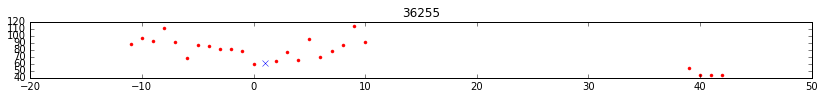

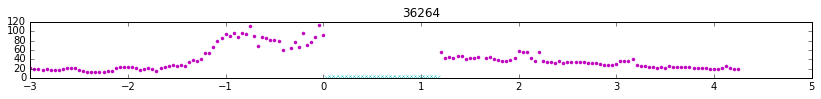

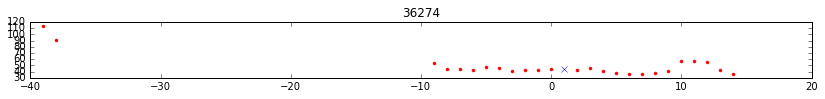

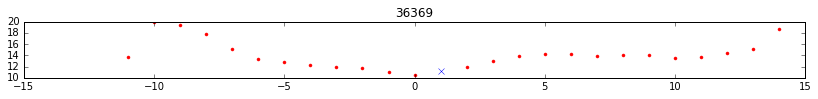

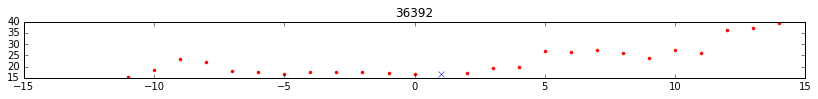

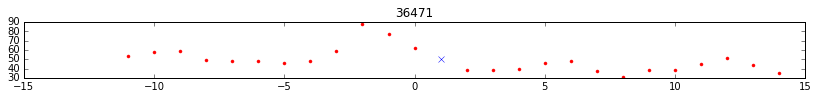

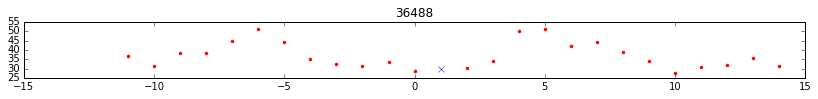

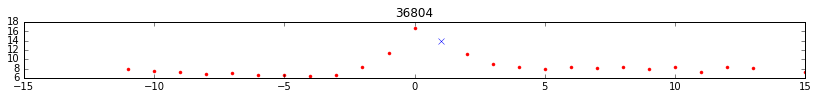

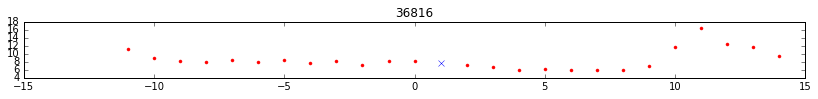

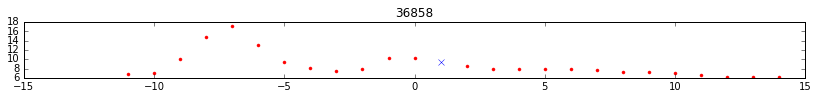

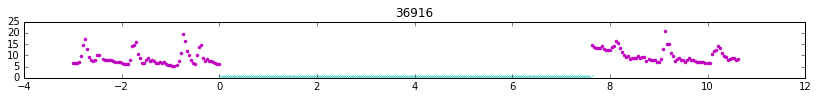

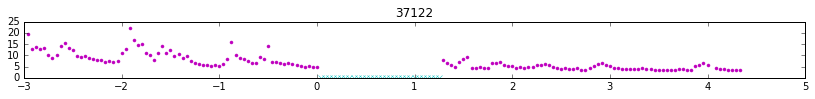

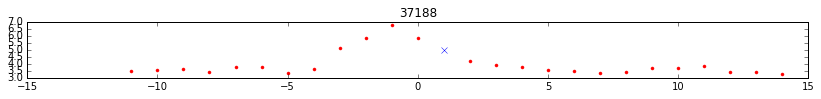

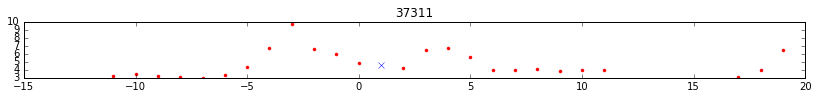

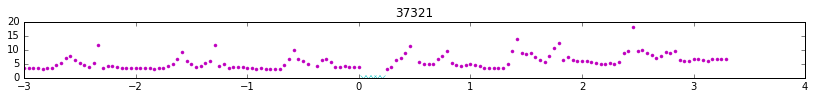

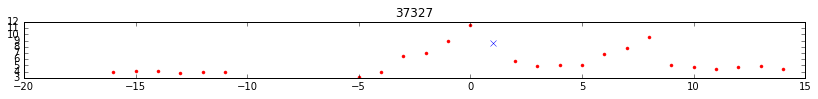

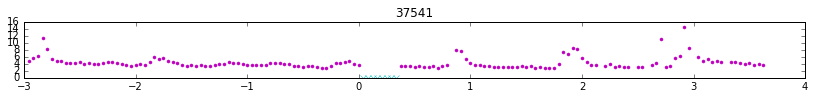

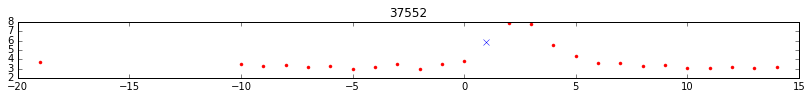

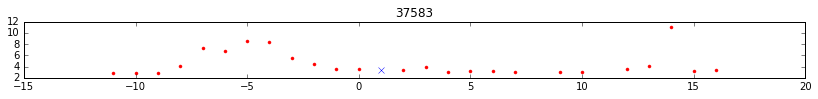

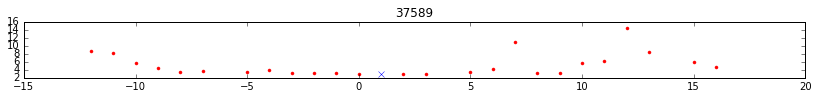

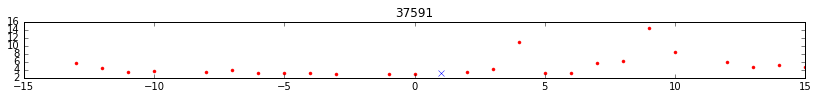

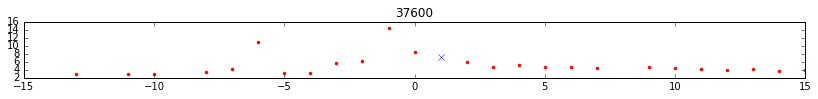

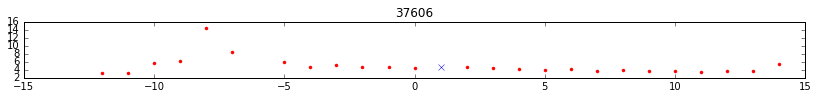

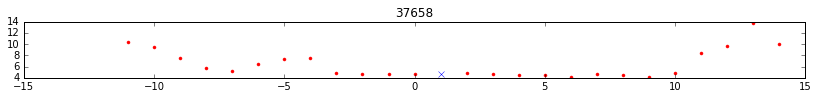

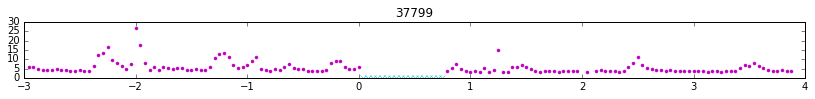

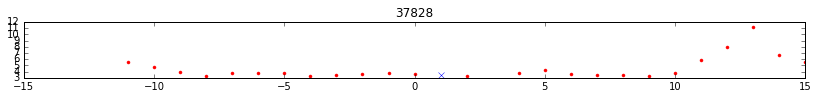

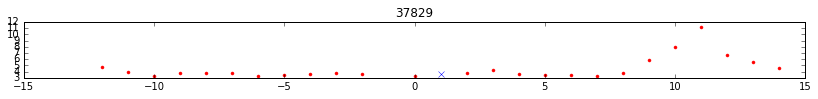

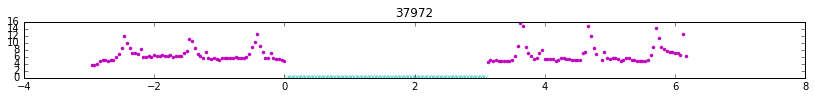

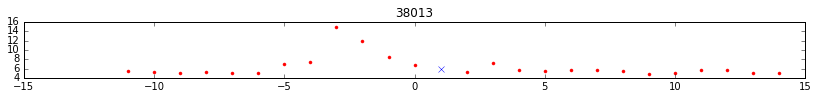

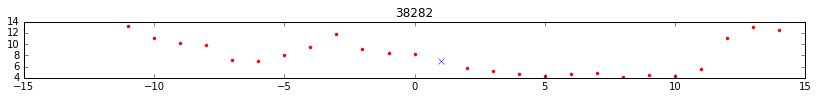

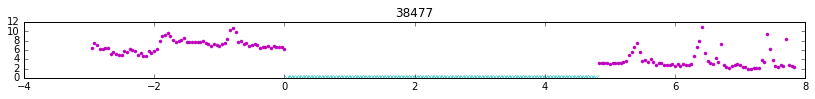

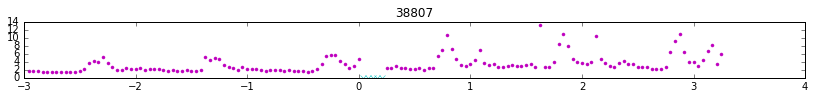

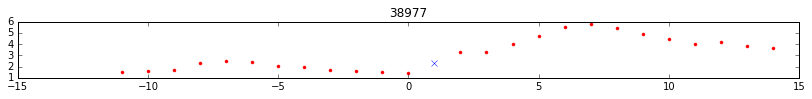

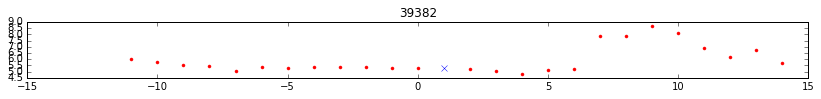

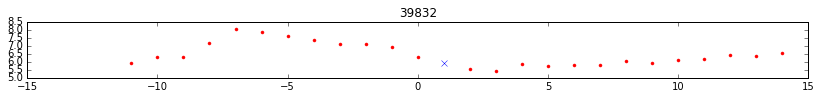

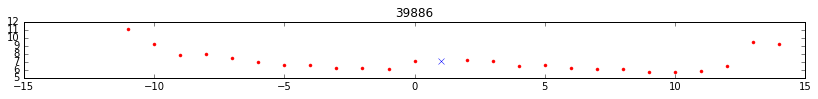

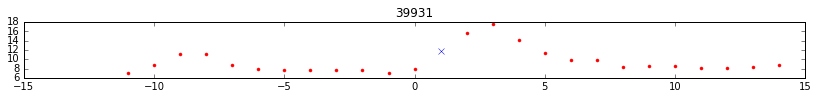

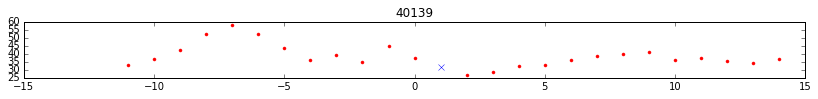

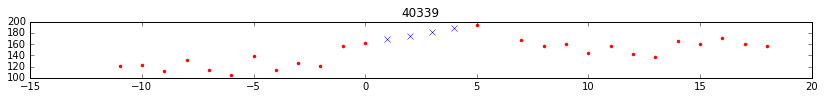

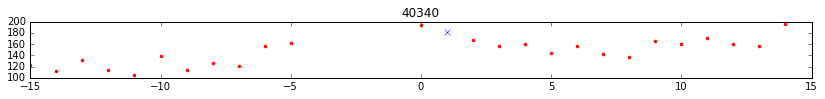

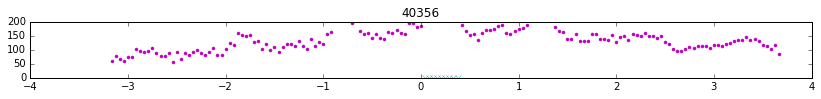

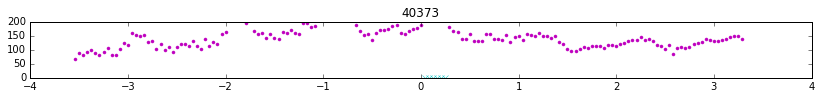

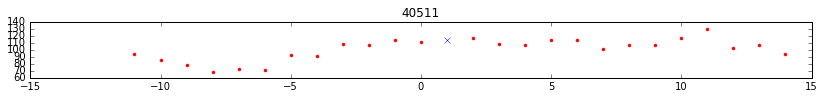

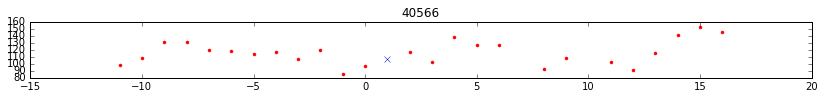

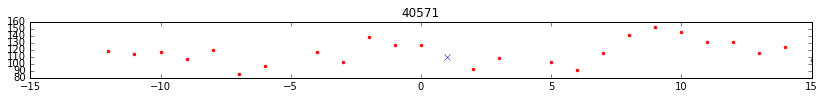

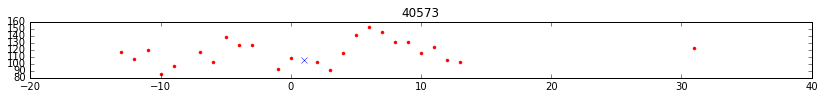

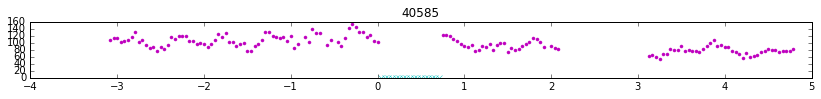

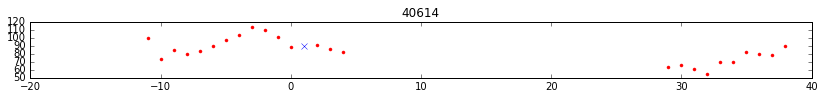

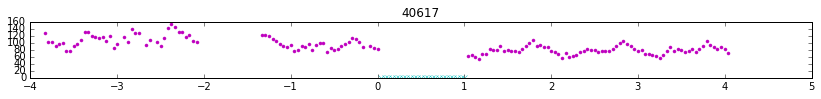

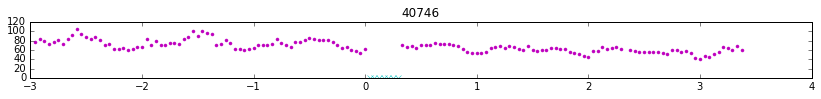

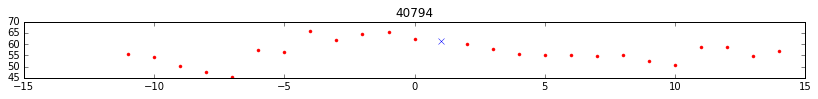

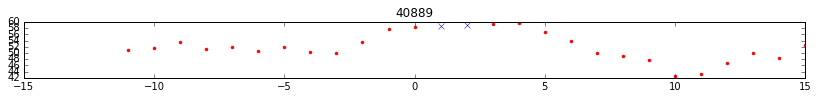

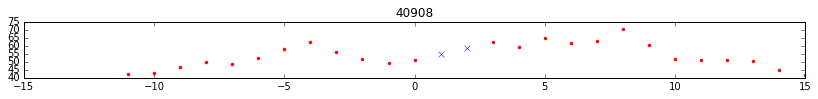

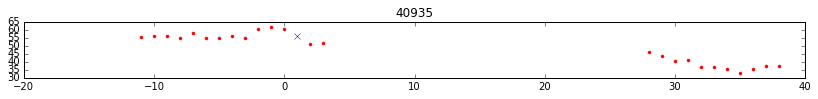

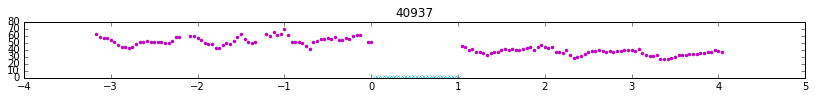

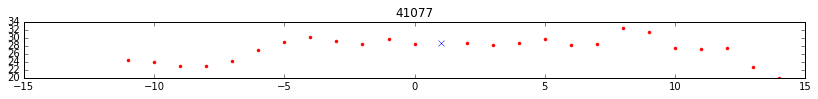

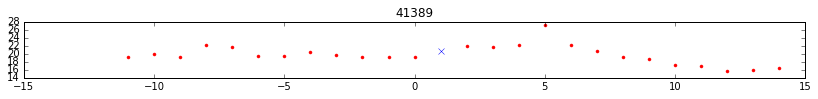

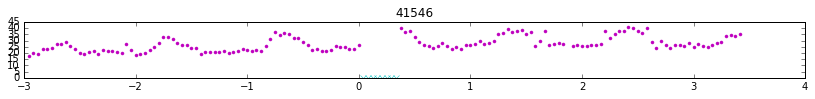

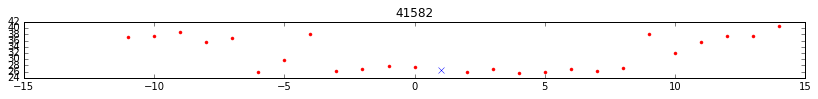

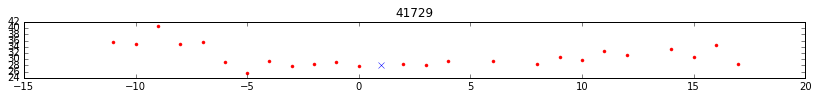

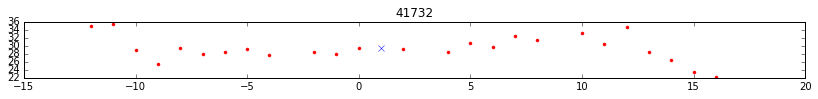

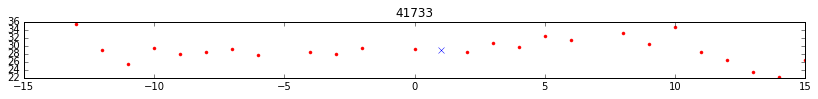

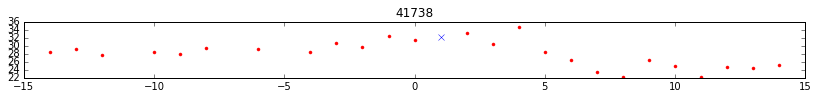

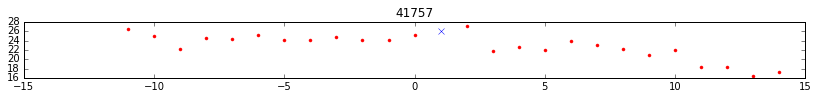

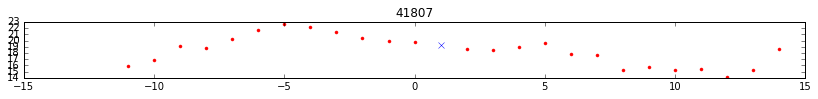

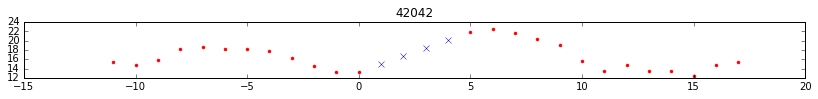

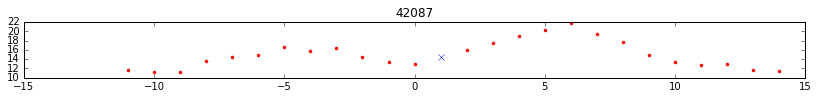

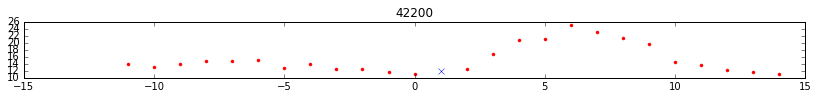

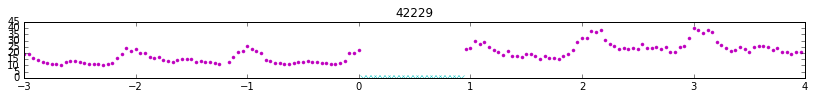

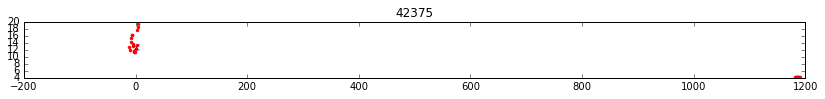

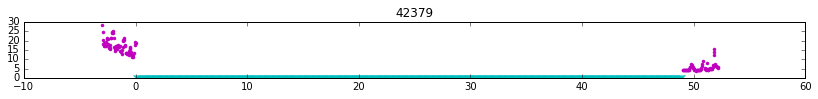

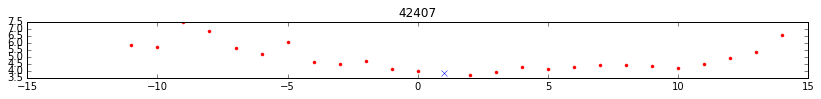

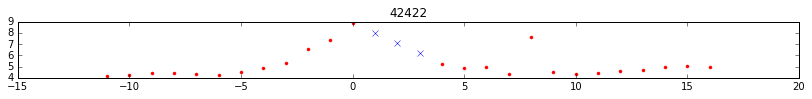

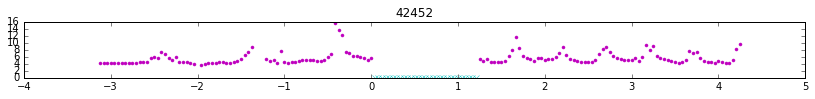

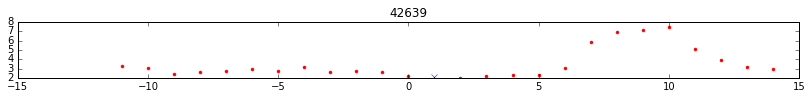

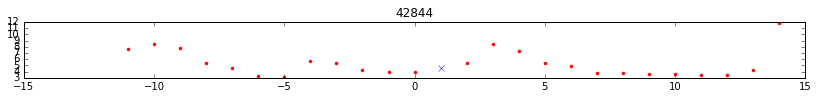

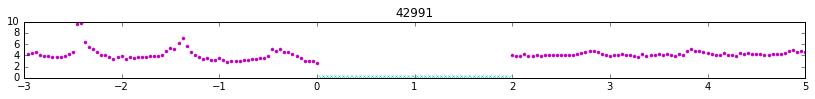

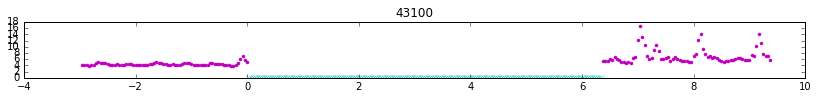

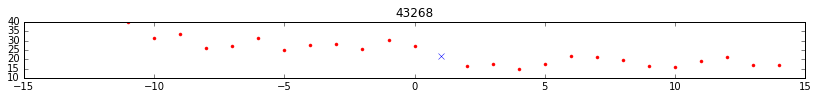

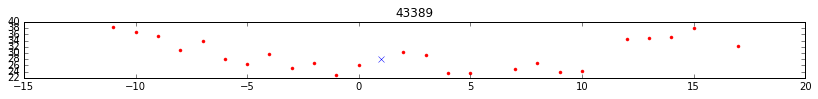

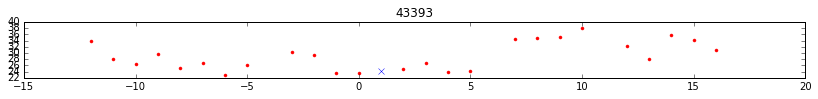

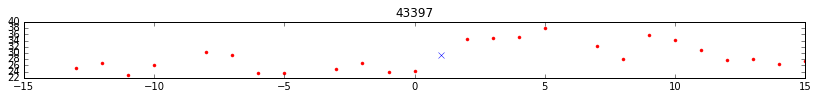

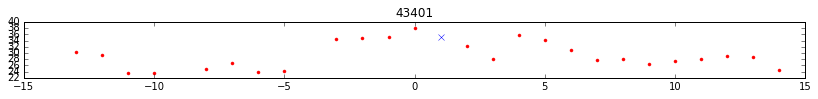

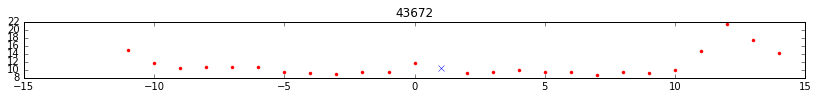

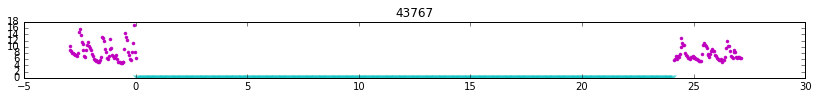

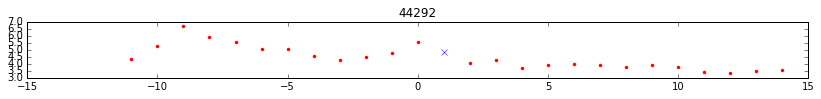

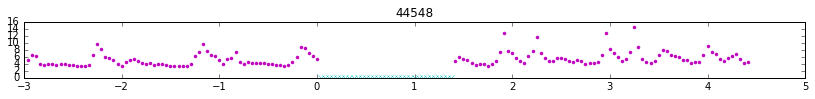

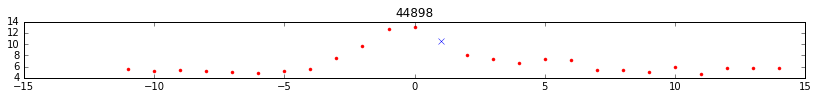

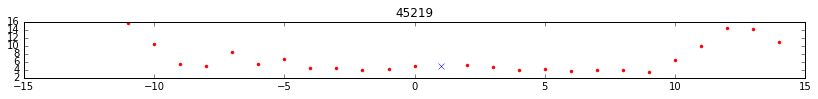

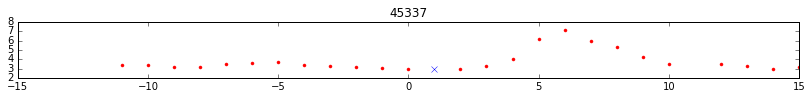

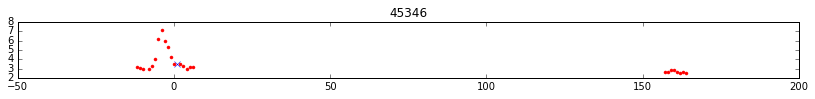

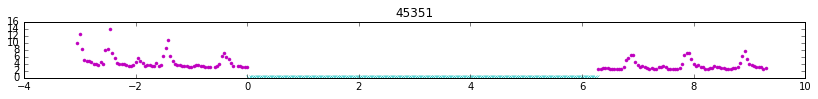

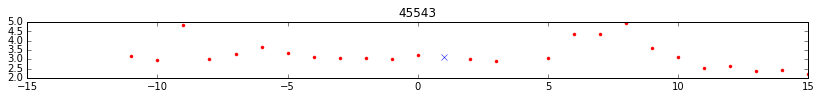

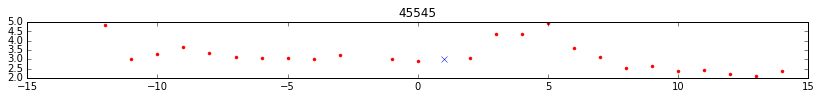

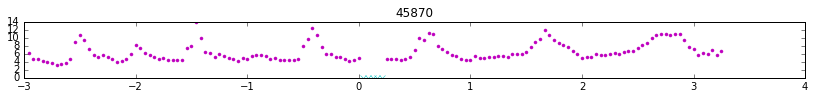

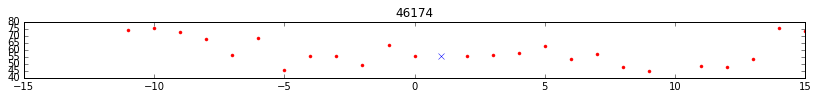

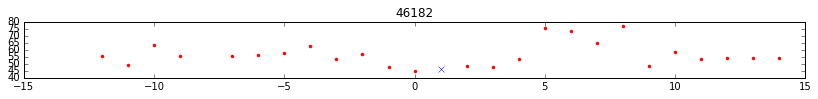

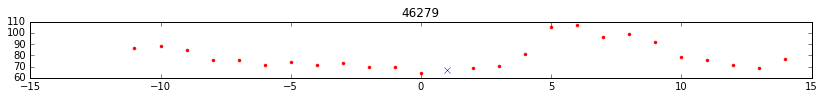

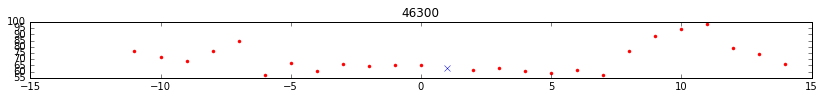

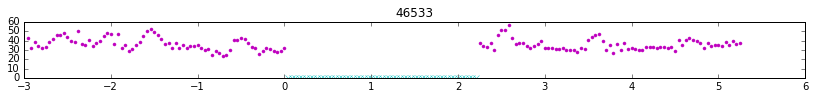

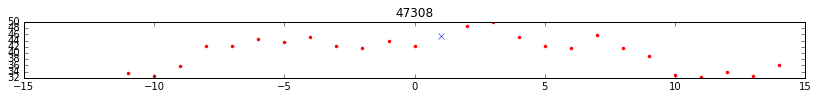

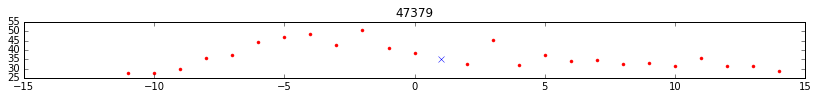

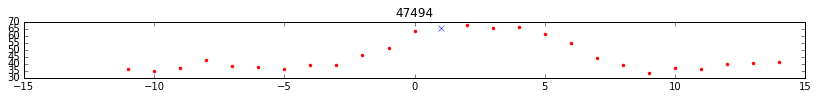

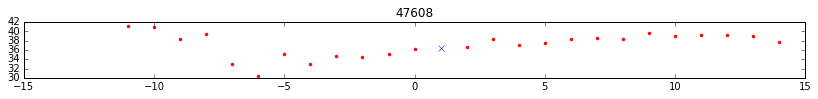

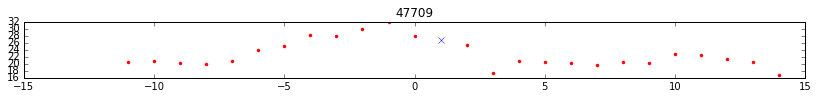

In [16]:
df0=df#[580:]
ddlast=df[(df.daynum==(startdate-dt.date(1900,1,1)).days)&(df.hr==0)]['DecDay'].values[0]-1.0/24.0
iout=0
for ind, row in df0.iterrows():
    #print(ind)
    
    # linearly interpolate breaks of 4 hrs or less
    if (((row['DecDay']-ddlast)<5.5/24.0)&((row['DecDay']-ddlast)>1.5/24.0)): 
        tlast=df0.loc[ind-1]['Turb_NTU']
        tnext=row['Turb_NTU']
        ddnext=row['DecDay']
        nint=int(np.round((ddnext-ddlast)*24)-1)
        fig,ax=plt.subplots(1,1,figsize=(14,1))
        ax.plot((df0.loc[(ind-12):(ind+12)]['DecDay']-ddlast)*24,df0.loc[(ind-12):(ind+12)]['Turb_NTU'],'r.')
        ax.set_title(str(ind))
        for ii in range(1,nint+1):
            dd0=ddlast+ii/24.0
            tur0=tlast+(dd0-ddlast)/(ddnext-ddlast)*(tnext-tlast)
            ax.plot((dd0-ddlast)*24,tur0,'bx')
            if ((dfout.loc[iout]['DayNum']+dfout.loc[iout]['Hour']/24.0-dd0)<.5/24.0):
                dfout.loc[iout]['Turb_NTU']=tur0
                iout+=1
            else:
                print('ERROR 2:')
                print(dfout.loc[iout]['DayNum']+dfout.loc[iout]['Hour']/24.0,
                      dd0,dfout.loc[iout]['DayNum']+dfout.loc[iout]['Hour']/24.0-dd0,.5/24.0)
                break
    elif ((row['DecDay']-ddlast)>5.5/24.0):# fill in larger holes with NaNs; interpolate between days later
        fig,ax=plt.subplots(1,1,figsize=(14,1))
        ax.plot(df0.loc[(ind-72):(ind+72)]['DecDay']-ddlast,df0.loc[(ind-72):(ind+72)]['Turb_NTU'],'m.')
        ax.set_title(str(ind))
        nint=int(np.round((row['DecDay']-ddlast)*24)-1)
        for ii in range(1,nint+1):
            dd0=ddlast+ii/24.0
            ax.plot((dd0-ddlast),0,'cx')
            if ((dfout.loc[iout]['DayNum']+dfout.loc[iout]['Hour']/24.0-dd0)<.5/24.0):
                dfout.loc[iout]['Turb_NTU']=np.nan
                iout+=1
            else:
                print('ERROR 4:')
                break
    # always append current row's value
    if ((dfout.loc[iout]['DayNum']==row['daynum'])&(dfout.loc[iout]['Hour']==row['hr'])):
        dfout.loc[iout]['Turb_NTU']=row['Turb_NTU']
    else:
        print('ERROR 1:')
        print('iout=',iout,'ind=',ind)
        print(dfout.loc[iout]['DayNum'],row['daynum'],dfout.loc[iout]['Hour'],row['hr'])
        break
    iout+=1
    ddlast=row['DecDay']
    
    

In [17]:
session.query(FBuoyTBL.Turb_NTU).filter(FBuoyTBL.DecDay.between(41850,41850.5)).all()

[(33.3),
 (36.0),
 (39.6),
 (37.2),
 (37.2),
 (39.9),
 (30.1),
 (33.5),
 (36.9),
 (28.1),
 (28.1),
 (28.0)]

In [18]:
dfout

DayNum Hour Turb_NTU
0      41273    0      6.3
1      41273    1      7.3
2      41273    2      8.3
3      41273    3      9.3
4      41273    4      6.8
5      41273    5      5.3
6      41273    6      3.8
7      41273    7      3.6
8      41273    8        4
9      41273    9       10
10     41273   10      3.1
11     41273   11      3.4
12     41273   12      3.2
13     41273   13      3.1
14     41273   14      3.4
15     41273   15      3.7
16     41273   16      3.7
17     41273   17      4.3
18     41273   18      3.2
19     41273   19      3.1
20     41273   20        3
21     41273   21      2.4
22     41273   22      2.7
23     41273   23      2.8
24     41274    0      3.1
25     41274    1      5.9
26     41274    2        8
27     41274    3      8.5
28     41274    4      7.1
29     41274    5      5.4
...      ...  ...      ...
56562  43629   18    28.85
56563  43629   19    28.19
56564  43629   20    27.15
56565  43629   21    26.19
56566  43629   22    23.23
56567  43629   23    20.36
56568  43630    0      NaN
56569  43630    1      NaN
56570  43630    2      NaN
56571  43630    3      NaN
56572  43630    4      NaN
56573  43630    5      NaN
56574  43630    6      NaN
56575  43630    7      NaN
56576  43630    8      NaN
56577  43630    9      NaN
56578  43630   10      NaN
56579  43630   11      NaN
56580  43630   12      NaN
56581  43630   13      NaN
56582  43630   14      NaN
56583  43630   15      NaN
56584  43630   16      NaN
56585  43630   17      NaN
56586  43630   18      NaN
56587  43630   19      NaN
56588  43630   20      NaN
56589  43630   21      NaN
56590  43630   22      NaN
56591  43630   23      NaN

[56592 rows x 3 columns]

In [19]:
for idd in range((startdate-dt.date(1900,1,1)).days,(enddate-dt.date(1900,1,1)).days):# intentionally don't fill in last one because of Nans
    tdata=dfout[(dfout.DayNum==idd)&(dfout.Turb_NTU>0)]['Turb_NTU'].values # exclude NaNs
    nn=len(tdata)
    if nn>19: #more  than 80% of day represented
        dfdaily.loc[dfdaily.DayNum==idd,'Turb_NTU']=np.mean(tdata)

In [20]:
dfdaily

DayNum Turb_NTU
0     41273    4.575
1     41274  4.20417
2     41275  3.54167
3     41276   3.5875
4     41277  3.87083
5     41278  3.91667
6     41279  4.77708
7     41280     4.95
8     41281  7.17917
9     41282   8.9375
10    41283  11.0083
11    41284  11.0542
12    41285  10.5708
13    41286  10.2375
14    41287  7.97708
15    41288  6.35208
16    41289   4.9125
17    41290  4.12917
18    41291  3.44792
19    41292  3.37708
20    41293      NaN
21    41294      NaN
22    41295      NaN
23    41296  4.47083
24    41297      4.9
25    41298      5.2
26    41299      NaN
27    41300      NaN
28    41301      NaN
29    41302      NaN
...     ...      ...
2328  43601  54.6933
2329  43602  52.9371
2330  43603  55.6879
2331  43604  48.3867
2332  43605  41.8487
2333  43606  41.5158
2334  43607    41.46
2335  43608  41.3992
2336  43609  43.1867
2337  43610  40.7706
2338  43611  43.0971
2339  43612  38.8617
2340  43613  36.6917
2341  43614  36.7454
2342  43615  33.9971
2343  43616  35.3263
2344  43617  39.7792
2345  43618  44.8592
2346  43619  48.1779
2347  43620  49.2167
2348  43621  48.3029
2349  43622  41.8708
2350  43623  37.6394
2351  43624  33.2967
2352  43625  29.9583
2353  43626  26.8413
2354  43627  24.1933
2355  43628    22.72
2356  43629  21.0329
2357  43630      NaN

[2358 rows x 2 columns]

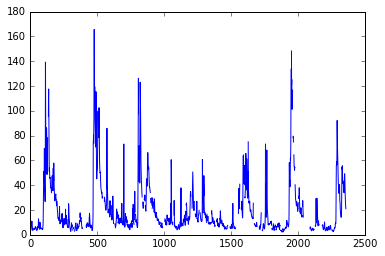

In [21]:
plt.plot(dfdaily['Turb_NTU'])

In [22]:
dds=dfdaily[dfdaily.Turb_NTU>0]['DayNum'].values
ts=dfdaily[dfdaily.Turb_NTU>0]['Turb_NTU'].values

In [23]:
dfnan=dfdaily[~(dfdaily.Turb_NTU>0)]
ddblanks=dfnan['DayNum'].values

In [24]:
dds1=[np.float(el) for el in dds]
ts1=[np.float(el) for el in ts]
ddblanks1=[np.float(el) for el in ddblanks]
tinterps=np.interp(ddblanks1,dds1,ts1)

In [25]:
oldDD=np.copy(dfdaily['DayNum'].values)
oldT=np.copy(dfdaily['Turb_NTU'].values)

In [26]:
for idd, newT in zip(ddblanks1,tinterps):
    dfdaily.loc[dfdaily.DayNum==idd,'Turb_NTU']=newT

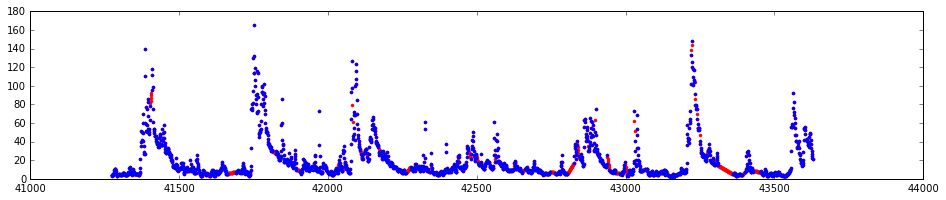

In [27]:
fig,ax=plt.subplots(1,1,figsize=(16,3))
ax.plot(dfdaily['DayNum'],dfdaily['Turb_NTU'],'r.')
ax.plot(oldDD,oldT,'b.')

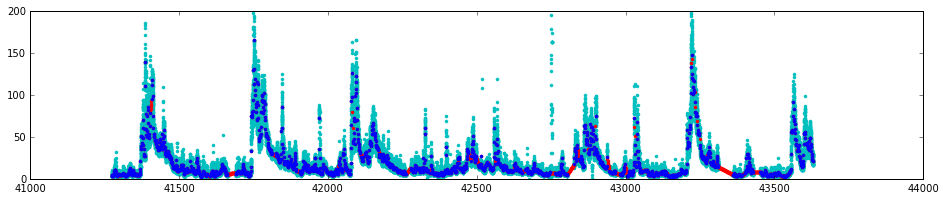

In [28]:
fig,ax=plt.subplots(1,1,figsize=(16,3))
ax.plot(df['DecDay'],df['Turb_NTU'],'c.')
ax.plot(dfdaily['DayNum'],dfdaily['Turb_NTU'],'r.')
ax.plot(oldDD,oldT,'b.')

In [29]:
iday=(startdate-dt.date(1900,1,1)).days
iTurb=dfdaily[dfdaily.DayNum==iday]['Turb_NTU'].values[0]
iTurb

4.574999999996362

## Interpolation/averaging look OK; now create files: 

create daily Fraser turbidity files:

In [30]:
f=nc.Dataset('/results/forcing/rivers/RLonFraCElse_y2016m01d23.nc') # example for dims
fnamebase='/ocean/eolson/MEOPAR/NEMO-forcing/rivers/riverTurbDaily201906_'
for idate in daterange(startdate,enddate):
    iday=(idate-dt.date(1900,1,1)).days
    lower=iday
    upper=iday+1
    iTurb=dfdaily[dfdaily.DayNum==iday]['Turb_NTU'].values[0]

    fname=fnamebase+idate.strftime('y%Ym%md%d')+'.nc'

    new=nc.Dataset(fname,'w')
    #Copy dimensions
    for dname, the_dim in f.dimensions.items():
        #print (dname, len(the_dim) if not the_dim.isunlimited() else None)
        new.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
    # create dimension variables:
    new_x=new.createVariable('nav_lat',np.float32,('y','x'),zlib=True)
    new_x[:]=f.variables['nav_lat'][:,:]

    new_y=new.createVariable('nav_lon',np.float32,('y','x'),zlib=True)
    new_y[:]=f.variables['nav_lon'][:,:]

    new_tc=new.createVariable('time_counter',np.float32,('time_counter'),zlib=True)
    new_tc[:]=f.variables['time_counter'][:]
    
    new_run=new.createVariable('turb',float,('time_counter', 'y', 'x'),zlib=True)
    new_run[:,:,:]=-999.99 # most cells are masked with negative numbers
    new_run[:,400:448, 338:380]=iTurb # set turbidity to daily average
    new_run[:,440:503,363:398]=iTurb # extend Turbidity all the way up river

    new.close()

In [31]:
ftest=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/rivers/riverTurbDaily201906_y2014m01d02.nc')

In [32]:
ftest

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): x(398), y(898), time_counter(1)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 time_counter(time_counter), float64 turb(time_counter,y,x)
    groups: 

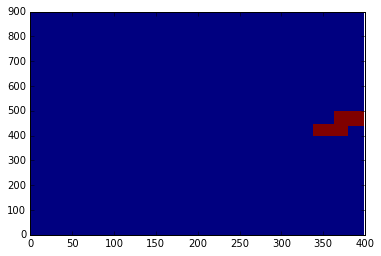

In [33]:
plt.pcolormesh(ftest.variables['turb'][0,:,:])

In [34]:
ftest.variables['turb'][0,410:425,364:368]

array([[ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625]])

In [35]:
ftest.close()

In [36]:
ftest=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/rivers/riverTurbDaily201906_y2017m06d21.nc')

In [37]:
ftest.variables['turb'][0,410:425,364:368]

array([[ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333]])

In [38]:
ftest.close()